In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import pandas as pd
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from tensorflow.keras import layers, losses, optimizers
import joblib
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.dates as mdates
import datetime

import pickle
from statsmodels.tsa.arima.model import ARIMA

from scipy.stats import chi2
import statsmodels.api as sm
import pylab as py


# A study about the power of Giacomini-White (GW) test in forecast evaluation, with an application to SP500 index dataset

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### 0. Download data

In [3]:

# Download data
data = yf.download("^GSPC", start="2015-05-23", end="2023-05-23")
data.reset_index(inplace=True)
data.set_index("Date", inplace=True)


[*********************100%***********************]  1 of 1 completed


In [4]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-26,2125.340088,2125.340088,2099.179932,2104.199951,2104.199951,3342130000
2015-05-27,2105.129883,2126.219971,2105.129883,2123.479980,2123.479980,3127960000
2015-05-28,2122.270020,2122.270020,2112.860107,2120.790039,2120.790039,2980350000


In [5]:
data.shape

(2013, 6)

In [6]:
# Get date and close colums from data
df_ori = data.loc[:, ["Close"]]


In [322]:
df_ori

,Close
Date,
2015-05-26,2104.199951
2015-05-27,2123.479980
2015-05-28,2120.790039
2015-05-29,2107.389893
2015-06-01,2111.729980
...,...
2023-05-16,4109.899902
2023-05-17,4158.770020
2023-05-18,4198.049805


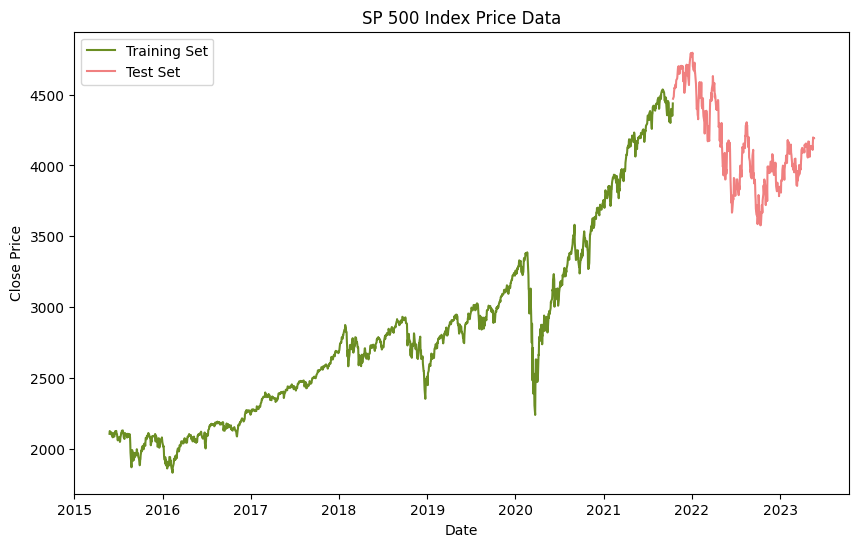

In [334]:

# Assuming 'data' is your DataFrame with a DateTimeIndex
# If not, convert the index to DateTimeIndex if necessary
df_ori.index = pd.to_datetime(df_ori.index)

# Calculate the index to split the data (80% for training)
split_date = df_ori.index[int(0.8 * len(df_ori))]

# Split the data into two parts
training_data_plot = df_ori.loc[df_ori.index <= split_date]
test_data_plot= df_ori.loc[df_ori.index > split_date]

# Plot the training data in blue and test data in red
plt.figure(figsize=(10, 6))
plt.plot(training_data_plot.index, training_data_plot["Close"], color='olivedrab', label='Training Set')
plt.plot(test_data_plot.index, test_data_plot["Close"], color='lightcoral', label='Test Set')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SP 500 Index Price Data')
plt.legend()

# Show the plot
plt.show()


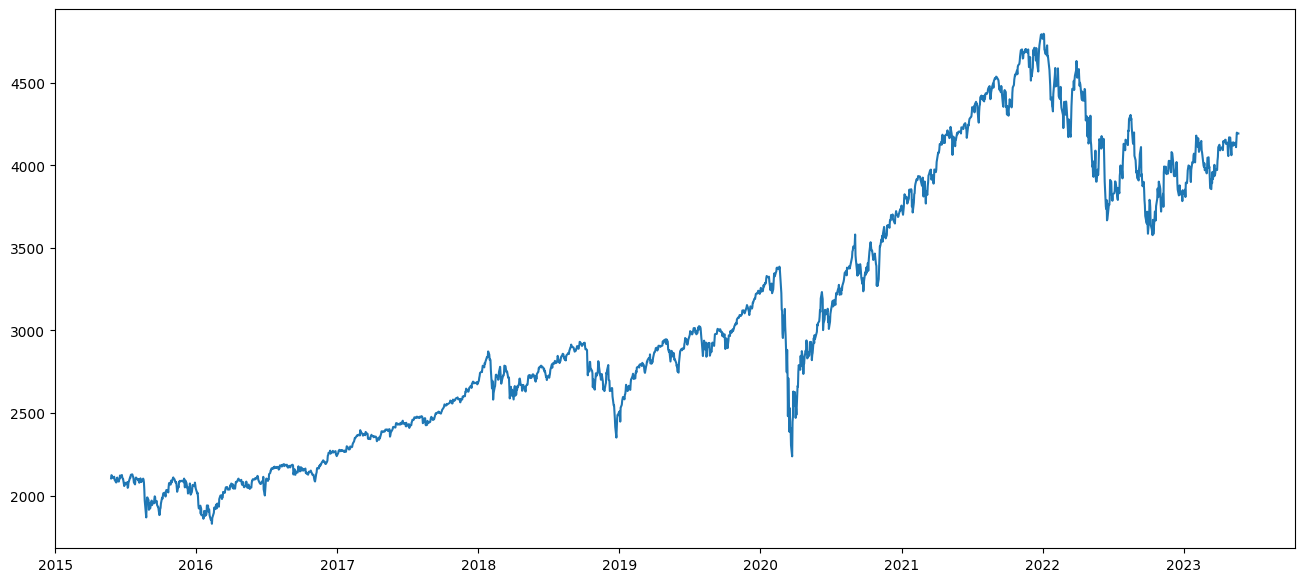

In [7]:
plt.figure(figsize=(16,7))

plt.plot(data.loc[:, "Close"])

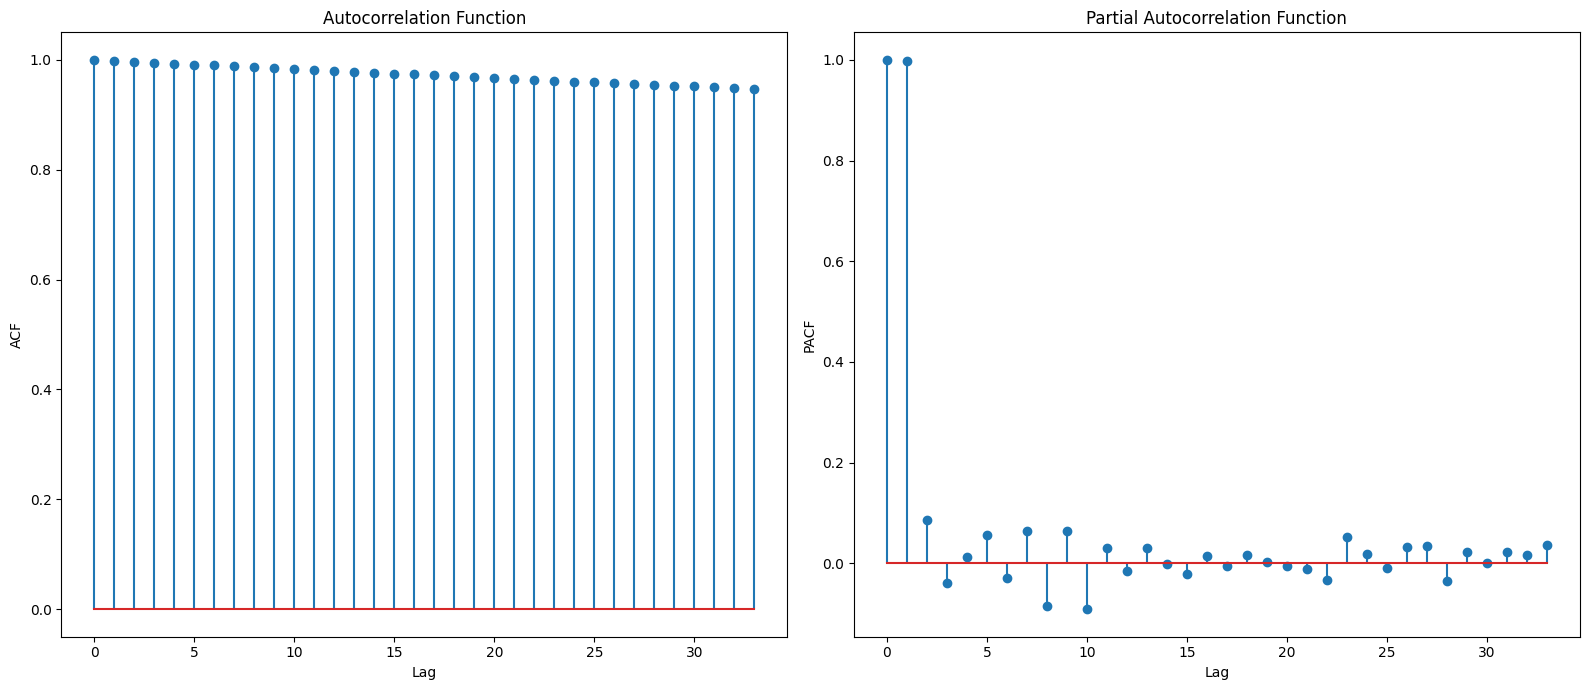

In [8]:

# Compute ACF and PACF
acf = sm.tsa.stattools.acf(df_ori)
pacf = sm.tsa.stattools.pacf(df_ori)

# Plot ACF
plt.figure(figsize=(16,7))

plt.subplot(1, 2, 1)
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(1, 2, 2)
plt.stem(pacf)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function')

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()


In [9]:
df_ori.shape

(2013, 1)

In [10]:
df_ori["Close"]

Date
2015-05-26    2104.199951
2015-05-27    2123.479980
2015-05-28    2120.790039
2015-05-29    2107.389893
2015-06-01    2111.729980
                 ...     
2023-05-16    4109.899902
2023-05-17    4158.770020
2023-05-18    4198.049805
2023-05-19    4191.979980
2023-05-22    4192.629883
Name: Close, Length: 2013, dtype: float64

### 1. Lag data

In [11]:
# Lag data
def lag_transform(x, k=1):
    lagged = np.concatenate([np.repeat(np.nan, k), x[:len(x)-k]])
    df = pd.DataFrame({'x-'+str(k): lagged, 'x': x})
    df.fillna(0, inplace=True)
    return df

In [12]:
df=lag_transform(data["Close"],1)

In [13]:
df= df.rename(columns={"x-1": "x","x":"y"})


In [14]:
df.head(5)

,x,y
Date,,
2015-05-26,0.000000,2104.199951
2015-05-27,2104.199951,2123.479980
2015-05-28,2123.479980,2120.790039
2015-05-29,2120.790039,2107.389893
2015-06-01,2107.389893,2111.729980


In [15]:
# Split data 
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)


In [16]:
train_data.shape

(1610, 2)

In [17]:
test_data.shape

(403, 2)

In [18]:
train_predictor = train_data["x"]
train_target=train_data["y"]
test_predictor=test_data["x"]
test_target=test_data["y"]

In [19]:
test_data

,x,y
Date,,
2021-10-14,4363.799805,4438.259766
2021-10-15,4438.259766,4471.370117
2021-10-18,4471.370117,4486.459961
2021-10-19,4486.459961,4519.629883
2021-10-20,4519.629883,4536.189941
...,...,...
2023-05-16,4136.279785,4109.899902
2023-05-17,4109.899902,4158.770020
2023-05-18,4158.770020,4198.049805


In [20]:
test_data.index

DatetimeIndex(['2021-10-14', '2021-10-15', '2021-10-18', '2021-10-19',
               '2021-10-20', '2021-10-21', '2021-10-22', '2021-10-25',
               '2021-10-26', '2021-10-27',
               ...
               '2023-05-09', '2023-05-10', '2023-05-11', '2023-05-12',
               '2023-05-15', '2023-05-16', '2023-05-17', '2023-05-18',
               '2023-05-19', '2023-05-22'],
              dtype='datetime64[ns]', name='Date', length=403, freq=None)

In [21]:
train_predictor

Date
2015-05-26       0.000000
2015-05-27    2104.199951
2015-05-28    2123.479980
2015-05-29    2120.790039
2015-06-01    2107.389893
                 ...     
2021-10-07    4363.549805
2021-10-08    4399.759766
2021-10-11    4391.339844
2021-10-12    4361.189941
2021-10-13    4350.649902
Name: x, Length: 1610, dtype: float64

### 4. Reshape data to windown size =5 and timestep=1

In [22]:
# Reshape input data [batch size, timestep, feature=1] and output
def dataset_generator_lstm(dataset, look_back=5):
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep. 
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)



In [23]:
train_predictor, train_target = dataset_generator_lstm(train_data.values,look_back=5)

test_predictor, test_target = dataset_generator_lstm(test_data.values,look_back=5)

print("trainX: ", train_predictor.shape)
print("trainY: ", train_target.shape)
print("testX: ", test_predictor.shape)
print("testY", test_target.shape)

trainX:  (1605, 5)
trainY:  (1605,)
testX:  (398, 5)
testY (398,)


In [24]:
test_data

,x,y
Date,,
2021-10-14,4363.799805,4438.259766
2021-10-15,4438.259766,4471.370117
2021-10-18,4471.370117,4486.459961
2021-10-19,4486.459961,4519.629883
2021-10-20,4519.629883,4536.189941
...,...,...
2023-05-16,4136.279785,4109.899902
2023-05-17,4109.899902,4158.770020
2023-05-18,4158.770020,4198.049805


In [25]:
test_predictor

array([[4363.79980469, 4438.25976562, 4471.37011719, 4486.45996094,
        4519.62988281],
       [4438.25976562, 4471.37011719, 4486.45996094, 4519.62988281,
        4536.18994141],
       [4471.37011719, 4486.45996094, 4519.62988281, 4536.18994141,
        4549.77978516],
       ...,
       [4137.64013672, 4130.62011719, 4124.08007812, 4136.27978516,
        4109.89990234],
       [4130.62011719, 4124.08007812, 4136.27978516, 4109.89990234,
        4158.77001953],
       [4124.08007812, 4136.27978516, 4109.89990234, 4158.77001953,
        4198.04980469]])

In [26]:
test_predictor.shape

(398, 5)

In [27]:
test_predictor

array([[4363.79980469, 4438.25976562, 4471.37011719, 4486.45996094,
        4519.62988281],
       [4438.25976562, 4471.37011719, 4486.45996094, 4519.62988281,
        4536.18994141],
       [4471.37011719, 4486.45996094, 4519.62988281, 4536.18994141,
        4549.77978516],
       ...,
       [4137.64013672, 4130.62011719, 4124.08007812, 4136.27978516,
        4109.89990234],
       [4130.62011719, 4124.08007812, 4136.27978516, 4109.89990234,
        4158.77001953],
       [4124.08007812, 4136.27978516, 4109.89990234, 4158.77001953,
        4198.04980469]])

In [28]:
test_target

array([4536.18994141, 4549.77978516, 4544.89990234, 4566.47998047,
       4574.79003906, 4551.68017578, 4596.41992188, 4605.37988281,
       4613.66992188, 4630.64990234, 4660.56982422, 4680.06005859,
       4697.52978516, 4701.70019531, 4685.25      , 4646.70996094,
       4649.27001953, 4682.85009766, 4682.79980469, 4700.89990234,
       4688.66992188, 4704.54003906, 4697.95996094, 4682.93994141,
       4690.70019531, 4701.45996094, 4594.62011719, 4655.27001953,
       4567.        , 4513.04003906, 4577.10009766, 4538.43017578,
       4591.66992188, 4686.75      , 4701.20996094, 4667.45019531,
       4712.02001953, 4668.97021484, 4634.08984375, 4709.85009766,
       4668.66992188, 4620.64013672, 4568.02001953, 4649.22998047,
       4696.56005859, 4725.79003906, 4791.18994141, 4786.35009766,
       4793.06005859, 4778.72998047, 4766.18017578, 4796.56005859,
       4793.54003906, 4700.58007812, 4696.04980469, 4677.02978516,
       4670.29003906, 4713.06982422, 4726.35009766, 4659.02978

In [29]:
train_predictor

array([[   0.        , 2104.19995117, 2123.47998047, 2120.79003906,
        2107.38989258],
       [2104.19995117, 2123.47998047, 2120.79003906, 2107.38989258,
        2111.72998047],
       [2123.47998047, 2120.79003906, 2107.38989258, 2111.72998047,
        2109.60009766],
       ...,
       [4357.04003906, 4300.45996094, 4345.72021484, 4363.54980469,
        4399.75976562],
       [4300.45996094, 4345.72021484, 4363.54980469, 4399.75976562,
        4391.33984375],
       [4345.72021484, 4363.54980469, 4399.75976562, 4391.33984375,
        4361.18994141]])

In [30]:
train_target

array([2111.72998047, 2109.60009766, 2114.07006836, ..., 4391.33984375,
       4361.18994141, 4350.64990234])

In [31]:
train_data

,x,y
Date,,
2015-05-26,0.000000,2104.199951
2015-05-27,2104.199951,2123.479980
2015-05-28,2123.479980,2120.790039
2015-05-29,2120.790039,2107.389893
2015-06-01,2107.389893,2111.729980
...,...,...
2021-10-07,4363.549805,4399.759766
2021-10-08,4399.759766,4391.339844
2021-10-11,4391.339844,4361.189941


### 2. Grid Search CV and LSTM

In [32]:
train_predictor_reshape = np.reshape(train_predictor ,(train_predictor.shape[0], 5, 1))
test_predictor_reshape=np.reshape(test_predictor, (test_predictor.shape[0], 5, 1))

In [33]:
test_predictor_reshape.shape

(398, 5, 1)

In [34]:
patience = 10  # Number of epochs with no improvement after which training will be stopped
monitor = 'val_loss'  # Metric to monitor for early stopping
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

In [35]:
""" # Define a function to create the LSTM model
def LSTM_model(neurons_per_layer, activation='relu', optimizer='adam', dropout=0.0, num_layers=1, time_steps=5,batch_size=2):
    
    model = Sequential()
    if num_layers == 1:
        model.add(LSTM(units=neurons_per_layer, activation=activation, batch_input_shape=(batch_size,time_steps, 1)))
    else:
        model.add(LSTM(units=neurons_per_layer, activation=activation, return_sequences=True,  batch_input_shape=(batch_size,time_steps, 1)))
        for i in range(num_layers-2):
            model.add(LSTM(units=neurons_per_layer, activation=activation, return_sequences=True))
        model.add(LSTM(units=neurons_per_layer, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model


# Create a KerasRegressor object with the create_model function
model = KerasRegressor(build_fn=LSTM_model, verbose=0) """

" # Define a function to create the LSTM model\ndef LSTM_model(neurons_per_layer, activation='relu', optimizer='adam', dropout=0.0, num_layers=1, time_steps=5,batch_size=2):\n    \n    model = Sequential()\n    if num_layers == 1:\n        model.add(LSTM(units=neurons_per_layer, activation=activation, batch_input_shape=(batch_size,time_steps, 1)))\n    else:\n        model.add(LSTM(units=neurons_per_layer, activation=activation, return_sequences=True,  batch_input_shape=(batch_size,time_steps, 1)))\n        for i in range(num_layers-2):\n            model.add(LSTM(units=neurons_per_layer, activation=activation, return_sequences=True))\n        model.add(LSTM(units=neurons_per_layer, activation=activation))\n    model.add(Dropout(dropout))\n    model.add(Dense(1))\n    model.compile(loss='mean_absolute_error', optimizer=optimizer)\n    return model\n\n\n# Create a KerasRegressor object with the create_model function\nmodel = KerasRegressor(build_fn=LSTM_model, verbose=0) "

In [36]:
""" # Define the hyperparameter grid
param_grid = {
    'neurons_per_layer': [32,50,100],
    'num_layers': [1, 2,3],
    'batch_size': [4,16,32],
    'dropout': [0.0, 0.1,0.2],
}
# Create a GridSearchCV object with the model and hyperparameter grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1,scoring="neg_mean_absolute_error")

# Reshape the data for each combination of batch_size and time_steps
#for batch_size in param_grid['batch_size']:
    #for time_steps in param_grid['time_steps']:

start_time = time.time()

grid.fit(train_predictor_reshape, train_target,validation_data=(test_predictor_reshape,test_target),
                            epochs=150,callbacks=[early_stopping],verbose=0)

end_time = time.time()

# Print the best set of hyperparameters
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("Execution time: ", end_time - start_time, " seconds") """

' # Define the hyperparameter grid\nparam_grid = {\n    \'neurons_per_layer\': [32,50,100],\n    \'num_layers\': [1, 2,3],\n    \'batch_size\': [4,16,32],\n    \'dropout\': [0.0, 0.1,0.2],\n}\n# Create a GridSearchCV object with the model and hyperparameter grid\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1,scoring="neg_mean_absolute_error")\n\n# Reshape the data for each combination of batch_size and time_steps\n#for batch_size in param_grid[\'batch_size\']:\n    #for time_steps in param_grid[\'time_steps\']:\n\nstart_time = time.time()\n\ngrid.fit(train_predictor_reshape, train_target,validation_data=(test_predictor_reshape,test_target),\n                            epochs=150,callbacks=[early_stopping],verbose=0)\n\nend_time = time.time()\n\n# Print the best set of hyperparameters\nprint("Best: %f using %s" % (grid.best_score_, grid.best_params_))\nprint("Execution time: ", end_time - start_time, " seconds") '

In [37]:
""" grid_loaded = joblib.load('grid_search.pkl')
 """

" grid_loaded = joblib.load('grid_search.pkl')\n "

In [38]:
""" cv_results = grid_loaded .cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(mean_score, params) """

' cv_results = grid_loaded .cv_results_\nfor mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):\n    print(mean_score, params) '

In [39]:
""" best_model = grid_loaded .best_estimator_.model
 """

' best_model = grid_loaded .best_estimator_.model\n '

In [40]:
LSTM_model = tf.keras.Sequential([
    layers.LSTM(units=50, activation='relu', batch_input_shape=(4, 5, 1)),
    layers.Dense(1)
], name="LSTM_model")


In [41]:
LSTM_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='mean_absolute_error',
                    metrics=['mae']) 

In [42]:
""" history_lstm = LSTM_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),
                          batch_size=4, epochs=150, callbacks=[early_stopping]) """

' history_lstm = LSTM_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),\n                          batch_size=4, epochs=150, callbacks=[early_stopping]) '

In [43]:
# Load the saved history object from a file
with open('history_lstm.pkl', 'rb') as file:
    history_lstm = pickle.load(file)


In [44]:
LSTM_model.load_weights("./Modelfit/LSTM")

In [45]:
lossLSTM,maeLSTM= LSTM_model.evaluate(test_predictor_reshape,test_target)

13/13 [==============================] - 0s 1ms/step - loss: 50.5501 - mae: 50.5501


In [46]:
lossLSTMtrain,maeLSTMtrain= LSTM_model.evaluate(train_predictor_reshape,train_target)

51/51 [==============================] - 0s 1ms/step - loss: 22.3237 - mae: 22.3237


In [47]:
test_target_pred = LSTM_model.predict(test_predictor_reshape)
train_target_pred=LSTM_model.predict(train_predictor_reshape)

51/51 [==============================] - 0s 1ms/step


In [48]:
#loss_values_LSTM = []
#for i in range(len(test_target)):
    #loss = LSTM_model.evaluate(test_predictor_reshape[i:i+1], test_target[i:i+1], verbose=0)[0]
    #loss_values_LSTM.append(loss)

In [49]:
#np.save('loss_values_LSTM.npy', loss_values_LSTM)


In [50]:
loss_values_LSTM = np.load('loss_values_LSTM.npy')


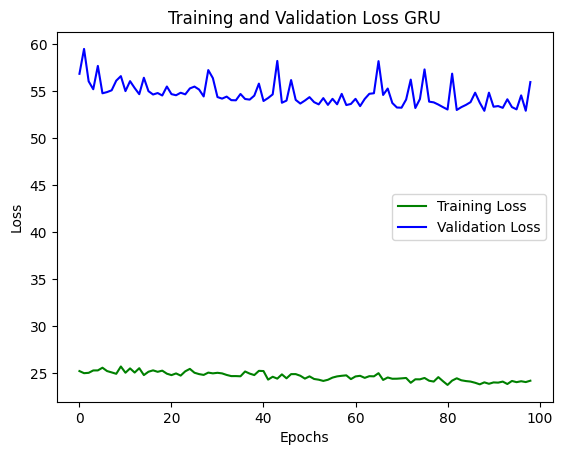

In [51]:
accuracy_train_LSTM = history_lstm.history['loss']
accuracy_val_LSTM = history_lstm.history['val_loss']
epochs = range(0, 99)

plt.plot(epochs, accuracy_train_LSTM, 'g', label='Training Loss')
plt.plot(epochs, accuracy_val_LSTM, 'b', label='Validation Loss')
plt.title('Training and Validation Loss GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() 


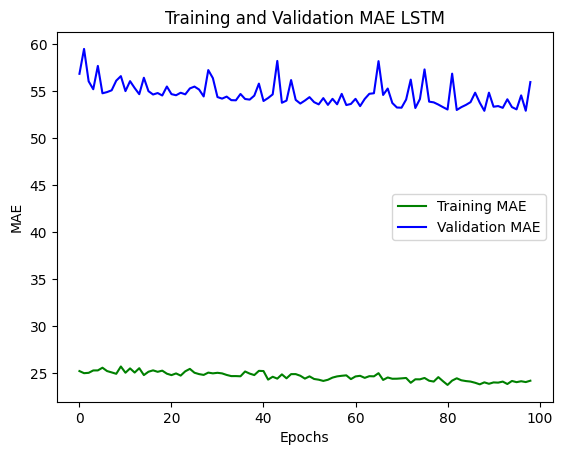

In [52]:
mae_train_LSTM = history_lstm.history['mae']
mae_val_LSTM = history_lstm.history['val_mae']
epochs = range(0,99)

plt.plot(epochs, mae_train_LSTM, 'g', label='Training MAE')
plt.plot(epochs, mae_val_LSTM, 'b', label='Validation MAE')
plt.title('Training and Validation MAE LSTM')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### 3. Plot time series

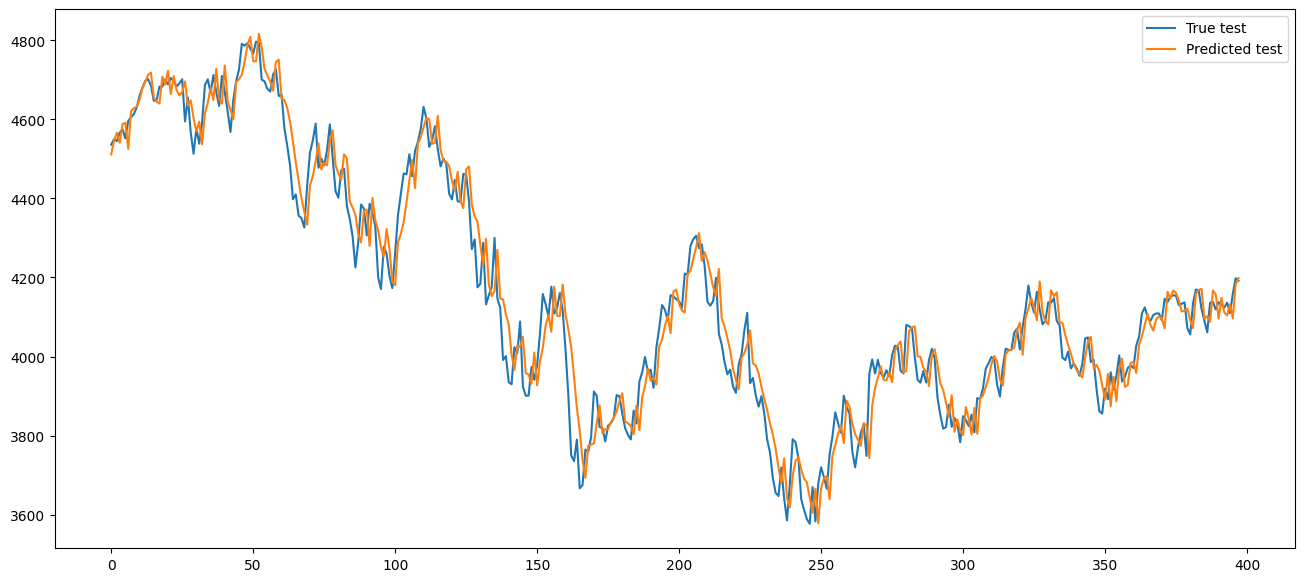

In [53]:
plt.figure(figsize=(16,7))

plt.plot(test_target, label='True test')
plt.plot(test_target_pred, label='Predicted test')


plt.legend()
plt.show()

In [54]:
mae_lstm_test = mean_absolute_error(test_target, test_target_pred)
print('Test MAE: %.3f' % mae_lstm_test)



Test MAE: 50.550


In [55]:
mae_lstm_train = mean_absolute_error(train_target, train_target_pred)
print('Train MAE: %.3f' % mae_lstm_train)




Train MAE: 22.324


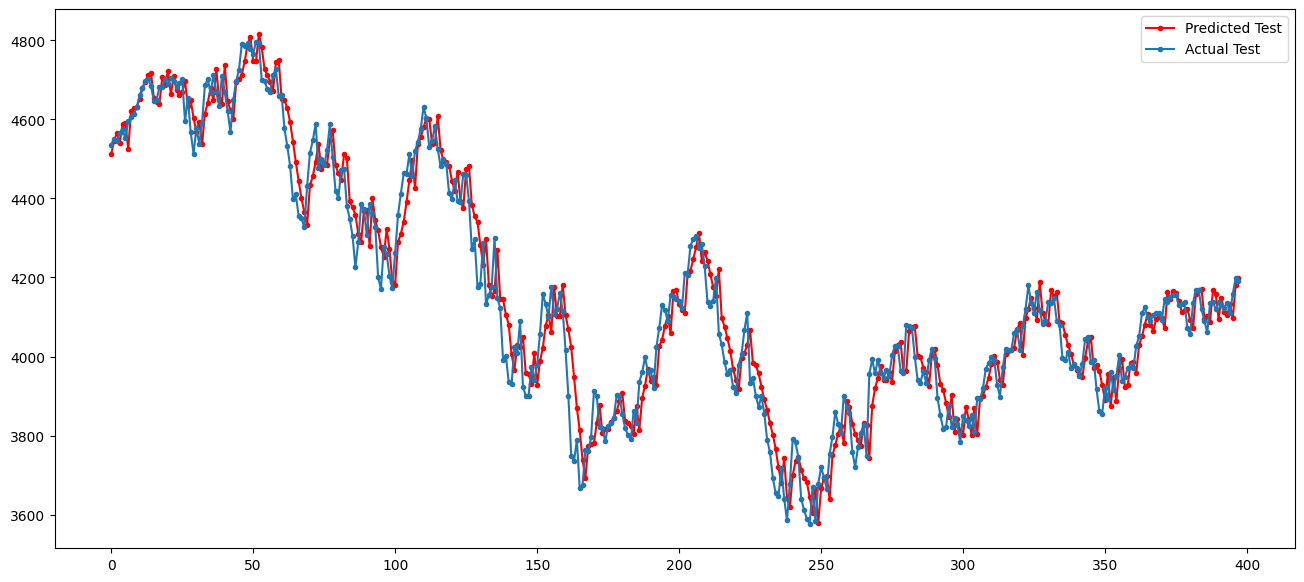

In [56]:
plt.figure(figsize=(16,7))

plt.plot(test_target_pred, 'r', marker='.', label='Predicted Test')

plt.plot(test_target, marker='.', label='Actual Test')

plt.legend()
plt.show()

## 4. Models Fitting

### 4.1. GRU

In [57]:
GRU_model = tf.keras.Sequential([
    layers.GRU(units=50, activation='relu', batch_input_shape=(4, 5, 1)),
    layers.Dense(1)
], name="GRU_model")
GRU_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='mean_absolute_error',
                    metrics=['mae'])


In [58]:
#history_gru = GRU_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),
                          #batch_size=4, epochs=150, callbacks=[early_stopping])

In [59]:
GRU_model.load_weights("./Modelfit/GRU")

In [60]:
lossGRU,maeGRU=GRU_model.evaluate(test_predictor_reshape,test_target)

13/13 [==============================] - 0s 1ms/step - loss: 51.4286 - mae: 51.4286


In [61]:
test_target_pred_gru = GRU_model.predict(test_predictor_reshape)
train_target_pred_gru=GRU_model.predict(train_predictor_reshape)

51/51 [==============================] - 0s 1ms/step


In [62]:
#loss_values_GRU = []
#for i in range(len(test_target)):
    #loss = GRU_model.evaluate(test_predictor_reshape[i:i+1], test_target[i:i+1], verbose=0)[0]
    #loss_values_GRU.append(loss)


In [63]:
#np.save('loss_values_GRU.npy', loss_values_GRU)


In [64]:
loss_values_GRU = np.load('loss_values_GRU.npy')


In [65]:
loss_values_GRU

array([ 31.21972656,  20.04541016,   3.27734375,  10.39306641,
         6.8125    ,  27.46533203,  20.78466797,  15.92626953,
         8.26953125,  13.27197266,  29.3984375 ,  27.54589844,
        23.72460938,   8.07080078,  21.59130859,  59.78710938,
        38.30712891,  11.13134766,   0.69873047,  10.83935547,
        13.24511719,   0.63818359,  13.81494141,  30.640625  ,
        16.62792969,   3.90917969, 115.52685547,  13.58837891,
        28.22949219, 115.41796875,  39.20458984,   4.05859375,
        24.31005859, 106.74267578,  66.96826172,  10.69482422,
        25.41259766,  36.54296875,  66.52978516,  33.5390625 ,
        21.65185547,  72.21337891,  99.42382812,  25.72021484,
        94.8671875 ,  56.14355469,  86.81835938,  33.35302734,
        10.453125  ,  19.3203125 ,  33.10253906,   4.46337891,
         5.22509766, 104.0078125 ,  72.14453125,  14.77685547,
        41.72363281,  17.01660156,  19.27783203,  64.83544922,
        42.81347656, 107.72900391, 114.74560547,  53.08

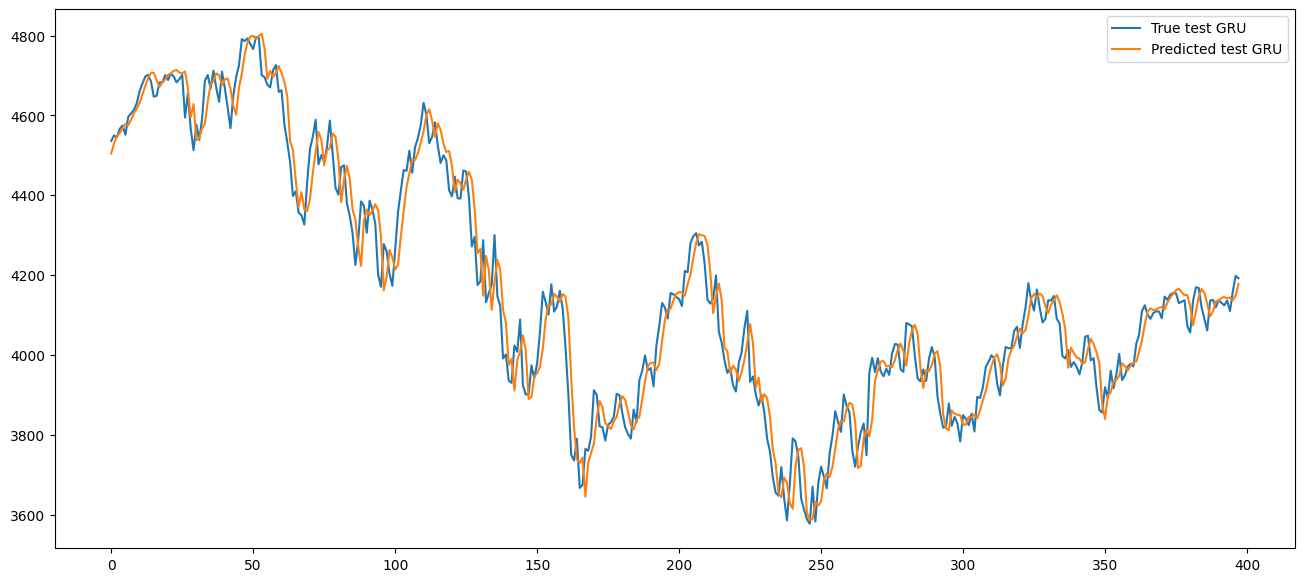

In [66]:
plt.figure(figsize=(16,7))

plt.plot(test_target, label='True test GRU')
plt.plot(test_target_pred_gru, label='Predicted test GRU')

plt.legend()
plt.show()

### 4.2. RNN

In [67]:
RNN_model = tf.keras.Sequential([
    layers.SimpleRNN(units=50, activation='relu', batch_input_shape=(4, 5, 1)),
    layers.Dense(1)
], name="RNN_model")
RNN_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='mean_absolute_error',
                    metrics=['mae'])

In [68]:

#history_RNN = RNN_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),
                          #batch_size=4, epochs=500, callbacks=[early_stopping])

In [69]:
RNN_model.load_weights("./Modelfit/RNN")

In [70]:
lossRNN,maeRNN=RNN_model.evaluate(test_predictor_reshape,test_target)

13/13 [==============================] - 0s 1ms/step - loss: 44.5153 - mae: 44.5153


In [71]:
test_target_pred_rnn = RNN_model.predict(test_predictor_reshape)
train_target_pred_rnn=RNN_model.predict(train_predictor_reshape)

51/51 [==============================] - 0s 1ms/step


In [72]:
#loss_values_RNN = []
#for i in range(len(test_target)):
    #loss = RNN_model.evaluate(test_predictor_reshape[i:i+1], test_target[i:i+1], verbose=0)[0]
    #loss_values_RNN.append(loss)


In [73]:
#np.save('loss_values_RNN.npy', loss_values_RNN)


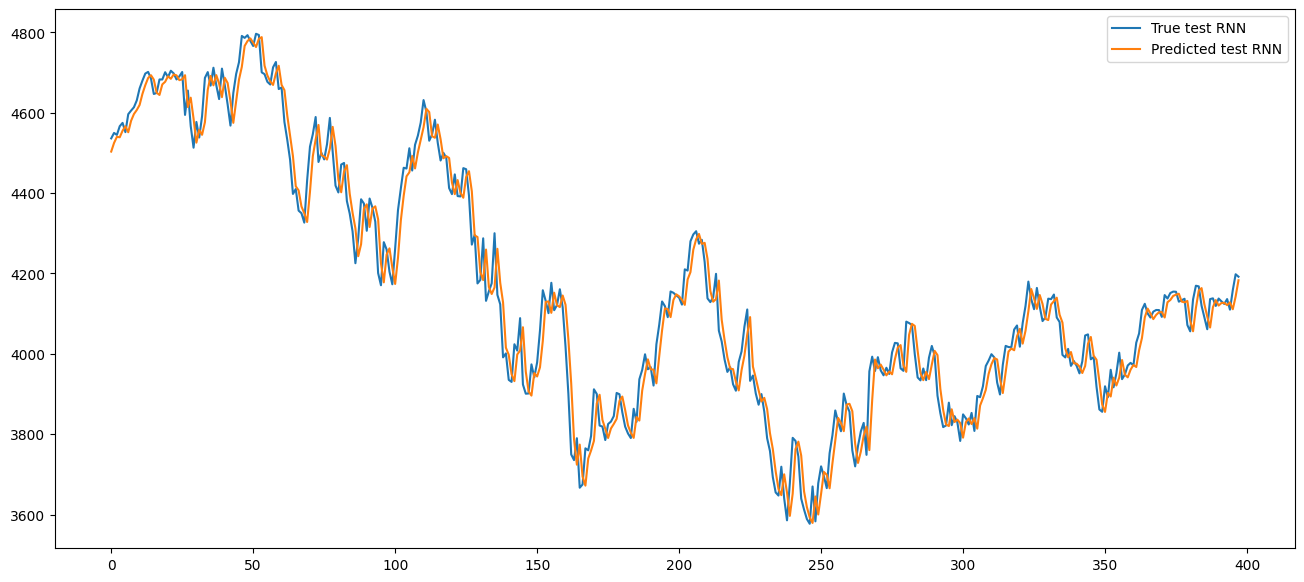

In [74]:
plt.figure(figsize=(16,7))

plt.plot(test_target, label='True test RNN')
plt.plot(test_target_pred_rnn, label='Predicted test RNN')

plt.legend()
plt.show()

In [75]:
loss_values_RNN = np.load('loss_values_RNN.npy')


In [76]:
loss_values_RNN

array([ 32.80664062,  24.94433594,   4.7734375 ,  27.48388672,
        19.57470703,  14.75146484,  44.95800781,  25.36425781,
        16.91552734,  23.84130859,  41.14160156,  33.02197266,
        28.92333984,  15.09716797,   8.19189453,  35.76318359,
         0.63232422,  38.54589844,  12.18408203,  23.77294922,
         2.18652344,  20.04931641,   2.78564453,  10.15625   ,
         9.56298828,  18.34375   ,  98.84619141,  41.13232422,
        70.58642578,  72.43261719,  51.47851562,  19.0234375 ,
        46.57080078, 110.34472656,  43.87402344,  24.23291016,
        43.78808594,  24.72998047,  38.57714844,  71.03955078,
        18.35058594,  53.3359375 ,  60.87060547,  74.3125    ,
        68.36230469,  43.29541016,  76.86132812,  19.96923828,
        14.61767578,   6.37207031,   8.24414062,  32.93798828,
         9.5703125 ,  87.61962891,  21.19775391,  15.96289062,
         7.71337891,  43.84912109,  28.35009766,  57.91650391,
         6.5       ,  79.23583984,  60.40039062,  59.06

### 4.3 BiLSTM

In [77]:
BiLSTM_model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(50, activation='relu', batch_input_shape=(4, 5, 1))),
    layers.Dense(1)
], name="BiLSTM_model")
BiLSTM_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='mean_absolute_error',
                    metrics=['mae'])



In [78]:
#history_BiLSTM = BiLSTM_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),
                          #batch_size=4, epochs=500, callbacks=[early_stopping])

In [79]:
BiLSTM_model.load_weights("./Modelfit/BiLSTM")

In [80]:
lossBiLSTM,maeBiLSTM=BiLSTM_model.evaluate(test_predictor_reshape,test_target)

13/13 [==============================] - 0s 1ms/step - loss: 57.7497 - mae: 57.7497


In [81]:
test_target_pred_BiLSTM = BiLSTM_model.predict(test_predictor_reshape)
train_target_pred_BiLSTM=BiLSTM_model.predict(train_predictor_reshape)

51/51 [==============================] - 0s 1ms/step


In [82]:
train_target_pred_BiLSTM

array([[1741.3447],
       [2116.336 ],
       [2116.2275],
       ...,
       [4364.7715],
       [4369.5874],
       [4379.8057]], dtype=float32)

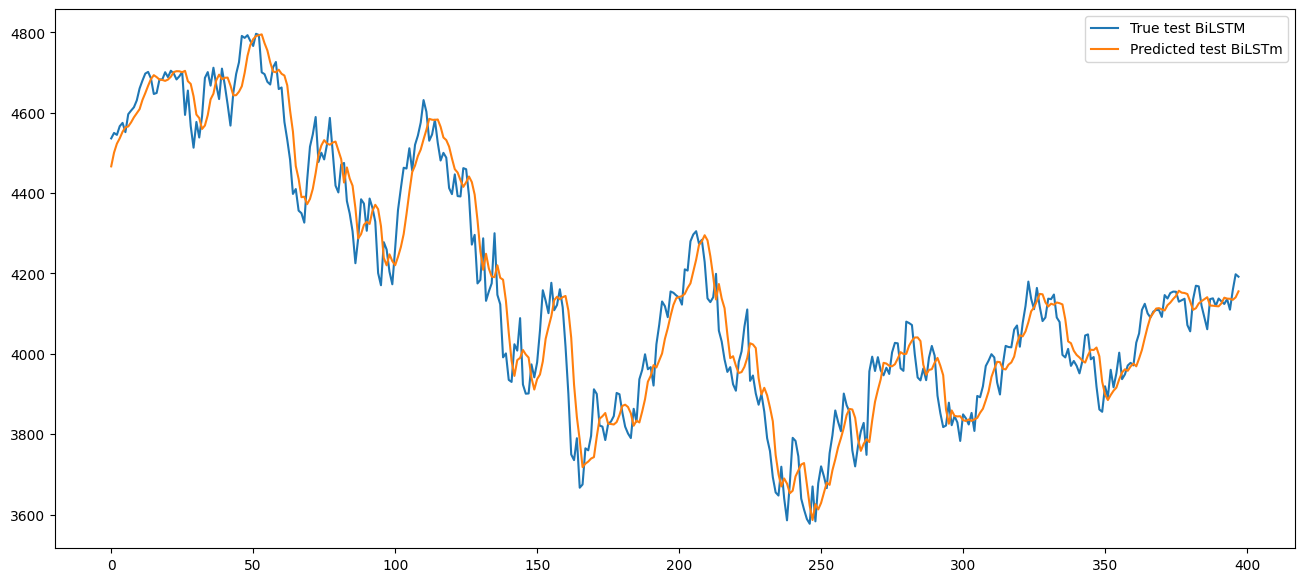

In [83]:
plt.figure(figsize=(16,7))

plt.plot(test_target, label='True test BiLSTM')
plt.plot(test_target_pred_BiLSTM, label='Predicted test BiLSTm')

plt.legend()
plt.show()

In [84]:
#loss_values_BiLSTM = []
#for i in range(len(test_target)):
    #loss = BiLSTM_model.evaluate(test_predictor_reshape[i:i+1], test_target[i:i+1], verbose=0)[0]
    #loss_values_BiLSTM.append(loss)


In [85]:
#np.save('loss_values_BiLSTM.npy', loss_values_BiLSTM)


In [86]:
# Load loss_values_BiLSTM from the saved file
loss_values_BiLSTM = np.load('loss_values_BiLSTM.npy')

In [87]:
loss_values_BiLSTM

array([ 69.60351562,  48.95751953,  21.91552734,  30.11083984,
        22.15429688,  12.01953125,  30.49707031,  29.25585938,
        24.98681641,  31.86914062,  51.54150391,  48.29589844,
        48.63720703,  34.47998047,   1.3125    ,  46.84375   ,
        39.47021484,   0.33349609,   1.15234375,  21.54980469,
         6.00244141,  14.96386719,   3.18212891,  20.55078125,
        12.51318359,   0.49609375, 109.70800781,  23.31152344,
       104.75195312, 127.97509766,  18.43457031,  48.41796875,
        32.01806641, 118.50244141, 107.12060547,  34.06201172,
        64.58007812,  11.83984375,  60.81298828,  26.26611328,
        18.40820312,  66.84912109,  99.79101562,   5.86425781,
        52.87353516,  73.33203125, 125.18847656,  86.9296875 ,
        51.53076172,   9.59667969,  16.93212891,   5.59130859,
         0.45263672,  94.49023438,  77.03564453,  78.07568359,
        55.37158203,  10.22363281,  25.63916016,  48.11865234,
        34.10302734, 115.50048828, 135.41601562, 122.39

### 4.4. ARIMA

In [88]:
train_predictor2 = train_data["x"]
train_target2=train_data["y"]
test_predictor2=test_data["x"]
test_target2=test_data["y"]

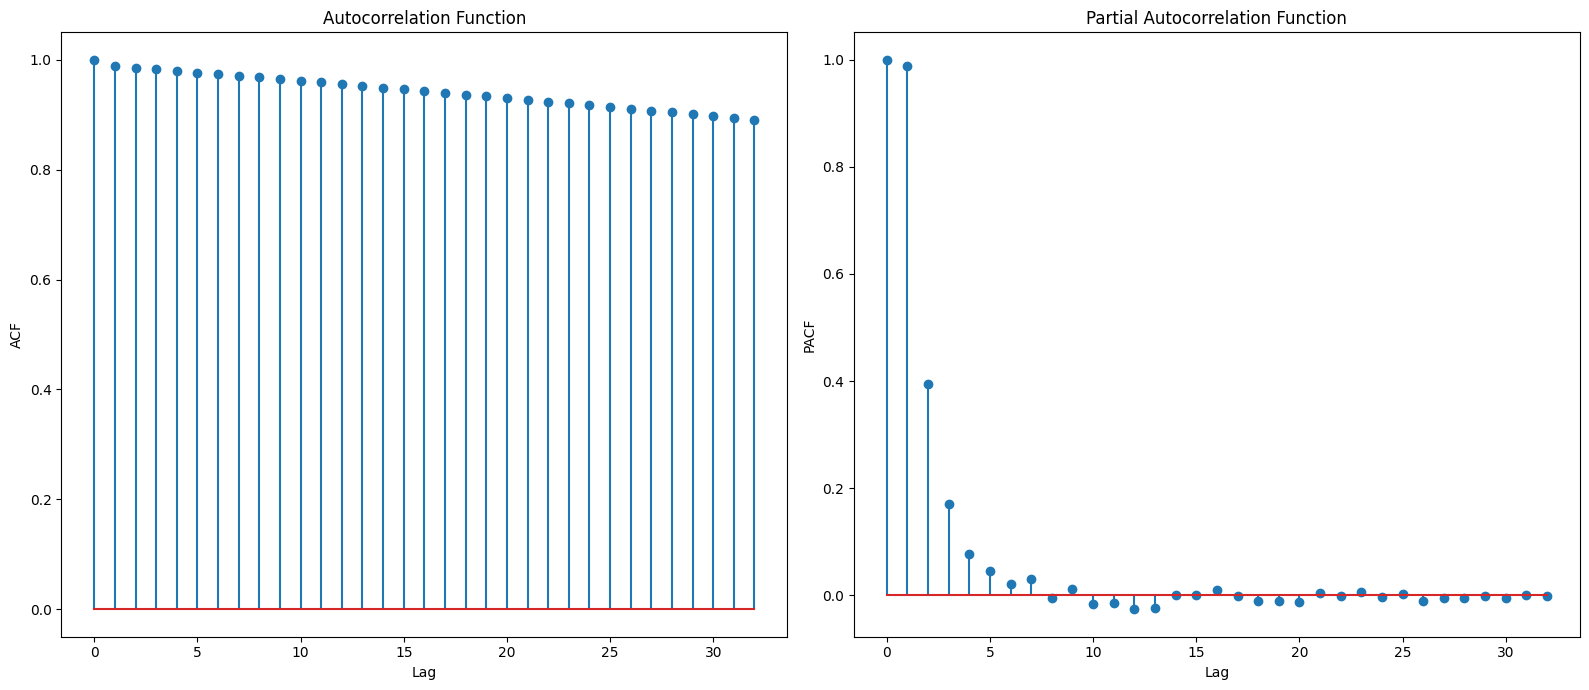

In [89]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Compute ACF and PACF
acf = sm.tsa.stattools.acf(train_predictor2)
pacf = sm.tsa.stattools.pacf(train_predictor2)

# Plot ACF
plt.figure(figsize=(16,7))

plt.subplot(1, 2, 1)
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(1, 2, 2)
plt.stem(pacf)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function')

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()


In [90]:
""" import pmdarima as pm

# Perform auto ARIMA
model = pm.auto_arima(train_predictor2, seasonal=False)

# Fit the model to the data
model.fit(train_predictor2)

# Get the model order
order = model.order

# Print the model order
print("ARIMA Order:", order) """



' import pmdarima as pm\n\n# Perform auto ARIMA\nmodel = pm.auto_arima(train_predictor2, seasonal=False)\n\n# Fit the model to the data\nmodel.fit(train_predictor2)\n\n# Get the model order\norder = model.order\n\n# Print the model order\nprint("ARIMA Order:", order) '

In [91]:
""" from statsmodels.tsa.stattools import adfuller
train_predictor2_diff = train_predictor2.diff().dropna()

# Perform ADF test
result = adfuller(train_predictor2_diff)

# Extract and print the test statistics and p-value
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

# Interpret the results
if p_value < 0.05:
    print("The time series is stationary (reject the null hypothesis)")
else:
    print("The time series is non-stationary (fail to reject the null hypothesis)") """


' from statsmodels.tsa.stattools import adfuller\ntrain_predictor2_diff = train_predictor2.diff().dropna()\n\n# Perform ADF test\nresult = adfuller(train_predictor2_diff)\n\n# Extract and print the test statistics and p-value\nadf_statistic = result[0]\np_value = result[1]\nprint("ADF Statistic:", adf_statistic)\nprint("p-value:", p_value)\n\n# Interpret the results\nif p_value < 0.05:\n    print("The time series is stationary (reject the null hypothesis)")\nelse:\n    print("The time series is non-stationary (fail to reject the null hypothesis)") '

In [92]:
""" 
# Define the ARIMA order (p, d, q)
p = 2  # Autoregressive order
d = 1  # Degree of differencing
q = 2 # Moving average order

# Create and fit the ARIMA model
model = ARIMA(train_predictor2, order=(p, d, q))
model_fit = model.fit()

# Generate predictions on the training data
train_predictions_ARIMA = model_fit.predict()

# Generate predictions on the test data
test_predictions_ARIMA = model_fit.predict(start=len(train_target2), end=len(train_target2) + len(test_target2) - 1)

# Print the model summary
print(model_fit.summary()) """


' \n# Define the ARIMA order (p, d, q)\np = 2  # Autoregressive order\nd = 1  # Degree of differencing\nq = 2 # Moving average order\n\n# Create and fit the ARIMA model\nmodel = ARIMA(train_predictor2, order=(p, d, q))\nmodel_fit = model.fit()\n\n# Generate predictions on the training data\ntrain_predictions_ARIMA = model_fit.predict()\n\n# Generate predictions on the test data\ntest_predictions_ARIMA = model_fit.predict(start=len(train_target2), end=len(train_target2) + len(test_target2) - 1)\n\n# Print the model summary\nprint(model_fit.summary()) '

In [93]:
#loss_values_ARIMA=[]
#loss_values_ARIMA= np.abs(test_predictions_ARIMA.values - test_target2.values)


In [94]:
#np.save('loss_values_ARIMA.npy', loss_values_ARIMA)


In [95]:
# Load loss_values_BiLSTM from the saved file
loss_values_ARIMA = np.load('loss_values_ARIMA.npy')

In [96]:
loss_values_ARIMA.shape

(403,)

In [97]:
maeARIMA=np.mean(loss_values_ARIMA)

In [98]:
maeARIMA

315.7567903281135

### Model performance

In [99]:
print("MAE of ARIMA on test set: ", maeARIMA)
print("MAE of RNN on test set: ", maeRNN)
print("MAE of LSTM on test set: ", maeLSTM)
print("MAE of BiBLSTM on test set: ", maeBiLSTM)
print("MAE of GRU on test set: ", maeGRU)



MAE of ARIMA on test set:  315.7567903281135
MAE of RNN on test set:  44.51530075073242
MAE of LSTM on test set:  50.550148010253906
MAE of BiBLSTM on test set:  57.74971008300781
MAE of GRU on test set:  51.42856216430664


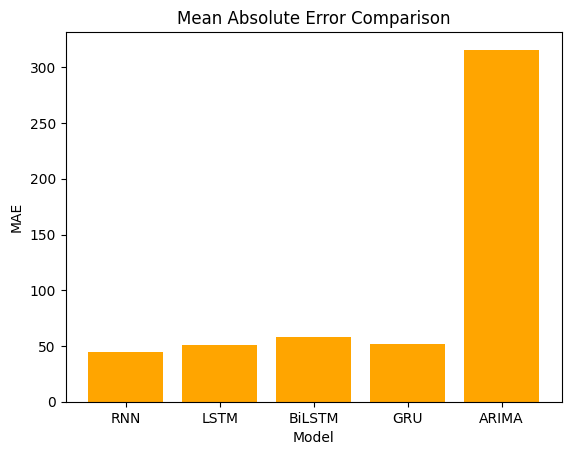

In [100]:

# Define the model names and their respective MAE values
model_names = ['RNN', 'LSTM', 'BiLSTM', 'GRU','ARIMA']
mae_values = [maeRNN, maeLSTM, maeBiLSTM, maeGRU,maeARIMA]

# Create the bar plot with orange color
plt.bar(model_names, mae_values, color='orange')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Mean Absolute Error Comparison')
plt.show()


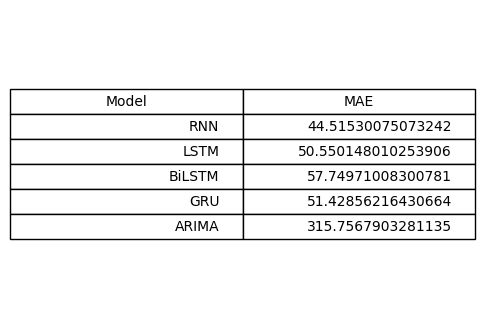

In [101]:

# Create the table of values
table_values = [[model_names[i], mae_values[i]] for i in range(len(model_names))]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Hide the axis
ax.axis('off')

# Create the table
table = ax.table(cellText=table_values, colLabels=['Model', 'MAE'], loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.show()


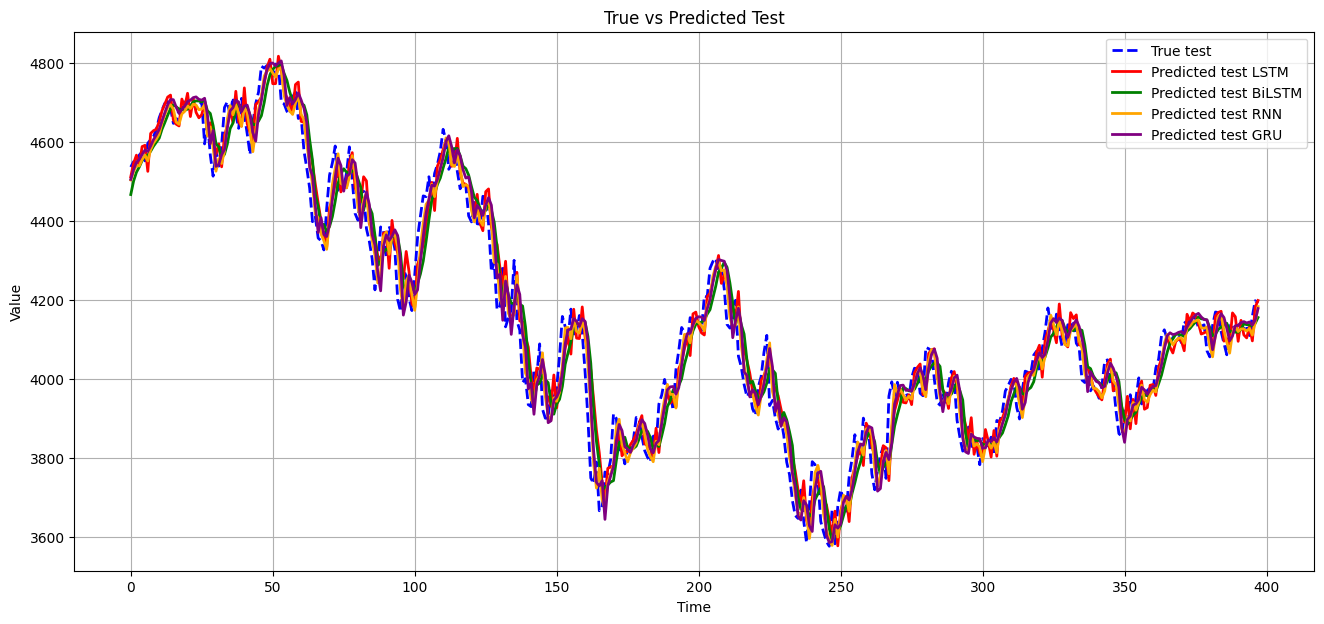

In [102]:

plt.figure(figsize=(16,7))

# Plot the lines with different colors and line styles
plt.plot(test_target, label='True test', color='blue', linestyle='--', linewidth=2)
plt.plot(test_target_pred, label='Predicted test LSTM', color='red', linestyle='-', linewidth=2)
plt.plot(test_target_pred_BiLSTM, label='Predicted test BiLSTM', color='green', linestyle='-', linewidth=2)
plt.plot(test_target_pred_rnn, label='Predicted test RNN', color='orange', linestyle='-', linewidth=2)
plt.plot(test_target_pred_gru, label='Predicted test GRU', color='purple', linestyle='-', linewidth=2)
#plt.plot(test_predictions, label='Predicted test ARIMA', color='yellow', linestyle='-', linewidth=2)


plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True vs Predicted Test')
plt.legend()
plt.grid(True)
plt.show()


## 5.1  GW test with $h_{t}=1$

### GW test between GRU and LSTM

In [103]:
time_step=1
m = 5 #m:window size
T= len(test_predictor)
n= T-m-time_step+1


In [104]:
Z_m_fixedGRUvsLSTM=loss_values_GRU-loss_values_LSTM

In [105]:
n

393

In [106]:
Z_m_fixedGRUvsLSTM.shape

(398,)

In [107]:
loss_values_GRU.shape

(398,)

In [108]:
test_target_pred_gru.shape

(398, 1)

In [109]:
Z_m_fixed_barGRUvsLSTM=1/n *sum(Z_m_fixedGRUvsLSTM)

In [110]:
omega= 1/n * sum(Z_m_fixedGRUvsLSTM*Z_m_fixedGRUvsLSTM)

In [111]:
omega

1109.6731377476044

In [112]:
teststatGRUvsLSTM=n*Z_m_fixed_barGRUvsLSTM*1/omega*Z_m_fixed_barGRUvsLSTM

compute p_value

In [113]:

# Degrees of freedom
df = 1

# Compute the chi-square test statistic (test_stat) value

# Compute the p-value
p_valueGRUvsLSTM = 1 - chi2.cdf(teststatGRUvsLSTM, df)

# Print the p-value
print("p-value btw GRU and LSTM:", p_valueGRUvsLSTM)


p-value btw GRU and LSTM: 0.5965429862251359


### GW test between GRU and BiLSTM

In [114]:
Z_m_fixedGRUvsBiLSTM=loss_values_GRU-loss_values_BiLSTM
Z_m_fixed_barGRUvsBiLSTM=1/n *sum(Z_m_fixedGRUvsBiLSTM)
omegaGRUvsBiLSTM= 1/n * sum(Z_m_fixedGRUvsBiLSTM*Z_m_fixedGRUvsBiLSTM)
teststatGRUvsBiLSTM=n*Z_m_fixed_barGRUvsBiLSTM*1/omegaGRUvsBiLSTM*Z_m_fixed_barGRUvsBiLSTM
# Compute the p-value
p_valueGRUvsBiLSTM = 1 - chi2.cdf(teststatGRUvsBiLSTM, df)

# Print the p-value
print("p-value bwt GRU and BiLSTM:", p_valueGRUvsBiLSTM)


p-value bwt GRU and BiLSTM: 1.258341658283424e-05


### GW test between GRU and RNN

In [115]:
Z_m_fixedGRUvsRNN=loss_values_GRU-loss_values_RNN
Z_m_fixed_barGRUvsRNN=1/n *sum(Z_m_fixedGRUvsRNN)
omegaGRUvsRNN= 1/n * sum(Z_m_fixedGRUvsRNN*Z_m_fixedGRUvsRNN)
teststatGRUvsRNN=n*Z_m_fixed_barGRUvsRNN*1/omegaGRUvsRNN*Z_m_fixed_barGRUvsRNN
# Compute the p-value
p_valueGRUvsRNN = 1 - chi2.cdf(teststatGRUvsRNN, df)

# Print the p-value
print("p-value bwt GRU and LSTM:", p_valueGRUvsRNN)


p-value bwt GRU and LSTM: 3.91768140151072e-09


### GW test between LSTM and RNN

In [116]:
Z_m_fixedLSTMvsRNN=loss_values_LSTM-loss_values_RNN
Z_m_fixed_barLSTMvsRNN=1/n *sum(Z_m_fixedLSTMvsRNN)
omegaLSTMvsRNN= 1/n * sum(Z_m_fixedLSTMvsRNN*Z_m_fixedLSTMvsRNN)
teststatLSTMvsRNN=n*Z_m_fixed_barLSTMvsRNN*1/omega*Z_m_fixed_barLSTMvsRNN

In [117]:

# Compute the p-value
p_valueLSTMvsRNN = 1 - chi2.cdf(teststatLSTMvsRNN, df)

# Print the p-value
print("p-value bwt LSTM and RNN:", p_valueLSTMvsRNN)


p-value bwt LSTM and RNN: 0.0002757413072185244


### GW test between BiLSTM and RNN

In [118]:
Z_m_fixedBiLSTMvsRNN=np.array(loss_values_BiLSTM)-np.array(loss_values_RNN)
Z_m_fixed_barBiLSTMvsRNN=1/n *sum(Z_m_fixedBiLSTMvsRNN)
omegaBiLSTMvsRNN= 1/n * sum(Z_m_fixedBiLSTMvsRNN*Z_m_fixedBiLSTMvsRNN)
teststatBiLSTMvsRNN=n*Z_m_fixed_barBiLSTMvsRNN*1/omegaBiLSTMvsRNN*Z_m_fixed_barBiLSTMvsRNN
# Compute the p-value
p_valueBiLSTMvsRNN = 1 - chi2.cdf(teststatBiLSTMvsRNN, df)

# Print the p-value
print("p-value bwt BiLSTM vs RNN:", p_valueBiLSTMvsRNN)


p-value bwt BiLSTM vs RNN: 6.504796701278792e-13


### GW test between BiLSTM and LSTM

In [119]:
Z_m_fixedBiLSTMvsLSTM=np.array(loss_values_BiLSTM)-np.array(loss_values_LSTM)
Z_m_fixed_barBiLSTMvsLSTM=1/n *sum(Z_m_fixedBiLSTMvsLSTM)
omegaBiLSTMvsLSTM= 1/n * sum(Z_m_fixedBiLSTMvsLSTM*Z_m_fixedBiLSTMvsLSTM)
teststatBiLSTMvsLSTM=n*Z_m_fixed_barBiLSTMvsLSTM*1/omegaBiLSTMvsLSTM*Z_m_fixed_barBiLSTMvsLSTM
# Compute the p-value
p_valueBiLSTMvsLSTM = 1 - chi2.cdf(teststatBiLSTMvsLSTM, df)

# Print the p-value
print("p-value bwt BiLSTM vs LSTM:", p_valueBiLSTMvsLSTM)


p-value bwt BiLSTM vs LSTM: 1.0270831020897653e-05


In [120]:
from tabulate import tabulate

# Create a list of lists representing the table rows
table = [
    ['GRU vs LSTM', p_valueGRUvsLSTM],
    ['GRU vs BiLSTM', p_valueGRUvsBiLSTM],
    ['GRU vs RNN', p_valueGRUvsRNN],
    ['LSTM vs RNN', p_valueLSTMvsRNN],
    ['BiLSTM vs RNN', p_valueBiLSTMvsRNN],
    ['BiLSTM vs LSTM', p_valueBiLSTMvsLSTM]
]

# Set the table headers
headers = ['Comparison', 'p-value']

# Generate the table in a formatted string
table_str = tabulate(table, headers, tablefmt='grid')

# Print the table
print(table_str)

+----------------+-------------+
| Comparison     |     p-value |
+================+=============+
| GRU vs LSTM    | 0.596543    |
+----------------+-------------+
| GRU vs BiLSTM  | 1.25834e-05 |
+----------------+-------------+
| GRU vs RNN     | 3.91768e-09 |
+----------------+-------------+
| LSTM vs RNN    | 0.000275741 |
+----------------+-------------+
| BiLSTM vs RNN  | 6.5048e-13  |
+----------------+-------------+
| BiLSTM vs LSTM | 1.02708e-05 |
+----------------+-------------+


### 5.2  Gw test with business cycle indicator test function

In [121]:
import pandas_datareader as pdr

In [122]:
start_date = datetime.datetime(2021, 9 , 21)
end_date = datetime.datetime(2023, 6, 22)

interest_rate_data = pdr.data.DataReader('FEDFUNDS', 'fred', start_date, end_date)


In [123]:
interest_rate_data

,FEDFUNDS
DATE,
2021-10-01,0.08
2021-11-01,0.08
2021-12-01,0.08
2022-01-01,0.08
2022-02-01,0.08
2022-03-01,0.20
2022-04-01,0.33
2022-05-01,0.77
2022-06-01,1.21


In [124]:
interest_rate_data.shape

(21, 1)

In [125]:
interest_rate_data

,FEDFUNDS
DATE,
2021-10-01,0.08
2021-11-01,0.08
2021-12-01,0.08
2022-01-01,0.08
2022-02-01,0.08
2022-03-01,0.20
2022-04-01,0.33
2022-05-01,0.77
2022-06-01,1.21


In [126]:
daily_interest_rate_data = interest_rate_data.resample('D').ffill()


In [127]:
daily_interest_rate_data

,FEDFUNDS
DATE,
2021-10-01,0.08
2021-10-02,0.08
2021-10-03,0.08
2021-10-04,0.08
2021-10-05,0.08
...,...
2023-05-28,5.06
2023-05-29,5.06
2023-05-30,5.06


In [128]:
start_date1 = '2021-10-20'
end_date1 = '2023-05-21'
selected_date_range = daily_interest_rate_data.loc[start_date1:end_date1]


In [129]:
selected_date_range

,FEDFUNDS
DATE,
2021-10-20,0.08
2021-10-21,0.08
2021-10-22,0.08
2021-10-23,0.08
2021-10-24,0.08
...,...
2023-05-17,5.06
2023-05-18,5.06
2023-05-19,5.06


In [130]:
selected_date_range.shape

(579, 1)

In [131]:
test_target.shape

(398,)

In [132]:
previous_day_index =test_data.index - pd.DateOffset(days=1)

In [133]:
previous_day_index

DatetimeIndex(['2021-10-13', '2021-10-14', '2021-10-17', '2021-10-18',
               '2021-10-19', '2021-10-20', '2021-10-21', '2021-10-24',
               '2021-10-25', '2021-10-26',
               ...
               '2023-05-08', '2023-05-09', '2023-05-10', '2023-05-11',
               '2023-05-14', '2023-05-15', '2023-05-16', '2023-05-17',
               '2023-05-18', '2023-05-21'],
              dtype='datetime64[ns]', name='Date', length=403, freq=None)

In [134]:
test_data.index

DatetimeIndex(['2021-10-14', '2021-10-15', '2021-10-18', '2021-10-19',
               '2021-10-20', '2021-10-21', '2021-10-22', '2021-10-25',
               '2021-10-26', '2021-10-27',
               ...
               '2023-05-09', '2023-05-10', '2023-05-11', '2023-05-12',
               '2023-05-15', '2023-05-16', '2023-05-17', '2023-05-18',
               '2023-05-19', '2023-05-22'],
              dtype='datetime64[ns]', name='Date', length=403, freq=None)

In [135]:
selected_date_range_vector = daily_interest_rate_data.loc[previous_day_index]


In [136]:
selected_date_range_vector

,FEDFUNDS
Date,
2021-10-13,0.08
2021-10-14,0.08
2021-10-17,0.08
2021-10-18,0.08
2021-10-19,0.08
...,...
2023-05-15,5.06
2023-05-16,5.06
2023-05-17,5.06


In [137]:
h_t_indicator=selected_date_range_vector.loc[start_date1:end_date1]

In [138]:
h_t_indicator.shape

(398, 1)

In [139]:
h_t_indicator

,FEDFUNDS
Date,
2021-10-20,0.08
2021-10-21,0.08
2021-10-24,0.08
2021-10-25,0.08
2021-10-26,0.08
...,...
2023-05-15,5.06
2023-05-16,5.06
2023-05-17,5.06


### 5.3 GW test between GRU and BiLSTM

In [140]:
DeltaGRUvsBiLSTM=(loss_values_GRU-loss_values_BiLSTM)

In [141]:
h_t_indicator.shape

(398, 1)

In [142]:
h_t_indicator_1x398 = h_t_indicator.T

In [143]:
Z_m_fixedGRUvsBiLSTM_interestrate=h_t_indicator_1x398*(DeltaGRUvsBiLSTM)


In [144]:
Z_m_fixedGRUvsBiLSTM_interestrate


Date,2021-10-20,2021-10-21,2021-10-24,2021-10-25,2021-10-26,2021-10-27,2021-10-28,2021-10-31,2021-11-01,2021-11-02,...,2023-05-08,2023-05-09,2023-05-10,2023-05-11,2023-05-14,2023-05-15,2023-05-16,2023-05-17,2023-05-18,2023-05-21
FEDFUNDS,-3.070703,-2.312969,-1.491055,-1.577422,-1.227344,1.235664,-0.776992,-1.066367,-1.337383,-1.487773,...,55.442578,76.260723,-90.541387,35.899316,27.879414,21.391348,36.998779,-9.843281,-40.665303,-114.462734


In [145]:
Z_m_fixedGRUvsBiLSTM_interestrate.sum().sum()

-4077.574143066406

In [146]:
Z_m_fixedGRUvsBiLSTM_bar_interestrate=1/n *Z_m_fixedGRUvsBiLSTM_interestrate.sum().sum()

In [147]:
Z_m_fixedGRUvsBiLSTM_bar_interestrate

-10.375506725359813

In [148]:
Z_m_fixedGRUvsBiLSTM_interestrate*Z_m_fixedGRUvsBiLSTM_interestrate

Date,2021-10-20,2021-10-21,2021-10-24,2021-10-25,2021-10-26,2021-10-27,2021-10-28,2021-10-31,2021-11-01,2021-11-02,...,2023-05-08,2023-05-09,2023-05-10,2023-05-11,2023-05-14,2023-05-15,2023-05-16,2023-05-17,2023-05-18,2023-05-21
FEDFUNDS,9.429218,5.349824,2.223244,2.48826,1.506373,1.526866,0.603717,1.137139,1.788593,2.21347,...,3073.879469,5815.69782,8197.742709,1288.760918,777.261728,457.589755,1368.909669,96.890186,1653.666846,13101.717561


In [149]:
omegaGRUvsBiLSTM_interestrate= 1/n * (Z_m_fixedGRUvsBiLSTM_interestrate*Z_m_fixedGRUvsBiLSTM_interestrate).sum().sum()


In [150]:
teststatBiLSTMvsGRU_interestrate5=n*Z_m_fixedGRUvsBiLSTM_bar_interestrate*1/omegaGRUvsBiLSTM_interestrate*Z_m_fixedGRUvsBiLSTM_bar_interestrate


In [151]:
# Compute the p-value
p_valueBiLSTMvsGRU_interestrate= 1 - chi2.cdf(teststatBiLSTMvsGRU_interestrate5, 1)

# Print the p-value
print("p-value bwt GRU vs BiLSTM under business cycle indicator:", p_valueBiLSTMvsGRU_interestrate)

p-value bwt GRU vs BiLSTM under business cycle indicator: 0.0024563532336938643


### GW test between GRU and LSTM

In [152]:
DeltaGRUvsLSTM=(loss_values_GRU-loss_values_LSTM)
Z_m_fixedGRUvsLSTM_interestrate=h_t_indicator_1x398*(DeltaGRUvsLSTM)
Z_m_fixedGRUvsLSTM_bar_interestrate=1/n *Z_m_fixedGRUvsLSTM_interestrate.sum().sum()
omegaGRUvsLSTM_interestrate= 1/n * (Z_m_fixedGRUvsLSTM_interestrate*Z_m_fixedGRUvsLSTM_interestrate).sum().sum()
teststatLSTMvsGRU_interestrate5=n*Z_m_fixedGRUvsLSTM_bar_interestrate*1/omegaGRUvsLSTM_interestrate*Z_m_fixedGRUvsLSTM_bar_interestrate
# Compute the p-value
p_valueLSTMvsGRU_interestrate= 1 - chi2.cdf(teststatLSTMvsGRU_interestrate5, 1)
# Print the p-value
print("p-value bwt GRU vs LSTM under business cycle indicator:", p_valueLSTMvsGRU_interestrate)

p-value bwt GRU vs LSTM under business cycle indicator: 0.47996440990973555


### GW test between GRU and RNN

In [153]:
DeltaGRUvsRNN=(loss_values_GRU-loss_values_RNN)
Z_m_fixedGRUvsRNN_interestrate=h_t_indicator_1x398*(DeltaGRUvsRNN)
Z_m_fixedGRUvsRNN_bar_interestrate=1/n *Z_m_fixedGRUvsRNN_interestrate.sum().sum()
omegaGRUvsRNN_interestrate= 1/n * (Z_m_fixedGRUvsRNN_interestrate*Z_m_fixedGRUvsRNN_interestrate).sum().sum()
teststatRNNvsGRU_interestrate5=n*Z_m_fixedGRUvsRNN_bar_interestrate*1/omegaGRUvsRNN_interestrate*Z_m_fixedGRUvsRNN_bar_interestrate
# Compute the p-value
p_valueRNNvsGRU_interestrate= 1 - chi2.cdf(teststatRNNvsGRU_interestrate5, 1)
# Print the p-value
print("p-value bwt GRU vs RNN under business cycle indicator:", p_valueRNNvsGRU_interestrate)

p-value bwt GRU vs RNN under business cycle indicator: 9.326057500480545e-06


### GW test between LSTM and RNN

In [154]:
DeltaLSTMvsRNN=(loss_values_LSTM-loss_values_RNN)
Z_m_fixedLSTMvsRNN_interestrate=h_t_indicator_1x398*(DeltaLSTMvsRNN)
Z_m_fixedLSTMvsRNN_bar_interestrate=1/n *Z_m_fixedLSTMvsRNN_interestrate.sum().sum()
omegaLSTMvsRNN_interestrate= 1/n * (Z_m_fixedLSTMvsRNN_interestrate*Z_m_fixedLSTMvsRNN_interestrate).sum().sum()
teststatRNNvsLSTM_interestrate5=n*Z_m_fixedLSTMvsRNN_bar_interestrate*1/omegaLSTMvsRNN_interestrate*Z_m_fixedLSTMvsRNN_bar_interestrate
# Compute the p-value
p_valueRNNvsLSTM_interestrate= 1 - chi2.cdf(teststatRNNvsLSTM_interestrate5, 1)
# Print the p-value
print("p-value bwt LSTM vs RNN under business cycle indicator:", p_valueRNNvsLSTM_interestrate)

p-value bwt LSTM vs RNN under business cycle indicator: 0.0025092262857253633


### GW test between BiLSTM and RNN

In [155]:
DeltaBiLSTMvsRNN=(loss_values_BiLSTM-loss_values_RNN)
Z_m_fixedBiLSTMvsRNN_interestrate=h_t_indicator_1x398*(DeltaBiLSTMvsRNN)
Z_m_fixedBiLSTMvsRNN_bar_interestrate=1/n *Z_m_fixedBiLSTMvsRNN_interestrate.sum().sum()
omegaBiLSTMvsRNN_interestrate= 1/n * (Z_m_fixedBiLSTMvsRNN_interestrate*Z_m_fixedBiLSTMvsRNN_interestrate).sum().sum()
teststatRNNvsBiLSTM_interestrate5=n*Z_m_fixedBiLSTMvsRNN_bar_interestrate*1/omegaBiLSTMvsRNN_interestrate*Z_m_fixedBiLSTMvsRNN_bar_interestrate
# Compute the p-value
p_valueRNNvsBiLSTM_interestrate= 1 - chi2.cdf(teststatRNNvsBiLSTM_interestrate5, 1)
# Print the p-value
print("p-value bwt BiLSTM vs RNN under business cycle indicator:", p_valueRNNvsBiLSTM_interestrate)

p-value bwt BiLSTM vs RNN under business cycle indicator: 1.1378183684129795e-07


### GW test between BiLSTM and LSTM

In [156]:
DeltaBiLSTMvsLSTM=(loss_values_BiLSTM-loss_values_LSTM)
Z_m_fixedBiLSTMvsLSTM_interestrate=h_t_indicator_1x398*(DeltaBiLSTMvsLSTM)
Z_m_fixedBiLSTMvsLSTM_bar_interestrate=1/n *Z_m_fixedBiLSTMvsLSTM_interestrate.sum().sum()
omegaBiLSTMvsLSTM_interestrate= 1/n * (Z_m_fixedBiLSTMvsLSTM_interestrate*Z_m_fixedBiLSTMvsLSTM_interestrate).sum().sum()
teststatLSTMvsBiLSTM_interestrate5=n*Z_m_fixedBiLSTMvsLSTM_bar_interestrate*1/omegaBiLSTMvsLSTM_interestrate*Z_m_fixedBiLSTMvsLSTM_bar_interestrate
# Compute the p-value
p_valueLSTMvsBiLSTM_interestrate= 1 - chi2.cdf(teststatLSTMvsBiLSTM_interestrate5, 1)
# Print the p-value
print("p-value bwt BiLSTM vs LSTM under business cycle indicator:", p_valueLSTMvsBiLSTM_interestrate)

p-value bwt BiLSTM vs LSTM under business cycle indicator: 0.0031631421939083415


In [157]:
from tabulate import tabulate

# Create a list of lists representing the table rows
table = [
    ['GRU vs LSTM', p_valueLSTMvsGRU_interestrate],
    ['GRU vs BiLSTM', p_valueBiLSTMvsGRU_interestrate],
    ['GRU vs RNN', p_valueRNNvsGRU_interestrate],
    ['LSTM vs RNN', p_valueRNNvsLSTM_interestrate],
    ['BiLSTM vs RNN', p_valueRNNvsBiLSTM_interestrate],
    ['BiLSTM vs LSTM', p_valueLSTMvsBiLSTM_interestrate]
]

# Set the table headers
headers = ['Comparison', 'p-value']

# Generate the table in a formatted string
table_str = tabulate(table, headers, tablefmt='grid')

# Print the table
print(table_str)

+----------------+-------------+
| Comparison     |     p-value |
+================+=============+
| GRU vs LSTM    | 0.479964    |
+----------------+-------------+
| GRU vs BiLSTM  | 0.00245635  |
+----------------+-------------+
| GRU vs RNN     | 9.32606e-06 |
+----------------+-------------+
| LSTM vs RNN    | 0.00250923  |
+----------------+-------------+
| BiLSTM vs RNN  | 1.13782e-07 |
+----------------+-------------+
| BiLSTM vs LSTM | 0.00316314  |
+----------------+-------------+


### 5.4 Gw test with $h_{t}=\Delta L_{m,t}$ with 0 as the first value of loss difference


### LSTM vs GRU

In [158]:
h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM-loss_values_GRU

h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)
h_t_lossdifferenceLSTMvsGRU=h_t_lossdifferenceLSTMvsGRU.reshape(1, -1)
Z_m_fixed_LSTMvsGRU3=h_t_lossdifferenceLSTMvsGRU[:, :-1]*(loss_values_LSTM-loss_values_GRU)
Z_m_fixed_bar_LSTMvsGRU3=1/n *Z_m_fixed_LSTMvsGRU3.sum()
omegaLSTMvsGRU3= 1/n * (Z_m_fixed_LSTMvsGRU3*Z_m_fixed_LSTMvsGRU3).sum()
teststatLSTMvsGRU3=n*Z_m_fixed_bar_LSTMvsGRU3*1/omegaLSTMvsGRU3*Z_m_fixed_bar_LSTMvsGRU3
# Compute the p-value
p_valueLSTMvsGRU3_lossdifference= 1 - chi2.cdf(teststatLSTMvsGRU3, 1)

# Print the p-value
print("p-value bwt LSTM vs GRU:", p_valueLSTMvsGRU3_lossdifference)


p-value bwt LSTM vs GRU: 0.7841156493011219


In [159]:
h_t_lossdifferenceLSTMvsGRU[:, :-1]

array([[ 0.00000000e+00, -6.51708984e+00, -1.60795898e+01,
         1.79824219e+01,  1.53081055e+01,  6.24609375e+00,
         1.19760742e+01,  5.04077148e+01, -6.39648438e-02,
         6.20166016e+00, -1.19702148e+01, -1.92714844e+01,
        -2.59555664e+01, -2.15454102e+01,  3.39355469e+00,
         1.12861328e+01, -5.13315430e+01, -3.35913086e+01,
         3.16347656e+01,  2.46127930e+01,  2.25195312e+00,
         2.08574219e+01,  4.00395508e+01, -2.46630859e+00,
        -2.21098633e+01,  1.34379883e+01,  2.87495117e+01,
        -1.39375000e+01,  7.53710938e+00,  5.28964844e+01,
        -2.52304688e+01, -3.12153320e+01,  5.18964844e+01,
         3.06635742e+01, -3.47661133e+01, -7.39013672e+00,
         1.54003906e+00,  3.80336914e+01,  2.22167969e+01,
        -4.96508789e+01,  3.65458984e+01,  4.60336914e+01,
        -4.71611328e+01, -4.40566406e+01,  2.35175781e+01,
        -9.25000000e+01, -3.19047852e+01, -8.59863281e+00,
         6.55175781e+00, -5.69384766e+00,  1.08291016e+0

In [160]:
""" # 

h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM-loss_values_GRU
h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)
Z_m_fixed_LSTMvsGRU3=(h_t_lossdifferenceLSTMvsGRU[:-1].reshape(-1, 1))@(loss_values_LSTM-loss_values_GRU.reshape(1, -1))
Z_m_fixed_bar_LSTMvsGRU3=1/n *Z_m_fixed_LSTMvsGRU3.sum()
omegaLSTMvsGRU3= 1/n * (Z_m_fixed_LSTMvsGRU3*Z_m_fixed_LSTMvsGRU3).sum()
teststatLSTMvsGRU3=n*Z_m_fixed_bar_LSTMvsGRU3*1/omegaLSTMvsGRU3*Z_m_fixed_bar_LSTMvsGRU3
# Compute the p-value
p_valueLSTMvsGRU3_lossdifference= 1 - chi2.cdf(teststatLSTMvsGRU3, 1)

# Print the p-value
print("p-value bwt LSTM vs GRU:", p_valueLSTMvsGRU3_lossdifference)
 """

' # \n\nh_t_lossdifferenceLSTMvsGRU=loss_values_LSTM-loss_values_GRU\nh_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)\nZ_m_fixed_LSTMvsGRU3=(h_t_lossdifferenceLSTMvsGRU[:-1].reshape(-1, 1))@(loss_values_LSTM-loss_values_GRU.reshape(1, -1))\nZ_m_fixed_bar_LSTMvsGRU3=1/n *Z_m_fixed_LSTMvsGRU3.sum()\nomegaLSTMvsGRU3= 1/n * (Z_m_fixed_LSTMvsGRU3*Z_m_fixed_LSTMvsGRU3).sum()\nteststatLSTMvsGRU3=n*Z_m_fixed_bar_LSTMvsGRU3*1/omegaLSTMvsGRU3*Z_m_fixed_bar_LSTMvsGRU3\n# Compute the p-value\np_valueLSTMvsGRU3_lossdifference= 1 - chi2.cdf(teststatLSTMvsGRU3, 1)\n\n# Print the p-value\nprint("p-value bwt LSTM vs GRU:", p_valueLSTMvsGRU3_lossdifference)\n '

### LSTM vs RNN

In [161]:
h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM-loss_values_RNN
h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)
Z_m_fixed_LSTMvsRNN3=h_t_lossdifferenceLSTMvsRNN[:, :-1]*(loss_values_LSTM-loss_values_RNN)
Z_m_fixed_bar_LSTMvsRNN3=1/n *Z_m_fixed_LSTMvsRNN3.sum()
omegaLSTMvsRNN3= 1/n * (Z_m_fixed_LSTMvsRNN3*Z_m_fixed_LSTMvsRNN3).sum()
teststatLSTMvsRNN3=n*Z_m_fixed_bar_LSTMvsRNN3*1/omegaLSTMvsRNN3*Z_m_fixed_bar_LSTMvsRNN3
# Compute the p-value
p_valueLSTMvsRNN3_lossdifference= 1 - chi2.cdf(teststatLSTMvsRNN3, 1)

# Print the p-value
print("p-value bwt LSTM vs RNN:", p_valueLSTMvsRNN3_lossdifference)


p-value bwt LSTM vs RNN: 0.055294981895493645


In [162]:
h_t_lossdifferenceLSTMvsBiLSTM=loss_values_LSTM-loss_values_BiLSTM
h_t_lossdifferenceLSTMvsBiLSTM= np.insert(h_t_lossdifferenceLSTMvsBiLSTM, 0, 0)
h_t_lossdifferenceLSTMvsBiLSTM=h_t_lossdifferenceLSTMvsBiLSTM.reshape(1, -1)
Z_m_fixed_LSTMvsBiLSTM3=h_t_lossdifferenceLSTMvsBiLSTM[:, :-1]*(loss_values_LSTM-loss_values_BiLSTM)

Z_m_fixed_bar_LSTMvsBiLSTM3=1/n *Z_m_fixed_LSTMvsBiLSTM3.sum()
omegaLSTMvsBiLSTM3= 1/n * (Z_m_fixed_LSTMvsBiLSTM3*Z_m_fixed_LSTMvsBiLSTM3).sum()
teststatLSTMvsBiLSTM3=n*Z_m_fixed_bar_LSTMvsBiLSTM3*1/omegaLSTMvsBiLSTM3*Z_m_fixed_bar_LSTMvsBiLSTM3
# Compute the p-value
p_valueLSTMvsBiLSTM3_lossdifference= 1 - chi2.cdf(teststatLSTMvsBiLSTM3, 1)

# Print the p-value
print("p-value bwt LSTM vs BiLSTM:", p_valueLSTMvsBiLSTM3_lossdifference)

p-value bwt LSTM vs BiLSTM: 0.01708049988601401


In [163]:
h_t_lossdifferenceLSTMvsBiLSTM[:, :-1].shape

(1, 398)

In [164]:
h_t_lossdifferenceLSTMvsBiLSTM[:, :-1]

array([[  0.        , -44.90087891, -44.99169922,  -0.65576172,
         -4.40966797,  -9.09570312,  27.421875  ,  40.6953125 ,
        -13.39355469, -10.515625  , -30.56738281, -41.41455078,
        -46.70556641, -46.45800781, -23.015625  ,  31.56494141,
        -38.38818359, -34.75439453,  42.43261719,  24.15917969,
         -8.45849609,  28.10009766,  25.71386719,   8.16650391,
        -12.02001953,  17.55273438,  32.16259766,  -8.11865234,
         -2.18603516, -23.62597656, -37.78759766, -10.4453125 ,
          7.53710938,  22.95556641, -46.52587891, -47.54248047,
        -21.82714844,  -1.13378906,  46.91992188, -43.93408203,
         43.81884766,  49.27734375, -41.796875  , -44.42382812,
         43.37353516, -50.50634766, -49.09326172, -46.96875   ,
        -47.02490234, -46.77148438,  20.55273438,   2.32373047,
         43.88574219,  22.47753906, -12.46386719, -45.63427734,
        -43.57519531, -30.48925781,  30.11621094,  -7.23388672,
         43.91894531, -22.95117188, -43.

In [165]:
h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM-loss_values_GRU
h_t_lossdifferenceBiLSTMvsGRU= np.insert(h_t_lossdifferenceBiLSTMvsGRU, 0, 0)
h_t_lossdifferenceBiLSTMvsGRU=h_t_lossdifferenceBiLSTMvsGRU.reshape(1, -1)
Z_m_fixed_BiLSTMvsGRU3=h_t_lossdifferenceBiLSTMvsGRU[:, :-1]*(loss_values_BiLSTM-loss_values_GRU)
Z_m_fixed_bar_BiLSTMvsGRU3=1/n *Z_m_fixed_BiLSTMvsGRU3.sum()
omegaBiLSTMvsGRU3= 1/n * (Z_m_fixed_BiLSTMvsGRU3*Z_m_fixed_BiLSTMvsGRU3).sum()
teststatBiLSTMvsGRU3=n*Z_m_fixed_bar_BiLSTMvsGRU3*1/omegaBiLSTMvsGRU3*Z_m_fixed_bar_BiLSTMvsGRU3
# Compute the p-value
p_valueBiLSTMvsGRU3_lossdifference= 1 - chi2.cdf(teststatBiLSTMvsGRU3, 1)

# Print the p-value
print("p-value bwt BiLSTM vs GRU:", p_valueBiLSTMvsGRU3_lossdifference)


p-value bwt BiLSTM vs GRU: 0.001310096885631551


In [166]:
h_t_lossdifferenceBiLSTMvsRNN=loss_values_BiLSTM-loss_values_RNN
h_t_lossdifferenceBiLSTMvsRNN= np.insert(h_t_lossdifferenceBiLSTMvsRNN, 0, 0)
h_t_lossdifferenceBiLSTMvsRNN=h_t_lossdifferenceBiLSTMvsRNN.reshape(1, -1)
Z_m_fixed_BiLSTMvsRNN3=h_t_lossdifferenceBiLSTMvsRNN[:, :-1]*(loss_values_BiLSTM-loss_values_RNN)
Z_m_fixed_bar_BiLSTMvsRNN3=1/n *Z_m_fixed_BiLSTMvsRNN3.sum()
omegaBiLSTMvsRNN3= 1/n * (Z_m_fixed_BiLSTMvsRNN3*Z_m_fixed_BiLSTMvsRNN3).sum()
teststatBiLSTMvsRNN3=n*Z_m_fixed_bar_BiLSTMvsRNN3*1/omegaBiLSTMvsRNN3*Z_m_fixed_bar_BiLSTMvsRNN3
# Compute the p-value
p_valueBiLSTMvsRNN3_lossdifference= 1 - chi2.cdf(teststatBiLSTMvsRNN3, 1)

# Print the p-value
print("p-value bwt BiLSTM vs RNN:", p_valueBiLSTMvsRNN3_lossdifference)


p-value bwt BiLSTM vs RNN: 0.00018543860463349215


In [167]:
h_t_lossdifferenceGRUvsRNN=loss_values_GRU-loss_values_RNN
h_t_lossdifferenceGRUvsRNN= np.insert(h_t_lossdifferenceGRUvsRNN, 0, 0)
h_t_lossdifferenceGRUvsRNN=h_t_lossdifferenceGRUvsRNN.reshape(1, -1)
Z_m_fixed_GRUvsRNN3=h_t_lossdifferenceGRUvsRNN[:, :-1]*(loss_values_GRU-loss_values_RNN)
Z_m_fixed_bar_GRUvsRNN3=1/n *Z_m_fixed_GRUvsRNN3.sum()
omegaGRUvsRNN3= 1/n * (Z_m_fixed_GRUvsRNN3*Z_m_fixed_GRUvsRNN3).sum()
teststatGRUvsRNN3=n*Z_m_fixed_bar_GRUvsRNN3*1/omegaGRUvsRNN3*Z_m_fixed_bar_GRUvsRNN3
# Compute the p-value
p_valueGRUvsRNN3_lossdifference= 1 - chi2.cdf(teststatGRUvsRNN3, 1)

# Print the p-value
print("p-value bwt GRU vs RNN:", p_valueGRUvsRNN3_lossdifference)


p-value bwt GRU vs RNN: 0.47024445452039887


In [168]:

# Create a list of lists representing the table rows
table = [
    ['GRU vs LSTM', p_valueLSTMvsGRU3_lossdifference],
    ['GRU vs BiLSTM', p_valueBiLSTMvsGRU3_lossdifference],
    ['GRU vs RNN', p_valueGRUvsRNN3_lossdifference],
    ['LSTM vs RNN', p_valueLSTMvsRNN3_lossdifference],
    ['BiLSTM vs RNN', p_valueBiLSTMvsRNN3_lossdifference],
    ['BiLSTM vs LSTM', p_valueLSTMvsBiLSTM3_lossdifference]
]

# Set the table headers
headers = ['Comparison', 'p-value']

# Generate the table in a formatted string
table_str = tabulate(table, headers, tablefmt='grid')

# Print the table
print(table_str)

+----------------+-------------+
| Comparison     |     p-value |
+================+=============+
| GRU vs LSTM    | 0.784116    |
+----------------+-------------+
| GRU vs BiLSTM  | 0.0013101   |
+----------------+-------------+
| GRU vs RNN     | 0.470244    |
+----------------+-------------+
| LSTM vs RNN    | 0.055295    |
+----------------+-------------+
| BiLSTM vs RNN  | 0.000185439 |
+----------------+-------------+
| BiLSTM vs LSTM | 0.0170805   |
+----------------+-------------+


### 5.5 GW test with $h_{t}=\Delta L_{m,t}$ with NOT 0 as the first value of loss difference


### LSTM vs GRU

In [169]:
h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM-loss_values_GRU
one_last_lossdifferenceLSTMvsGRU=(train_target_pred[-1:].T-train_target[-1:])-(train_target_pred_gru[-1:].T-train_target[-1:])


h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, one_last_lossdifferenceLSTMvsGRU)
h_t_lossdifferenceLSTMvsGRU=h_t_lossdifferenceLSTMvsGRU.reshape(1, -1)
Z_m_fixed_LSTMvsGRU3=h_t_lossdifferenceLSTMvsGRU[:, :-1]*(loss_values_LSTM-loss_values_GRU)
Z_m_fixed_bar_LSTMvsGRU3=1/n *Z_m_fixed_LSTMvsGRU3.sum()
omegaLSTMvsGRU3= 1/n * (Z_m_fixed_LSTMvsGRU3*Z_m_fixed_LSTMvsGRU3).sum()
teststatLSTMvsGRU3=n*Z_m_fixed_bar_LSTMvsGRU3*1/omegaLSTMvsGRU3*Z_m_fixed_bar_LSTMvsGRU3
# Compute the p-value
p_valueLSTMvsGRU3_lossdifference= 1 - chi2.cdf(teststatLSTMvsGRU3, 1)

# Print the p-value
print("p-value bwt LSTM vs GRU:", p_valueLSTMvsGRU3_lossdifference)


p-value bwt LSTM vs GRU: 0.7729964882697062


### BiLSTM vs GRU

In [170]:
one_last_lossdifferenceBiLSTMvsGRU=(train_target_pred_BiLSTM[-1:].T-train_target[-1:])-(train_target_pred_gru[-1:].T-train_target[-1:])


h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM-loss_values_GRU
h_t_lossdifferenceBiLSTMvsGRU= np.insert(h_t_lossdifferenceBiLSTMvsGRU, 0, one_last_lossdifferenceBiLSTMvsGRU)
h_t_lossdifferenceBiLSTMvsGRU=h_t_lossdifferenceBiLSTMvsGRU.reshape(1, -1)
Z_m_fixed_BiLSTMvsGRU3=h_t_lossdifferenceBiLSTMvsGRU[:, :-1]*(loss_values_BiLSTM-loss_values_GRU)
Z_m_fixed_bar_BiLSTMvsGRU3=1/n *Z_m_fixed_BiLSTMvsGRU3.sum()
omegaBiLSTMvsGRU3= 1/n * (Z_m_fixed_BiLSTMvsGRU3*Z_m_fixed_BiLSTMvsGRU3).sum()
teststatBiLSTMvsGRU3=n*Z_m_fixed_bar_BiLSTMvsGRU3*1/omegaBiLSTMvsGRU3*Z_m_fixed_bar_BiLSTMvsGRU3
# Compute the p-value
p_valueBiLSTMvsGRU3_lossdifference= 1 - chi2.cdf(teststatBiLSTMvsGRU3, 1)

# Print the p-value
print("p-value bwt BiLSTM vs GRU:", p_valueBiLSTMvsGRU3_lossdifference)


p-value bwt BiLSTM vs GRU: 0.0014111510041882047


### GRU vs RNN

In [171]:
one_last_lossdifferenceRNNvsGRU=(train_target_pred_rnn[-1:].T-train_target[-1:])-(train_target_pred_gru[-1:].T-train_target[-1:])

h_t_lossdifferenceGRUvsRNN=loss_values_GRU-loss_values_RNN
h_t_lossdifferenceGRUvsRNN= np.insert(h_t_lossdifferenceGRUvsRNN, 0, one_last_lossdifferenceRNNvsGRU)
h_t_lossdifferenceGRUvsRNN=h_t_lossdifferenceGRUvsRNN.reshape(1, -1)
Z_m_fixed_GRUvsRNN3=h_t_lossdifferenceGRUvsRNN[:, :-1]*(loss_values_GRU-loss_values_RNN)
Z_m_fixed_bar_GRUvsRNN3=1/n *Z_m_fixed_GRUvsRNN3.sum()
omegaGRUvsRNN3= 1/n * (Z_m_fixed_GRUvsRNN3*Z_m_fixed_GRUvsRNN3).sum()
teststatGRUvsRNN3=n*Z_m_fixed_bar_GRUvsRNN3*1/omegaGRUvsRNN3*Z_m_fixed_bar_GRUvsRNN3
# Compute the p-value
p_valueGRUvsRNN3_lossdifference= 1 - chi2.cdf(teststatGRUvsRNN3, 1)

# Print the p-value
print("p-value bwt GRU vs RNN:", p_valueGRUvsRNN3_lossdifference)


p-value bwt GRU vs RNN: 0.4679000090613499


### LSTM vs RNN

In [172]:
one_last_lossdifferenceRNNvsLSTM=(train_target_pred[-1:].T-train_target[-1:])-(train_target_pred_rnn[-1:].T-train_target[-1:])

h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM-loss_values_RNN
h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, one_last_lossdifferenceRNNvsLSTM)
h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)
Z_m_fixed_LSTMvsRNN3=h_t_lossdifferenceLSTMvsRNN[:, :-1]*(loss_values_LSTM-loss_values_RNN)
Z_m_fixed_bar_LSTMvsRNN3=1/n *Z_m_fixed_LSTMvsRNN3.sum()
omegaLSTMvsRNN3= 1/n * (Z_m_fixed_LSTMvsRNN3*Z_m_fixed_LSTMvsRNN3).sum()
teststatLSTMvsRNN3=n*Z_m_fixed_bar_LSTMvsRNN3*1/omegaLSTMvsRNN3*Z_m_fixed_bar_LSTMvsRNN3
# Compute the p-value
p_valueLSTMvsRNN3_lossdifference= 1 - chi2.cdf(teststatLSTMvsRNN3, 1)

# Print the p-value
print("p-value bwt LSTM vs RNN:", p_valueLSTMvsRNN3_lossdifference)


p-value bwt LSTM vs RNN: 0.05432788461765847


### 5.6 GW test with test function lagged loss difference $\Delta L_{m,t}=\Delta L_{m,t}-\Delta L_{m,t-1}$

### LSTM vs GRU

In [173]:
h_t_lossdifferenceLSTMvsGRU2=loss_values_LSTM-loss_values_GRU
train_target_pred[-2:].T-train_target[-2:] #Loss of the last two values in training set of LSTM
train_target_pred_gru[-2:].T-train_target[-2:] #Loss of the last two values in training set of GRU

two_last_lossdifferenceLSTMvsGRU=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
two_last_lossdifferenceLSTMvsGRU = two_last_lossdifferenceLSTMvsGRU.reshape((2,))

h_t_lossdifferenceLSTMvsGRU2= np.concatenate((two_last_lossdifferenceLSTMvsGRU, h_t_lossdifferenceLSTMvsGRU2))

In [174]:
two_last_lossdifferenceLSTMvsGRU

array([  4.78857422, -52.16650391])

In [175]:
h_t_lossdifferenceLSTMvsGRU

array([[-5.21665039e+01, -6.51708984e+00, -1.60795898e+01,
         1.79824219e+01,  1.53081055e+01,  6.24609375e+00,
         1.19760742e+01,  5.04077148e+01, -6.39648438e-02,
         6.20166016e+00, -1.19702148e+01, -1.92714844e+01,
        -2.59555664e+01, -2.15454102e+01,  3.39355469e+00,
         1.12861328e+01, -5.13315430e+01, -3.35913086e+01,
         3.16347656e+01,  2.46127930e+01,  2.25195312e+00,
         2.08574219e+01,  4.00395508e+01, -2.46630859e+00,
        -2.21098633e+01,  1.34379883e+01,  2.87495117e+01,
        -1.39375000e+01,  7.53710938e+00,  5.28964844e+01,
        -2.52304688e+01, -3.12153320e+01,  5.18964844e+01,
         3.06635742e+01, -3.47661133e+01, -7.39013672e+00,
         1.54003906e+00,  3.80336914e+01,  2.22167969e+01,
        -4.96508789e+01,  3.65458984e+01,  4.60336914e+01,
        -4.71611328e+01, -4.40566406e+01,  2.35175781e+01,
        -9.25000000e+01, -3.19047852e+01, -8.59863281e+00,
         6.55175781e+00, -5.69384766e+00,  1.08291016e+0

In [176]:
h_t_lossdifferenceLSTMvsGRU[:-1]

array([], shape=(0, 399), dtype=float64)

In [177]:
h_t_lossdifferenceLSTMvsGRU[1:]

array([], shape=(0, 399), dtype=float64)

In [178]:
# Lagged 1 time step ahead
h_t_lossdifferenceLSTMvsGRU_lagged = h_t_lossdifferenceLSTMvsGRU2[1:]-h_t_lossdifferenceLSTMvsGRU2[:-1]

In [179]:
h_t_lossdifferenceLSTMvsGRU_lagged

array([-5.69550781e+01,  4.56494141e+01, -9.56250000e+00,  3.40620117e+01,
       -2.67431641e+00, -9.06201172e+00,  5.72998047e+00,  3.84316406e+01,
       -5.04716797e+01,  6.26562500e+00, -1.81718750e+01, -7.30126953e+00,
       -6.68408203e+00,  4.41015625e+00,  2.49389648e+01,  7.89257812e+00,
       -6.26176758e+01,  1.77402344e+01,  6.52260742e+01, -7.02197266e+00,
       -2.23608398e+01,  1.86054688e+01,  1.91821289e+01, -4.25058594e+01,
       -1.96435547e+01,  3.55478516e+01,  1.53115234e+01, -4.26870117e+01,
        2.14746094e+01,  4.53593750e+01, -7.81269531e+01, -5.98486328e+00,
        8.31118164e+01, -2.12329102e+01, -6.54296875e+01,  2.73759766e+01,
        8.93017578e+00,  3.64936523e+01, -1.58168945e+01, -7.18676758e+01,
        8.61967773e+01,  9.48779297e+00, -9.31948242e+01,  3.10449219e+00,
        6.75742188e+01, -1.16017578e+02,  6.05952148e+01,  2.33061523e+01,
        1.51503906e+01, -1.22456055e+01,  1.65229492e+01, -2.46757812e+01,
        5.88603516e+01, -

In [180]:
h_t_lossdifferenceLSTMvsGRU_lagged=h_t_lossdifferenceLSTMvsGRU_lagged[:-1].reshape(1, -1)

In [181]:
Z_m_fixed_LSTMvsGRU_laggedloss=(h_t_lossdifferenceLSTMvsGRU_lagged)*(loss_values_LSTM-loss_values_GRU)
Z_m_fixed_bar_LSTMvsGRU_laggedloss=1/n *Z_m_fixed_LSTMvsGRU_laggedloss.sum()
omegaLSTMvsGRU_laggedloss= 1/n * (Z_m_fixed_LSTMvsGRU_laggedloss*Z_m_fixed_LSTMvsGRU_laggedloss).sum()
teststatLSTMvsGRU_laggedloss=n*Z_m_fixed_bar_LSTMvsGRU_laggedloss*1/omegaLSTMvsGRU_laggedloss*Z_m_fixed_bar_LSTMvsGRU_laggedloss
# Compute the p-value
p_valueLSTMvsGRU_laggedloss= 1 - chi2.cdf(teststatLSTMvsGRU_laggedloss, 1)

# Print the p-value
print("p-value bwt LSTM vs GRU:", p_valueLSTMvsGRU_laggedloss)


p-value bwt LSTM vs GRU: 0.6012052450910028


### BiLSTM vs GRU

In [182]:
h_t_lossdifferenceBiLSTMvsGRU2=loss_values_BiLSTM-loss_values_GRU

two_last_lossdifferenceBiLSTMvsGRU=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
two_last_lossdifferenceBiLSTMvsGRU = two_last_lossdifferenceBiLSTMvsGRU.reshape((2,))

h_t_lossdifferenceBiLSTMvsGRU2= np.concatenate((two_last_lossdifferenceBiLSTMvsGRU, h_t_lossdifferenceBiLSTMvsGRU2))
# Lagged 1 time step ahead
h_t_lossdifferenceBiLSTMvsGRU_lagged = h_t_lossdifferenceBiLSTMvsGRU2[1:]-h_t_lossdifferenceBiLSTMvsGRU2[:-1]
h_t_lossdifferenceBiLSTMvsGRU_lagged=h_t_lossdifferenceBiLSTMvsGRU_lagged[:-1].reshape(1, -1)
Z_m_fixed_BiLSTMvsGRU_laggedloss=(h_t_lossdifferenceBiLSTMvsGRU_lagged)*(loss_values_BiLSTM-loss_values_GRU)
Z_m_fixed_bar_BiLSTMvsGRU_laggedloss=1/n *Z_m_fixed_BiLSTMvsGRU_laggedloss.sum()
omegaBiLSTMvsGRU_laggedloss= 1/n * (Z_m_fixed_BiLSTMvsGRU_laggedloss*Z_m_fixed_BiLSTMvsGRU_laggedloss).sum()
teststatBiLSTMvsGRU_laggedloss=n*Z_m_fixed_bar_BiLSTMvsGRU_laggedloss*1/omegaBiLSTMvsGRU_laggedloss*Z_m_fixed_bar_BiLSTMvsGRU_laggedloss
# Compute the p-value
p_valueBiLSTMvsGRU_laggedloss= 1 - chi2.cdf(teststatBiLSTMvsGRU_laggedloss, 1)

# Print the p-value
print("p-value bwt BiLSTM vs GRU:", p_valueBiLSTMvsGRU_laggedloss)


p-value bwt BiLSTM vs GRU: 0.0009215765570801393


### GRU vs RNN

In [183]:
h_t_lossdifferenceRNNvsGRU2=loss_values_RNN-loss_values_GRU

two_last_lossdifferenceRNNvsGRU=(train_target_pred_rnn[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
two_last_lossdifferenceRNNvsGRU = two_last_lossdifferenceRNNvsGRU.reshape((2,))

h_t_lossdifferenceRNNvsGRU2= np.concatenate((two_last_lossdifferenceRNNvsGRU, h_t_lossdifferenceRNNvsGRU2))
# Lagged 1 time step ahead
h_t_lossdifferenceRNNvsGRU_lagged = h_t_lossdifferenceRNNvsGRU2[1:]-h_t_lossdifferenceRNNvsGRU2[:-1]
h_t_lossdifferenceRNNvsGRU_lagged=h_t_lossdifferenceRNNvsGRU_lagged[:-1].reshape(1, -1)
Z_m_fixed_RNNvsGRU_laggedloss=(h_t_lossdifferenceRNNvsGRU_lagged)*(loss_values_RNN-loss_values_GRU)
Z_m_fixed_bar_RNNvsGRU_laggedloss=1/n *Z_m_fixed_RNNvsGRU_laggedloss.sum()
omegaRNNvsGRU_laggedloss= 1/n * (Z_m_fixed_RNNvsGRU_laggedloss*Z_m_fixed_RNNvsGRU_laggedloss).sum()
teststatRNNvsGRU_laggedloss=n*Z_m_fixed_bar_RNNvsGRU_laggedloss*1/omegaRNNvsGRU_laggedloss*Z_m_fixed_bar_RNNvsGRU_laggedloss
# Compute the p-value
p_valueRNNvsGRU_laggedloss= 1 - chi2.cdf(teststatRNNvsGRU_laggedloss, 1)

# Print the p-value
print("p-value bwt RNN vs GRU:", p_valueRNNvsGRU_laggedloss)


p-value bwt RNN vs GRU: 0.4603733170961112


### LSTM vs RNN

In [184]:
h_t_lossdifferenceRNNvsLSTM2=loss_values_RNN-loss_values_LSTM

two_last_lossdifferenceRNNvsLSTM=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_rnn[-2:].T-train_target[-2:])
two_last_lossdifferenceRNNvsLSTM = two_last_lossdifferenceRNNvsLSTM.reshape((2,))

h_t_lossdifferenceRNNvsLSTM2= np.concatenate((two_last_lossdifferenceRNNvsLSTM, h_t_lossdifferenceRNNvsLSTM2))
# Lagged 1 time step ahead
h_t_lossdifferenceRNNvsLSTM_lagged = h_t_lossdifferenceRNNvsLSTM2[1:]-h_t_lossdifferenceRNNvsLSTM2[:-1]
h_t_lossdifferenceRNNvsLSTM_lagged=h_t_lossdifferenceRNNvsLSTM_lagged[:-1].reshape(1, -1)
Z_m_fixed_RNNvsLSTM_laggedloss=(h_t_lossdifferenceRNNvsLSTM_lagged)*(loss_values_RNN-loss_values_LSTM)
Z_m_fixed_bar_RNNvsLSTM_laggedloss=1/n *Z_m_fixed_RNNvsLSTM_laggedloss.sum()
omegaRNNvsLSTM_laggedloss= 1/n * (Z_m_fixed_RNNvsLSTM_laggedloss*Z_m_fixed_RNNvsLSTM_laggedloss).sum()
teststatRNNvsLSTM_laggedloss=n*Z_m_fixed_bar_RNNvsLSTM_laggedloss*1/omegaRNNvsLSTM_laggedloss*Z_m_fixed_bar_RNNvsLSTM_laggedloss
# Compute the p-value
p_valueRNNvsLSTM_laggedloss= 1 - chi2.cdf(teststatRNNvsLSTM_laggedloss, 1)

# Print the p-value
print("p-value bwt RNN vs LSTM:", p_valueRNNvsLSTM_laggedloss)


p-value bwt RNN vs LSTM: 0.6994079284553032


In [185]:
h_t_lossdifferenceRNNvsLSTM2=loss_values_RNN-loss_values_LSTM

two_last_lossdifferenceRNNvsLSTM=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_rnn[-2:].T-train_target[-2:])
two_last_lossdifferenceRNNvsLSTM = two_last_lossdifferenceRNNvsLSTM.reshape((2,))

h_t_lossdifferenceRNNvsLSTM2= np.concatenate((two_last_lossdifferenceRNNvsLSTM, h_t_lossdifferenceRNNvsLSTM2))
# Lagged 1 time step ahead
h_t_lossdifferenceRNNvsLSTM_lagged = h_t_lossdifferenceRNNvsLSTM2[1:]-h_t_lossdifferenceRNNvsLSTM2[:-1]
h_t_lossdifferenceRNNvsLSTM_lagged=h_t_lossdifferenceRNNvsLSTM_lagged[:-1].reshape(1, -1)
Z_m_fixed_RNNvsLSTM_laggedloss=(h_t_lossdifferenceRNNvsLSTM_lagged)*(loss_values_RNN-loss_values_LSTM)
Z_m_fixed_bar_RNNvsLSTM_laggedloss=1/n *(h_t_lossdifferenceRNNvsLSTM_lagged)@(loss_values_RNN-loss_values_LSTM)
omegaRNNvsLSTM_laggedloss= 1/n * (Z_m_fixed_RNNvsLSTM_laggedloss@Z_m_fixed_RNNvsLSTM_laggedloss.T)
teststatRNNvsLSTM_laggedloss=n*Z_m_fixed_bar_RNNvsLSTM_laggedloss*1/omegaRNNvsLSTM_laggedloss*Z_m_fixed_bar_RNNvsLSTM_laggedloss
# Compute the p-value
p_valueRNNvsLSTM_laggedloss= 1 - chi2.cdf(teststatRNNvsLSTM_laggedloss, 1)

# Print the p-value
print("p-value bwt RNN vs LSTM:", p_valueRNNvsLSTM_laggedloss)


p-value bwt RNN vs LSTM: [[0.69940793]]


In [186]:
import numpy as np

array1 = np.array([1, 2, 3])
array2 = np.array([4, 5, 6])

result = array1 * array2
print(result)  # Output: [4 10 18]


[ 4 10 18]


In [187]:
import numpy as np

array1 = np.array([1, 2, 3])
array2 = np.array([4, 5, 6])

result = array1 @ array2
print(result)  # Output: [4 10 18]


32


### BiLSTM vs RNN

In [188]:
h_t_lossdifferenceRNNvsBiLSTM2=loss_values_RNN-loss_values_BiLSTM

two_last_lossdifferenceRNNvsBiLSTM=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred_rnn[-2:].T-train_target[-2:])
two_last_lossdifferenceRNNvsBiLSTM = two_last_lossdifferenceRNNvsBiLSTM.reshape((2,))

h_t_lossdifferenceRNNvsBiLSTM2= np.concatenate((two_last_lossdifferenceRNNvsBiLSTM, h_t_lossdifferenceRNNvsBiLSTM2))
# Lagged 1 time step ahead
h_t_lossdifferenceRNNvsBiLSTM_lagged = h_t_lossdifferenceRNNvsBiLSTM2[1:]-h_t_lossdifferenceRNNvsBiLSTM2[:-1]
h_t_lossdifferenceRNNvsBiLSTM_lagged=h_t_lossdifferenceRNNvsBiLSTM_lagged[:-1].reshape(1, -1)
Z_m_fixed_RNNvsBiLSTM_laggedloss=(h_t_lossdifferenceRNNvsBiLSTM_lagged)*(loss_values_RNN-loss_values_BiLSTM)
Z_m_fixed_bar_RNNvsBiLSTM_laggedloss=1/n *Z_m_fixed_RNNvsBiLSTM_laggedloss.sum()
omegaRNNvsBiLSTM_laggedloss= 1/n * (Z_m_fixed_RNNvsBiLSTM_laggedloss*Z_m_fixed_RNNvsBiLSTM_laggedloss).sum()
teststatRNNvsBiLSTM_laggedloss=n*Z_m_fixed_bar_RNNvsBiLSTM_laggedloss*1/omegaRNNvsBiLSTM_laggedloss*Z_m_fixed_bar_RNNvsBiLSTM_laggedloss
# Compute the p-value
p_valueRNNvsBiLSTM_laggedloss= 1 - chi2.cdf(teststatRNNvsBiLSTM_laggedloss, 1)

# Print the p-value
print("p-value bwt RNN vs BiLSTM:", p_valueRNNvsBiLSTM_laggedloss)


p-value bwt RNN vs BiLSTM: 0.0007151532211827627


### BiLSTM vs LSTM

In [189]:
h_t_lossdifferenceLSTMvsBiLSTM2=loss_values_LSTM-loss_values_BiLSTM

two_last_lossdifferenceLSTMvsBiLSTM=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_BiLSTM[-2:].T-train_target[-2:])
two_last_lossdifferenceLSTMvsBiLSTM = two_last_lossdifferenceLSTMvsBiLSTM.reshape((2,))

h_t_lossdifferenceLSTMvsBiLSTM2= np.concatenate((two_last_lossdifferenceLSTMvsBiLSTM, h_t_lossdifferenceLSTMvsBiLSTM2))
# Lagged 1 time step ahead
h_t_lossdifferenceLSTMvsBiLSTM_lagged = h_t_lossdifferenceLSTMvsBiLSTM2[1:]-h_t_lossdifferenceLSTMvsBiLSTM2[:-1]
h_t_lossdifferenceLSTMvsBiLSTM_lagged=h_t_lossdifferenceLSTMvsBiLSTM_lagged[:-1].reshape(1, -1)
Z_m_fixed_LSTMvsBiLSTM_laggedloss=(h_t_lossdifferenceLSTMvsBiLSTM_lagged)*(loss_values_LSTM-loss_values_BiLSTM)
Z_m_fixed_bar_LSTMvsBiLSTM_laggedloss=1/n *Z_m_fixed_LSTMvsBiLSTM_laggedloss.sum()
omegaLSTMvsBiLSTM_laggedloss= 1/n * (Z_m_fixed_LSTMvsBiLSTM_laggedloss*Z_m_fixed_LSTMvsBiLSTM_laggedloss).sum()
teststatLSTMvsBiLSTM_laggedloss=n*Z_m_fixed_bar_LSTMvsBiLSTM_laggedloss*1/omegaLSTMvsBiLSTM_laggedloss*Z_m_fixed_bar_LSTMvsBiLSTM_laggedloss
# Compute the p-value
p_valueLSTMvsBiLSTM_laggedloss= 1 - chi2.cdf(teststatLSTMvsBiLSTM_laggedloss, 1)

# Print the p-value
print("p-value bwt LSTM vs BiLSTM:", p_valueLSTMvsBiLSTM_laggedloss)


p-value bwt LSTM vs BiLSTM: 0.011963429690189153


In [190]:

# Create a list of lists representing the table rows
table = [
    ['GRU vs LSTM',p_valueLSTMvsGRU_laggedloss ],
    ['GRU vs BiLSTM', p_valueBiLSTMvsGRU_laggedloss],
    ['GRU vs RNN', p_valueRNNvsGRU_laggedloss],
    ['LSTM vs RNN', p_valueRNNvsLSTM_laggedloss],
    ['BiLSTM vs RNN', p_valueRNNvsBiLSTM_laggedloss],
    ['BiLSTM vs LSTM', p_valueLSTMvsBiLSTM_laggedloss]
]

# Set the table headers
headers = ['Comparison', 'p-value']

# Generate the table in a formatted string
table_str = tabulate(table, headers, tablefmt='grid')

# Print the table
print(table_str)

+----------------+-------------+
| Comparison     |     p-value |
+================+=============+
| GRU vs LSTM    | 0.601205    |
+----------------+-------------+
| GRU vs BiLSTM  | 0.000921577 |
+----------------+-------------+
| GRU vs RNN     | 0.460373    |
+----------------+-------------+
| LSTM vs RNN    | 0.699408    |
+----------------+-------------+
| BiLSTM vs RNN  | 0.000715153 |
+----------------+-------------+
| BiLSTM vs LSTM | 0.0119634   |
+----------------+-------------+


### 5.7 GW test with test function moving average of loss difference $MA_{t} = (\Delta L_{t} + \Delta L_{t-1} + ... + \Delta L_{t-k+1}) / k$

In [191]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

### GRU vs LSTM

In [192]:
lossdiffer_GRUvsLSTM=loss_values_LSTM-loss_values_GRU
three_last_lossdifferenceLSTMvsGRU=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
three_last_lossdifferenceLSTMvsGRU = three_last_lossdifferenceLSTMvsGRU.reshape((3,))

lossdiffer_GRUvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsGRU, lossdiffer_GRUvsLSTM))

In [193]:
# Assuming DeltaL is a list of values
k = 3  # Specify the value of k
# Calculate the moving averages
h_t_MA_LSTMvsGRU = []
for i in range(k, len(lossdiffer_GRUvsLSTM)+1):
    sum_delta = sum(lossdiffer_GRUvsLSTM[i-k:i])
    ma = sum_delta / k
    h_t_MA_LSTMvsGRU.append(ma)

print(h_t_MA_LSTMvsGRU)


[-7.643880208333333, -17.965006510416668, -24.921061197916668, -1.5380859375, 5.736979166666667, 13.178873697916666, 11.1767578125, 22.876627604166668, 20.773274739583332, 18.848470052083332, -1.9441731770833333, -8.3466796875, -19.065755208333332, -22.257486979166668, -14.702473958333334, -2.28857421875, -12.21728515625, -24.545572916666668, -17.7626953125, 7.552083333333333, 19.499837239583332, 15.907389322916666, 21.049641927083332, 19.476888020833332, 5.154459635416667, -3.7127278645833335, 6.692545572916667, 9.416666666666666, 7.44970703125, 15.498697916666666, 11.734375, -1.18310546875, -1.5164388020833333, 17.114908854166668, 15.931315104166666, -3.8308919270833335, -13.538736979166666, 10.727864583333334, 20.596842447916668, 3.533203125, 3.0372721354166665, 10.976236979166666, 11.80615234375, -15.061360677083334, -22.566731770833332, -37.6796875, -33.629069010416664, -44.33447265625, -11.317220052083334, -2.5802408854166665, 3.8956705729166665, -2.90380859375, 13.99869791666666

In [194]:
len(h_t_MA_LSTMvsGRU)

399

In [195]:
h_t_MA_LSTMvsGRU[:-1]

[-7.643880208333333,
 -17.965006510416668,
 -24.921061197916668,
 -1.5380859375,
 5.736979166666667,
 13.178873697916666,
 11.1767578125,
 22.876627604166668,
 20.773274739583332,
 18.848470052083332,
 -1.9441731770833333,
 -8.3466796875,
 -19.065755208333332,
 -22.257486979166668,
 -14.702473958333334,
 -2.28857421875,
 -12.21728515625,
 -24.545572916666668,
 -17.7626953125,
 7.552083333333333,
 19.499837239583332,
 15.907389322916666,
 21.049641927083332,
 19.476888020833332,
 5.154459635416667,
 -3.7127278645833335,
 6.692545572916667,
 9.416666666666666,
 7.44970703125,
 15.498697916666666,
 11.734375,
 -1.18310546875,
 -1.5164388020833333,
 17.114908854166668,
 15.931315104166666,
 -3.8308919270833335,
 -13.538736979166666,
 10.727864583333334,
 20.596842447916668,
 3.533203125,
 3.0372721354166665,
 10.976236979166666,
 11.80615234375,
 -15.061360677083334,
 -22.566731770833332,
 -37.6796875,
 -33.629069010416664,
 -44.33447265625,
 -11.317220052083334,
 -2.5802408854166665,
 3.8

In [196]:
Z_m_fixed_MA_LSTMvsGRU5=h_t_MA_LSTMvsGRU[:-1]*(loss_values_LSTM-loss_values_GRU)
Z_m_fixed_MA_bar_LSTMvsGRU5=1/n *Z_m_fixed_MA_LSTMvsGRU5.sum()
omegaLSTMvsGRU5= 1/n * (Z_m_fixed_MA_LSTMvsGRU5*Z_m_fixed_MA_LSTMvsGRU5).sum()
teststatLSTMvsGRU5=n*Z_m_fixed_MA_bar_LSTMvsGRU5*1/omegaLSTMvsGRU5*Z_m_fixed_MA_bar_LSTMvsGRU5
# Compute the p-value
p_value_MA_LSTMvsGRU5= 1 - chi2.cdf(teststatLSTMvsGRU5, 1)

# Print the p-value
print("p-value bwt LSTM vs GRU:", p_value_MA_LSTMvsGRU5)

p-value bwt LSTM vs GRU: 0.4815853589496749


### GRU Vs BILSTM

In [197]:
lossdiffer_GRUvsBiLSTM=loss_values_BiLSTM-loss_values_GRU
three_last_lossdifferenceBiLSTMvsGRU=(train_target_pred_BiLSTM[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
three_last_lossdifferenceBiLSTMvsGRU = three_last_lossdifferenceBiLSTMvsGRU.reshape((3,))

lossdiffer_GRUvsBiLSTM= np.concatenate((three_last_lossdifferenceBiLSTMvsGRU, lossdiffer_GRUvsBiLSTM))

# Assuming DeltaL is a list of values
k = 3  # Specify the value of k
# Calculate the moving averages
h_t_MA_BiLSTMvsGRU = []
for i in range(k, len(lossdiffer_GRUvsBiLSTM)+1):
    sum_delta_BiLSTMvsGRU = sum(lossdiffer_GRUvsBiLSTM[i-k:i])
    ma_BiLSTMvsGRU = sum_delta_BiLSTMvsGRU / k
    h_t_MA_BiLSTMvsGRU.append(ma_BiLSTMvsGRU)

Z_m_fixed_MA_BiLSTMvsGRU5=h_t_MA_BiLSTMvsGRU[:-1]*(loss_values_BiLSTM-loss_values_GRU)
Z_m_fixed_MA_bar_BiLSTMvsGRU5=1/n *Z_m_fixed_MA_BiLSTMvsGRU5.sum()
omegaBiLSTMvsGRU5= 1/n * (Z_m_fixed_MA_BiLSTMvsGRU5*Z_m_fixed_MA_BiLSTMvsGRU5).sum()
teststatBiLSTMvsGRU5=n*Z_m_fixed_MA_bar_BiLSTMvsGRU5*1/omegaBiLSTMvsGRU5*Z_m_fixed_MA_bar_BiLSTMvsGRU5
# Compute the p-value
p_value_MA_BiLSTMvsGRU5= 1 - chi2.cdf(teststatBiLSTMvsGRU5, 1)

# Print the p-value
print("p-value bwt BiLSTM vs GRU:", p_value_MA_BiLSTMvsGRU5)



p-value bwt BiLSTM vs GRU: 0.05350254140337485


### GRU vs RNN

In [198]:
lossdiffer_GRUvsRNN=loss_values_BiLSTM-loss_values_RNN
three_last_lossdifferenceRNNvsGRU=(train_target_pred_rnn[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
three_last_lossdifferenceRNNvsGRU = three_last_lossdifferenceRNNvsGRU.reshape((3,))

lossdiffer_GRUvsRNN= np.concatenate((three_last_lossdifferenceRNNvsGRU, lossdiffer_GRUvsRNN))

# Assuming DeltaL is a list of values
k = 3  # Specify the value of k
# Calculate the moving averages
h_t_MA_RNNvsGRU = []
for i in range(k, len(lossdiffer_GRUvsRNN)+1):
    sum_delta_RNNvsGRU = sum(lossdiffer_GRUvsRNN[i-k:i])
    ma_RNNvsGRU = sum_delta_RNNvsGRU / k
    h_t_MA_RNNvsGRU.append(ma_RNNvsGRU)

Z_m_fixed_MA_RNNvsGRU5=h_t_MA_RNNvsGRU[:-1]*(loss_values_RNN-loss_values_GRU)
Z_m_fixed_MA_bar_RNNvsGRU5=1/n *Z_m_fixed_MA_RNNvsGRU5.sum()
omegaRNNvsGRU5= 1/n * (Z_m_fixed_MA_RNNvsGRU5*Z_m_fixed_MA_RNNvsGRU5).sum()
teststatRNNvsGRU5=n*Z_m_fixed_MA_bar_RNNvsGRU5*1/omegaRNNvsGRU5*Z_m_fixed_MA_bar_RNNvsGRU5
# Compute the p-value
p_value_MA_RNNvsGRU5= 1 - chi2.cdf(teststatRNNvsGRU5, 1)

# Print the p-value
print("p-value bwt RNN vs GRU:", p_value_MA_RNNvsGRU5)



p-value bwt RNN vs GRU: 0.03489492842477737


### LSTM vs RNN

In [199]:
lossdiffer_LSTMvsRNN=loss_values_LSTM-loss_values_RNN
three_last_lossdifferenceRNNvsLSTM=(train_target_pred_rnn[-3:].T-train_target[-3:])-(train_target_pred[-3:].T-train_target[-3:])
three_last_lossdifferenceRNNvsLSTM = three_last_lossdifferenceRNNvsLSTM.reshape((3,))

lossdiffer_LSTMvsRNN= np.concatenate((three_last_lossdifferenceRNNvsLSTM, lossdiffer_LSTMvsRNN))

# Assuming DeltaL is a list of values
k = 3  # Specify the value of k
# Calculate the moving averages
h_t_MA_RNNvsLSTM = []
for i in range(k, len(lossdiffer_LSTMvsRNN)+1):
    sum_delta_RNNvsLSTM = sum(lossdiffer_LSTMvsRNN[i-k:i])
    ma_RNNvsLSTM = sum_delta_RNNvsLSTM / k
    h_t_MA_RNNvsLSTM.append(ma_RNNvsLSTM)

Z_m_fixed_MA_RNNvsLSTM5=h_t_MA_RNNvsLSTM[:-1]*(loss_values_RNN-loss_values_LSTM)
Z_m_fixed_MA_bar_RNNvsLSTM5=1/n *Z_m_fixed_MA_RNNvsLSTM5.sum()
omegaRNNvsLSTM5= 1/n * (Z_m_fixed_MA_RNNvsLSTM5*Z_m_fixed_MA_RNNvsLSTM5).sum()
teststatRNNvsLSTM5=n*Z_m_fixed_MA_bar_RNNvsLSTM5*1/omegaRNNvsLSTM5*Z_m_fixed_MA_bar_RNNvsLSTM5
# Compute the p-value
p_value_MA_RNNvsLSTM5= 1 - chi2.cdf(teststatRNNvsLSTM5, 1)

# Print the p-value
print("p-value bwt RNN vs LSTM:", p_value_MA_RNNvsLSTM5)



p-value bwt RNN vs LSTM: 0.0005890495749556468


### BiLSTM vs RNN

In [200]:
lossdiffer_BiLSTMvsRNN=loss_values_BiLSTM-loss_values_RNN
three_last_lossdifferenceRNNvsBiLSTM=(train_target_pred_rnn[-3:].T-train_target[-3:])-(train_target_pred_BiLSTM[-3:].T-train_target[-3:])
three_last_lossdifferenceRNNvsBiLSTM = three_last_lossdifferenceRNNvsBiLSTM.reshape((3,))

lossdiffer_BiLSTMvsRNN= np.concatenate((three_last_lossdifferenceRNNvsBiLSTM, lossdiffer_BiLSTMvsRNN))

# Assuming DeltaL is a list of values
k = 3  # Specify the value of k
# Calculate the moving averages
h_t_MA_RNNvsBiLSTM = []
for i in range(k, len(lossdiffer_BiLSTMvsRNN)+1):
    sum_delta_RNNvsBiLSTM = sum(lossdiffer_BiLSTMvsRNN[i-k:i])
    ma_RNNvsBiLSTM = sum_delta_RNNvsBiLSTM / k
    h_t_MA_RNNvsBiLSTM.append(ma_RNNvsBiLSTM)

Z_m_fixed_MA_RNNvsBiLSTM5=h_t_MA_RNNvsBiLSTM[:-1]*(loss_values_RNN-loss_values_BiLSTM)
Z_m_fixed_MA_bar_RNNvsBiLSTM5=1/n *Z_m_fixed_MA_RNNvsBiLSTM5.sum()
omegaRNNvsBiLSTM5= 1/n * (Z_m_fixed_MA_RNNvsBiLSTM5*Z_m_fixed_MA_RNNvsBiLSTM5).sum()
teststatRNNvsBiLSTM5=n*Z_m_fixed_MA_bar_RNNvsBiLSTM5*1/omegaRNNvsBiLSTM5*Z_m_fixed_MA_bar_RNNvsBiLSTM5
# Compute the p-value
p_value_MA_RNNvsBiLSTM5= 1 - chi2.cdf(teststatRNNvsBiLSTM5, 1)

# Print the p-value
print("p-value bwt RNN vs BiLSTM:", p_value_MA_RNNvsBiLSTM5)



p-value bwt RNN vs BiLSTM: 0.0006110285690577033


### BiLSTM vs LSTM

In [201]:
lossdiffer_BiLSTMvsLSTM=loss_values_BiLSTM-loss_values_LSTM
three_last_lossdifferenceLSTMvsBiLSTM=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_BiLSTM[-3:].T-train_target[-3:])
three_last_lossdifferenceLSTMvsBiLSTM = three_last_lossdifferenceLSTMvsBiLSTM.reshape((3,))

lossdiffer_BiLSTMvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsBiLSTM, lossdiffer_BiLSTMvsLSTM))

# Assuming DeltaL is a list of values
k = 3  # Specify the value of k
# Calculate the moving averages
h_t_MA_LSTMvsBiLSTM = []
for i in range(k, len(lossdiffer_BiLSTMvsLSTM)+1):
    sum_delta_LSTMvsBiLSTM = sum(lossdiffer_BiLSTMvsLSTM[i-k:i])
    ma_LSTMvsBiLSTM = sum_delta_LSTMvsBiLSTM / k
    h_t_MA_LSTMvsBiLSTM.append(ma_LSTMvsBiLSTM)

Z_m_fixed_MA_LSTMvsBiLSTM5=h_t_MA_LSTMvsBiLSTM[:-1]*(loss_values_LSTM-loss_values_BiLSTM)
Z_m_fixed_MA_bar_LSTMvsBiLSTM5=1/n *Z_m_fixed_MA_LSTMvsBiLSTM5.sum()
omegaLSTMvsBiLSTM5= 1/n * (Z_m_fixed_MA_LSTMvsBiLSTM5*Z_m_fixed_MA_LSTMvsBiLSTM5).sum()
teststatLSTMvsBiLSTM5=n*Z_m_fixed_MA_bar_LSTMvsBiLSTM5*1/omegaLSTMvsBiLSTM5*Z_m_fixed_MA_bar_LSTMvsBiLSTM5
# Compute the p-value
p_value_MA_LSTMvsBiLSTM5= 1 - chi2.cdf(teststatLSTMvsBiLSTM5, 1)

# Print the p-value
print("p-value bwt LSTM vs BiLSTM:", p_value_MA_LSTMvsBiLSTM5)



p-value bwt LSTM vs BiLSTM: 0.5522372348654065


In [202]:

# Create a list of lists representing the table rows
table = [
    ['GRU vs LSTM',p_value_MA_LSTMvsGRU5 ],
    ['GRU vs BiLSTM', p_value_MA_BiLSTMvsGRU5],
    ['GRU vs RNN', p_value_MA_RNNvsGRU5],
    ['LSTM vs RNN', p_value_MA_RNNvsLSTM5],
    ['BiLSTM vs RNN', p_value_MA_RNNvsBiLSTM5],
    ['BiLSTM vs LSTM', p_value_MA_LSTMvsBiLSTM5]
]

# Set the table headers
headers = ['Comparison', 'p-value']

# Generate the table in a formatted string
table_str = tabulate(table, headers, tablefmt='grid')

# Print the table
print(table_str)

+----------------+-------------+
| Comparison     |     p-value |
+================+=============+
| GRU vs LSTM    | 0.481585    |
+----------------+-------------+
| GRU vs BiLSTM  | 0.0535025   |
+----------------+-------------+
| GRU vs RNN     | 0.0348949   |
+----------------+-------------+
| LSTM vs RNN    | 0.00058905  |
+----------------+-------------+
| BiLSTM vs RNN  | 0.000611029 |
+----------------+-------------+
| BiLSTM vs LSTM | 0.552237    |
+----------------+-------------+


### 5.8 Business Cycle Indicator and Loss Difference Combination

In [203]:
h_t_lossdifferenceLSTMvsRNN[:, :-1].shape

(1, 398)

In [204]:
h_t_indicator_lossdifferenceLSTMvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsRNN[:, :-1]))


In [205]:
h_t_indicator_lossdifferenceLSTMvsRNN.shape

(2, 398)

In [206]:

DeltaLSTMvsRNN=(loss_values_LSTM-loss_values_RNN)
Z_m_fixed_indicator_lossdifferenceLSTMvsRNN=h_t_indicator_lossdifferenceLSTMvsRNN*(DeltaLSTMvsRNN)
Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN, axis=1)
Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN, (2, 1))
omegaLSTMvsRNN_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceLSTMvsRNN@(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN.T)
teststatRNNvsLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN.T)@(np.linalg.inv(omegaLSTMvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN
# Compute the p-value
p_valueRNNvsLSTM_indicator_lossdifference= 1 - chi2.cdf(teststatRNNvsLSTM_indicator_lossdifference5, 2)
# Print the p-value
print("p-value bwt LSTM vs RNN under business cycle indicator and loss difference:", p_valueRNNvsLSTM_indicator_lossdifference)

p-value bwt LSTM vs RNN under business cycle indicator and loss difference: [[0.00565887]]


In [207]:

h_t_indicator_lossdifferenceBiLSTMvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsRNN[:, :-1]))
DeltaBiLSTMvsRNN=(loss_values_BiLSTM-loss_values_RNN)
Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN=h_t_indicator_lossdifferenceBiLSTMvsRNN*(DeltaBiLSTMvsRNN)
Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN, axis=1)
Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN, (2, 1))
omegaBiLSTMvsRNN_indicator_lossdifference= 1/n * Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN@(Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN.T)
teststatRNNvsBiLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN.T)@(np.linalg.inv(omegaBiLSTMvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN
# Compute the p-value
p_valueRNNvsBiLSTM_indicator_lossdifference= 1 - chi2.cdf(teststatRNNvsBiLSTM_indicator_lossdifference5, 2)
# Print the p-value
print("p-value bwt BiLSTM vs RNN under business cycle indicator and loss difference:", p_valueRNNvsBiLSTM_indicator_lossdifference)

p-value bwt BiLSTM vs RNN under business cycle indicator and loss difference: [[2.49076527e-07]]


In [208]:

h_t_indicator_lossdifferenceBiLSTMvsLSTM=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsBiLSTM[:, :-1]))
DeltaBiLSTMvsLSTM=(loss_values_BiLSTM-loss_values_LSTM)
Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM=h_t_indicator_lossdifferenceBiLSTMvsLSTM*(DeltaBiLSTMvsLSTM)
Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM, axis=1)
Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM, (2, 1))
omegaBiLSTMvsLSTM_indicator_lossdifference= 1/n * Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM@(Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM.T)
teststatLSTMvsBiLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM.T)@(np.linalg.inv(omegaBiLSTMvsLSTM_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM
# Compute the p-value
p_valueLSTMvsBiLSTM_indicator_lossdifference= 1 - chi2.cdf(teststatLSTMvsBiLSTM_indicator_lossdifference5, 2)
# Print the p-value
print("p-value bwt BiLSTM vs LSTM under business cycle indicator and loss difference:", p_valueLSTMvsBiLSTM_indicator_lossdifference)

p-value bwt BiLSTM vs LSTM under business cycle indicator and loss difference: [[0.00205998]]


In [209]:

h_t_indicator_lossdifferenceGRUvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceGRUvsRNN[:, :-1]))
DeltaGRUvsRNN=(loss_values_GRU-loss_values_RNN)
Z_m_fixed_indicator_lossdifferenceGRUvsRNN=h_t_indicator_lossdifferenceGRUvsRNN*(DeltaGRUvsRNN)
Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceGRUvsRNN, axis=1)
Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN, (2, 1))
omegaGRUvsRNN_indicator_lossdifference= 1/n * Z_m_fixed_indicator_lossdifferenceGRUvsRNN@(Z_m_fixed_indicator_lossdifferenceGRUvsRNN.T)
teststatGRUvsRNN_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN.T)@(np.linalg.inv(omegaGRUvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN
# Compute the p-value
p_valueGRUvsRNN_indicator_lossdifference= 1 - chi2.cdf(teststatGRUvsRNN_indicator_lossdifference5, 2)
# Print the p-value
print("p-value bwt GRU vs RNN under business cycle indicator and loss difference:", p_valueGRUvsRNN_indicator_lossdifference)

p-value bwt GRU vs RNN under business cycle indicator and loss difference: [[4.36224869e-05]]


In [210]:

h_t_indicator_lossdifferenceGRUvsBiLSTM=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsGRU[:, :-1]))
DeltaGRUvsBiLSTM=(loss_values_GRU-loss_values_BiLSTM)
Z_m_fixed_indicator_lossdifferenceGRUvsBiLSTM=h_t_indicator_lossdifferenceGRUvsBiLSTM*(DeltaGRUvsBiLSTM)
Z_m_fixed_bar_indicator_lossdifferenceGRUvsBiLSTM=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceGRUvsBiLSTM, axis=1)
Z_m_fixed_bar_indicator_lossdifferenceGRUvsBiLSTM=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceGRUvsBiLSTM, (2, 1))
omegaGRUvsBiLSTM_indicator_lossdifference= 1/n * Z_m_fixed_indicator_lossdifferenceGRUvsBiLSTM@(Z_m_fixed_indicator_lossdifferenceGRUvsBiLSTM.T)
teststatGRUvsBiLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceGRUvsBiLSTM.T)@(np.linalg.inv(omegaGRUvsBiLSTM_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceGRUvsBiLSTM
# Compute the p-value
p_valueGRUvsBiLSTM_indicator_lossdifference= 1 - chi2.cdf(teststatGRUvsBiLSTM_indicator_lossdifference5, 2)
# Print the p-value
print("p-value bwt GRU vs BiLSTM under business cycle indicator and loss difference:", p_valueGRUvsBiLSTM_indicator_lossdifference)

p-value bwt GRU vs BiLSTM under business cycle indicator and loss difference: [[0.00066211]]


In [211]:
omegaGRUvsBiLSTM_indicator_lossdifference.shape

(2, 2)

In [212]:

h_t_indicator_lossdifferenceGRUvsLSTM=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsGRU[:, :-1]))
DeltaGRUvsLSTM=(loss_values_GRU-loss_values_LSTM)
Z_m_fixed_indicator_lossdifferenceGRUvsLSTM=h_t_indicator_lossdifferenceGRUvsLSTM*(DeltaGRUvsLSTM)
Z_m_fixed_bar_indicator_lossdifferenceGRUvsLSTM=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceGRUvsLSTM, axis=1)
Z_m_fixed_bar_indicator_lossdifferenceGRUvsLSTM=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceGRUvsLSTM, (2, 1))
omegaGRUvsLSTM_indicator_lossdifference= 1/n * Z_m_fixed_indicator_lossdifferenceGRUvsLSTM@(Z_m_fixed_indicator_lossdifferenceGRUvsLSTM.T)
teststatGRUvsLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceGRUvsLSTM.T)@(np.linalg.inv(omegaGRUvsLSTM_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceGRUvsLSTM
# Compute the p-value
p_valueGRUvsLSTM_indicator_lossdifference= 1 - chi2.cdf(teststatGRUvsLSTM_indicator_lossdifference5, 2)
# Print the p-value
print("p-value bwt GRU vs LSTM under business cycle indicator and loss difference:", p_valueGRUvsLSTM_indicator_lossdifference)

p-value bwt GRU vs LSTM under business cycle indicator and loss difference: [[0.73628851]]


In [213]:

# Create a list of lists representing the table rows
table = [
    ['GRU vs LSTM',p_valueGRUvsLSTM_indicator_lossdifference ],
    ['GRU vs BiLSTM', p_valueGRUvsBiLSTM_indicator_lossdifference],
    ['GRU vs RNN', p_valueGRUvsRNN_indicator_lossdifference],
    ['LSTM vs RNN', p_valueRNNvsLSTM_indicator_lossdifference],
    ['BiLSTM vs RNN', p_valueRNNvsBiLSTM_indicator_lossdifference],
    ['BiLSTM vs LSTM', p_valueLSTMvsBiLSTM_indicator_lossdifference]
]

# Set the table headers
headers = ['Comparison', 'p-value']

# Generate the table in a formatted string
table_str = tabulate(table, headers, tablefmt='grid')

# Print the table
print(table_str)

+----------------+-------------+
| Comparison     |     p-value |
+================+=============+
| GRU vs LSTM    | 0.736289    |
+----------------+-------------+
| GRU vs BiLSTM  | 0.000662105 |
+----------------+-------------+
| GRU vs RNN     | 4.36225e-05 |
+----------------+-------------+
| LSTM vs RNN    | 0.00565887  |
+----------------+-------------+
| BiLSTM vs RNN  | 2.49077e-07 |
+----------------+-------------+
| BiLSTM vs LSTM | 0.00205998  |
+----------------+-------------+


In [342]:
np.mean(h_t_indicator_1x398)

2.2123366834170852

In [343]:
np.max(h_t_indicator_1x398)

5.06

In [344]:
np.min(h_t_indicator_1x398)

0.08

### 6. Correlation Coefficient


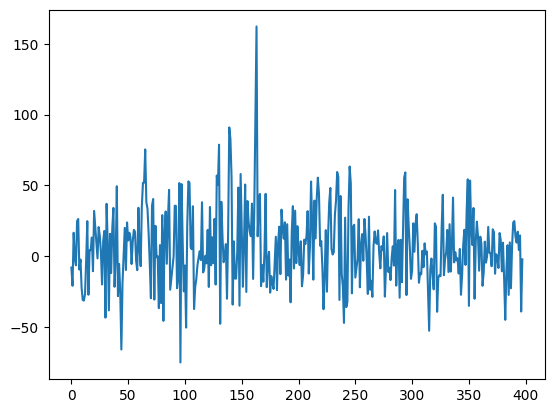

In [214]:
plt.plot((loss_values_LSTM-loss_values_RNN))

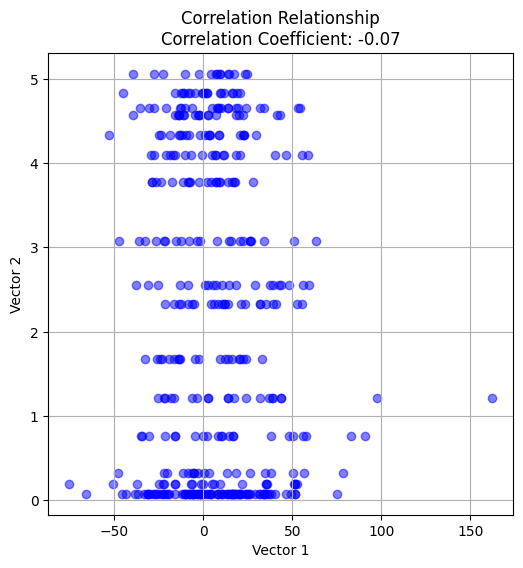

In [215]:
# Compute the Pearson correlation coefficient
correlation_coefficient = np.corrcoef((loss_values_LSTM-loss_values_RNN), h_t_indicator_1x398)[0, 1]

# Create a scatter plot
plt.figure(figsize=(6, 6))
plt.scatter((loss_values_LSTM-loss_values_RNN), h_t_indicator_1x398, color='blue', alpha=0.5)
plt.title(f"Correlation Relationship\nCorrelation Coefficient: {correlation_coefficient:.2f}")
plt.xlabel("Vector 1")
plt.ylabel("Vector 2")
plt.grid(True)
plt.show()

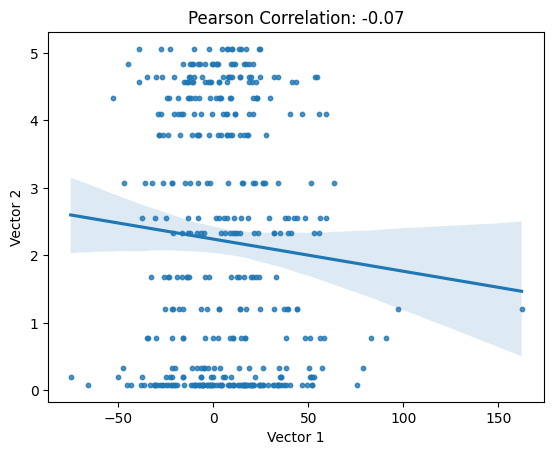

In [216]:

# Assuming vector_1 and vector_2 are your two vectors
# If you haven't defined these vectors yet, make sure to create them first

# Calculate the Pearson correlation coefficient
correlation_coefficient = np.corrcoef((loss_values_LSTM-loss_values_RNN),  h_t_indicator_1x398)[0, 1]

# Create a scatter plot with a linear regression line
sns.regplot(x=(loss_values_LSTM-loss_values_RNN), y=h_t_indicator_1x398, scatter_kws={'s': 10})
plt.title(f'Pearson Correlation: {correlation_coefficient:.2f}')
plt.xlabel('Vector 1')
plt.ylabel('Vector 2')

# Display the plot
plt.show()


In [217]:
correlation_coefficient_lossdifference = np.corrcoef((loss_values_LSTM-loss_values_RNN),h_t_lossdifferenceLSTMvsRNN[:, :-1]
 )[0, 1]
print(correlation_coefficient_lossdifference)

0.11497509377101722


In [218]:
correlation_coefficient_losslagged = np.corrcoef((loss_values_LSTM-loss_values_RNN),h_t_lossdifferenceRNNvsLSTM_lagged )[0, 1]
print(correlation_coefficient_losslagged)

-0.025346896287801048


In [337]:
np.mean(h_t_lossdifferenceRNNvsLSTM_lagged)

0.05636581344221105

In [338]:
np.mean(loss_values_LSTM-loss_values_RNN)

6.03481764290201

In [346]:
vector_of_ones = np.ones((1, 398))


In [347]:
correlation_coefficient_constant = np.corrcoef((loss_values_LSTM-loss_values_RNN),vector_of_ones )[0, 1]
print(correlation_coefficient_constant)

nan


In [219]:
correlation_coefficient_MA = np.corrcoef((loss_values_LSTM-loss_values_RNN),h_t_MA_RNNvsLSTM[1:])[0, 1]
print(correlation_coefficient_MA)

0.6281327059706314


In [220]:
correlation_coefficient_com= np.corrcoef((loss_values_LSTM-loss_values_RNN),h_t_indicator_lossdifferenceLSTMvsRNN)[0, 1]
print(correlation_coefficient_com)

-0.06981598975150989


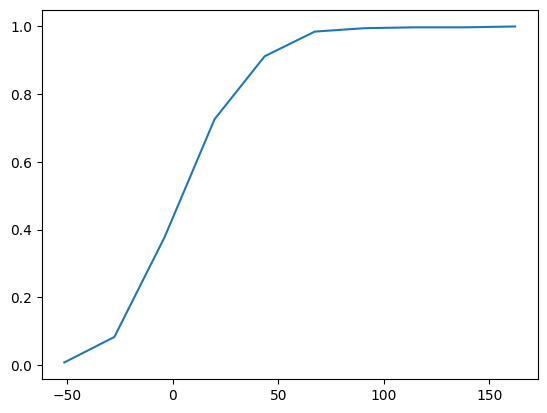

In [222]:
count, bins_count = np.histogram((loss_values_LSTM-loss_values_RNN), bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF")


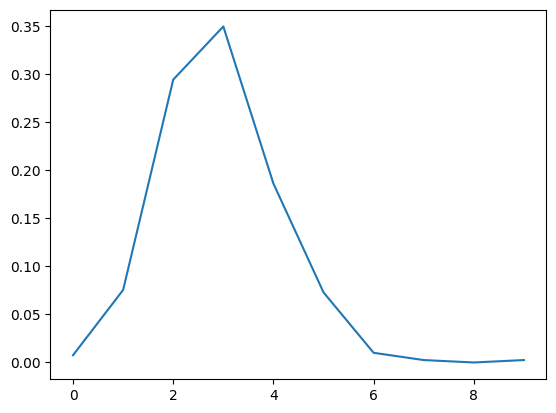

In [223]:
plt.plot(pdf)

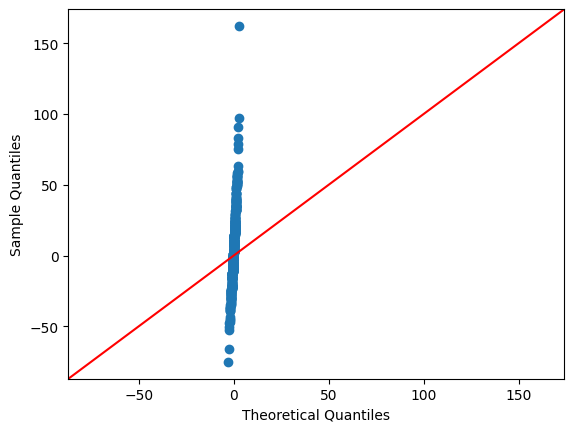

In [225]:
sm.qqplot((loss_values_LSTM-loss_values_RNN), line ='45')
py.show()

In [226]:
# Testing test function as the price of a highly correlated stock price

In [227]:
amazon_data = yf.download("AMZN", start="2021-10-13", end="2023-05-21")

# Extract the closing prices from the downloaded data
amazon_data = amazon_data['Close']

[*********************100%***********************]  1 of 1 completed


In [228]:
amazon_data.shape

(403,)

## 7. Monte Carlo Simulation


In [229]:
data_MC = yf.download("^GSPC", start="2021-10-13", end="2023-05-21")
data_MC["Daily_Return"] = data_MC["Close"].pct_change()



[*********************100%***********************]  1 of 1 completed


In [230]:
""" 
# Parameters for the GBM model
initial_price = data_MC["Close"].iloc[0]
drift = data_MC["Daily_Return"].mean()  # Average annual return
volatility =data_MC["Daily_Return"].std()   # Standard deviation of returns
time_steps = len(data_MC) # Number of trading days in a year
num_simulations = 5   # Number of simulated paths

# Simulate stock price paths using Monte Carlo
simulated_prices = []


for _ in range(num_simulations):
    daily_returns = np.random.normal(drift / time_steps, volatility / np.sqrt(time_steps), time_steps)
    price_path = [initial_price]

    for i in range(1, time_steps):
        price_path.append(price_path[i - 1] * (1 + daily_returns[i]))

    simulated_prices.append(price_path)

# Plot GBM paths
plt.figure(figsize=(10, 6))
plt.plot(data_MC.index, data_MC["Close"], label="Actual Data")

for path in simulated_prices:
    plt.plot(data_MC.index, path)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Monte Carlo Simulation of Geometric Brownian Motion (GBM)")
plt.legend()
plt.grid()
plt.show()

 """

' \n# Parameters for the GBM model\ninitial_price = data_MC["Close"].iloc[0]\ndrift = data_MC["Daily_Return"].mean()  # Average annual return\nvolatility =data_MC["Daily_Return"].std()   # Standard deviation of returns\ntime_steps = len(data_MC) # Number of trading days in a year\nnum_simulations = 5   # Number of simulated paths\n\n# Simulate stock price paths using Monte Carlo\nsimulated_prices = []\n\n\nfor _ in range(num_simulations):\n    daily_returns = np.random.normal(drift / time_steps, volatility / np.sqrt(time_steps), time_steps)\n    price_path = [initial_price]\n\n    for i in range(1, time_steps):\n        price_path.append(price_path[i - 1] * (1 + daily_returns[i]))\n\n    simulated_prices.append(price_path)\n\n# Plot GBM paths\nplt.figure(figsize=(10, 6))\nplt.plot(data_MC.index, data_MC["Close"], label="Actual Data")\n\nfor path in simulated_prices:\n    plt.plot(data_MC.index, path)\n\nplt.xlabel("Date")\nplt.ylabel("Price")\nplt.title("Monte Carlo Simulation of Geome

In [231]:
""" 

# Set parameters
initial_price = data_MC["Close"].iloc[0]
drift = data_MC["Daily_Return"].mean()
volatility = data_MC["Daily_Return"].std()
time_step = 1
H = 1 # Fractional parameter (Hurst exponent)
n_days = len(data_MC)
n_simulations = 5  # Number of Monte Carlo simulations

# Simulate FGBM paths
np.random.seed(42)  # for reproducibility
fgbm_paths = np.zeros((n_simulations, n_days))
for i in range(n_simulations):
    increments = np.random.normal(0, np.sqrt(time_step), n_days)
    increments = np.cumsum(increments)
    fgbm_path = initial_price * np.exp((drift - 0.5 * volatility**2) * time_step * np.arange(1, n_days+1))
    fgbm_path += volatility * fgbm_path**H * increments
    fgbm_paths[i, :] = fgbm_path

# Plot FGBM paths
plt.figure(figsize=(10, 6))
plt.plot(data_MC.index, data_MC["Close"], label="Actual Data")
for i in range(n_simulations):
    plt.plot(data_MC.index, fgbm_paths[i, :], label=f"Simulated Path {i+1}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Monte Carlo Simulation of Fractional Geometric Brownian Motion (FGBM)")
plt.legend()
plt.grid()
plt.show()
 """

' \n\n# Set parameters\ninitial_price = data_MC["Close"].iloc[0]\ndrift = data_MC["Daily_Return"].mean()\nvolatility = data_MC["Daily_Return"].std()\ntime_step = 1\nH = 1 # Fractional parameter (Hurst exponent)\nn_days = len(data_MC)\nn_simulations = 5  # Number of Monte Carlo simulations\n\n# Simulate FGBM paths\nnp.random.seed(42)  # for reproducibility\nfgbm_paths = np.zeros((n_simulations, n_days))\nfor i in range(n_simulations):\n    increments = np.random.normal(0, np.sqrt(time_step), n_days)\n    increments = np.cumsum(increments)\n    fgbm_path = initial_price * np.exp((drift - 0.5 * volatility**2) * time_step * np.arange(1, n_days+1))\n    fgbm_path += volatility * fgbm_path**H * increments\n    fgbm_paths[i, :] = fgbm_path\n\n# Plot FGBM paths\nplt.figure(figsize=(10, 6))\nplt.plot(data_MC.index, data_MC["Close"], label="Actual Data")\nfor i in range(n_simulations):\n    plt.plot(data_MC.index, fgbm_paths[i, :], label=f"Simulated Path {i+1}")\nplt.xlabel("Date")\nplt.ylabel("

### SImulated Path1


In [232]:
""" fgbm_paths.shape """

' fgbm_paths.shape '

In [233]:
""" Sim1=lag_transform(Sim1,1) """

' Sim1=lag_transform(Sim1,1) '

In [234]:
""" Sim1 """


' Sim1 '

In [235]:
""" test_predictor_sim1, test_target_sim1 = dataset_generator_lstm( Sim1.values,look_back=5)
 """

' test_predictor_sim1, test_target_sim1 = dataset_generator_lstm( Sim1.values,look_back=5)\n '

In [236]:
""" test_predictor_sim1.shape """

' test_predictor_sim1.shape '

In [237]:
""" test_target_sim1.shape """

' test_target_sim1.shape '

In [238]:
""" test_predictor_sim1_reshape = np.reshape(test_predictor_sim1 ,(test_predictor_sim1.shape[0], 5, 1))
 """

' test_predictor_sim1_reshape = np.reshape(test_predictor_sim1 ,(test_predictor_sim1.shape[0], 5, 1))\n '

In [239]:
""" test_predictor_sim1_reshape.shape """

' test_predictor_sim1_reshape.shape '

### LSTM on Sim1

In [240]:
""" lossLSTMsim1,maeLSTMsim1= LSTM_model.evaluate(test_predictor_sim1_reshape,test_target_sim1) """

' lossLSTMsim1,maeLSTMsim1= LSTM_model.evaluate(test_predictor_sim1_reshape,test_target_sim1) '

In [241]:
""" test_target_pred_sim1 = LSTM_model.predict(test_predictor_sim1_reshape)
 """

' test_target_pred_sim1 = LSTM_model.predict(test_predictor_sim1_reshape)\n '

In [242]:
""" 
loss_values_LSTM_sim1 = []
for i in range(len(test_predictor_sim1_reshape)):
    loss = LSTM_model.evaluate(test_predictor_sim1_reshape[i:i+1], test_target_sim1[i:i+1], verbose=0)[0]
    loss_values_LSTM_sim1.append(loss) """

' \nloss_values_LSTM_sim1 = []\nfor i in range(len(test_predictor_sim1_reshape)):\n    loss = LSTM_model.evaluate(test_predictor_sim1_reshape[i:i+1], test_target_sim1[i:i+1], verbose=0)[0]\n    loss_values_LSTM_sim1.append(loss) '

In [243]:
#np.save('loss_values_LSTM_sim1.npy', loss_values_LSTM_sim1)


In [244]:
loss_values_LSTM_sim1 = np.load('loss_values_LSTM_sim1.npy')


### GRU on sim1


In [245]:
""" lossGRUsim1,maeGRUsim1=GRU_model.evaluate(test_predictor_sim1_reshape,test_target_sim1)
test_target_pred_sim1_gru = GRU_model.predict(test_predictor_sim1_reshape)


loss_values_GRU_sim1 = []
for i in range(len(test_predictor_sim1_reshape)):
    loss = GRU_model.evaluate(test_predictor_sim1_reshape[i:i+1], test_target_sim1[i:i+1], verbose=0)[0]
    loss_values_GRU_sim1.append(loss) """

' lossGRUsim1,maeGRUsim1=GRU_model.evaluate(test_predictor_sim1_reshape,test_target_sim1)\ntest_target_pred_sim1_gru = GRU_model.predict(test_predictor_sim1_reshape)\n\n\nloss_values_GRU_sim1 = []\nfor i in range(len(test_predictor_sim1_reshape)):\n    loss = GRU_model.evaluate(test_predictor_sim1_reshape[i:i+1], test_target_sim1[i:i+1], verbose=0)[0]\n    loss_values_GRU_sim1.append(loss) '

In [246]:
""" np.save('loss_values_GRU_sim1.npy', loss_values_GRU_sim1)
 """

" np.save('loss_values_GRU_sim1.npy', loss_values_GRU_sim1)\n "

In [247]:
loss_values_GRU_sim1 = np.load('loss_values_GRU_sim1.npy')


In [248]:
h_t_lossdifferenceLSTMvsGRU_sim1=loss_values_LSTM_sim1-loss_values_GRU_sim1
h_t_lossdifferenceLSTMvsGRU_sim1= np.insert(h_t_lossdifferenceLSTMvsGRU_sim1, 0, 0)
h_t_lossdifferenceLSTMvsGRU_sim1=h_t_lossdifferenceLSTMvsGRU_sim1.reshape(1, -1)
Z_m_fixed_LSTMvsGRU_sim1=h_t_lossdifferenceLSTMvsGRU_sim1[:, :-1]*(loss_values_LSTM_sim1-loss_values_GRU_sim1)
Z_m_fixed_bar_LSTMvsGRU_sim1=1/n *Z_m_fixed_LSTMvsGRU_sim1.sum()
omegaLSTMvsGRU_sim1= 1/n * (Z_m_fixed_LSTMvsGRU_sim1*Z_m_fixed_LSTMvsGRU_sim1).sum()
teststatLSTMvsGRU_sim1=n*Z_m_fixed_bar_LSTMvsGRU_sim1*1/omegaLSTMvsGRU_sim1*Z_m_fixed_bar_LSTMvsGRU_sim1
# Compute the p-value
p_valueLSTMvsGRU_lossdifference_sim1= 1 - chi2.cdf(teststatLSTMvsGRU_sim1, 1)

# Print the p-value
print("p-value bwt LSTM vs GRU:", p_valueLSTMvsGRU_lossdifference_sim1)


p-value bwt LSTM vs GRU: 0.6793439666677918


### 8. MC Final

In [249]:
""" # Set parameters
initial_price = data_MC["Close"].iloc[0]
drift = data_MC["Daily_Return"].mean()
volatility = data_MC["Daily_Return"].std()
time_step = 1
H = 1 # Fractional parameter (Hurst exponent)
n_days = len(data_MC)
n_simulations = 100  # Number of Monte Carlo simulations

# Simulate FGBM paths
np.random.seed(42)  # for reproducibility
fgbm_paths = np.zeros((n_simulations, n_days))
for i in range(n_simulations):
    increments = np.random.normal(0, np.sqrt(time_step), n_days)
    increments = np.cumsum(increments)
    fgbm_path = initial_price * np.exp((drift - 0.5 * volatility**2) * time_step * np.arange(1, n_days+1))
    fgbm_path += volatility * fgbm_path**H * increments
    fgbm_paths[i, :] = fgbm_path


 """

' # Set parameters\ninitial_price = data_MC["Close"].iloc[0]\ndrift = data_MC["Daily_Return"].mean()\nvolatility = data_MC["Daily_Return"].std()\ntime_step = 1\nH = 1 # Fractional parameter (Hurst exponent)\nn_days = len(data_MC)\nn_simulations = 100  # Number of Monte Carlo simulations\n\n# Simulate FGBM paths\nnp.random.seed(42)  # for reproducibility\nfgbm_paths = np.zeros((n_simulations, n_days))\nfor i in range(n_simulations):\n    increments = np.random.normal(0, np.sqrt(time_step), n_days)\n    increments = np.cumsum(increments)\n    fgbm_path = initial_price * np.exp((drift - 0.5 * volatility**2) * time_step * np.arange(1, n_days+1))\n    fgbm_path += volatility * fgbm_path**H * increments\n    fgbm_paths[i, :] = fgbm_path\n\n\n '

In [250]:
""" Sim = np.zeros((n_simulations, n_days))
test_target_Sim = np.zeros((n_simulations, n_days - 5))
test_predictor_Sim = np.zeros((n_simulations, n_days - 5, 5))
test_predictor_Sim_reshape = np.zeros((n_simulations, n_days - 5, 5, 1))
loss_values_LSTM_Sim = np.zeros((n_simulations, n_days - 5))
loss_values_GRU_Sim = np.zeros((n_simulations, n_days - 5))
p_valueLSTMvsGRU_lossdifference=np.empty(n_simulations)

for i in range(n_simulations):
    Sim[i, :] = fgbm_paths[i, :]
    test_predictor_Sim[i, :, :], test_target_Sim[i, :] = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape[i, :, :, :] = np.reshape(test_predictor_Sim[i, :, :], (test_predictor_Sim[i, :, :].shape[0], 5, 1))

    # LSTM
    for j in range(n_days - 5):
        loss = LSTM_model.evaluate(test_predictor_Sim_reshape[i, j:j+1, :, :], test_target_Sim[i, j:j+1], verbose=0)[0]
        loss_values_LSTM_Sim[i, j] = loss

    #GRU
    for j in range(n_days - 5):
        loss = GRU_model.evaluate(test_predictor_Sim_reshape[i, j:j+1, :, :], test_target_Sim[i, j:j+1], verbose=0)[0]
        loss_values_GRU_Sim[i, j] = loss

    #Loss difference test function
    h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)
    h_t_lossdifferenceLSTMvsGRU=h_t_lossdifferenceLSTMvsGRU.reshape(1, -1)
    Z_m_fixed_LSTMvsGRU=h_t_lossdifferenceLSTMvsGRU[:, :-1]*(loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixed_bar_LSTMvsGRU=1/n *Z_m_fixed_LSTMvsGRU.sum()
    omegaLSTMvsGRU= 1/n * (Z_m_fixed_LSTMvsGRU*Z_m_fixed_LSTMvsGRU).sum()
    teststatLSTMvsGRU=n*Z_m_fixed_bar_LSTMvsGRU*1/omegaLSTMvsGRU*Z_m_fixed_bar_LSTMvsGRU
    # Compute the p-value
    p_valueLSTMvsGRU_lossdifference[i]= 1 - chi2.cdf(teststatLSTMvsGRU, 1)
 """
    


' Sim = np.zeros((n_simulations, n_days))\ntest_target_Sim = np.zeros((n_simulations, n_days - 5))\ntest_predictor_Sim = np.zeros((n_simulations, n_days - 5, 5))\ntest_predictor_Sim_reshape = np.zeros((n_simulations, n_days - 5, 5, 1))\nloss_values_LSTM_Sim = np.zeros((n_simulations, n_days - 5))\nloss_values_GRU_Sim = np.zeros((n_simulations, n_days - 5))\np_valueLSTMvsGRU_lossdifference=np.empty(n_simulations)\n\nfor i in range(n_simulations):\n    Sim[i, :] = fgbm_paths[i, :]\n    test_predictor_Sim[i, :, :], test_target_Sim[i, :] = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)\n    test_predictor_Sim_reshape[i, :, :, :] = np.reshape(test_predictor_Sim[i, :, :], (test_predictor_Sim[i, :, :].shape[0], 5, 1))\n\n    # LSTM\n    for j in range(n_days - 5):\n        loss = LSTM_model.evaluate(test_predictor_Sim_reshape[i, j:j+1, :, :], test_target_Sim[i, j:j+1], verbose=0)[0]\n        loss_values_LSTM_Sim[i, j] = loss\n\n    #GRU\n    for j in range(n_days - 5)

In [251]:
""" p_valueLSTMvsGRU_lossdifference """

' p_valueLSTMvsGRU_lossdifference '

In [252]:
""" plt.plot(p_valueLSTMvsGRU_lossdifference)
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('Simulation Index')
plt.ylabel('P-value')
plt.title('P-values of Loss Difference Test (LSTM vs GRU)')
plt.legend()
plt.show() """

" plt.plot(p_valueLSTMvsGRU_lossdifference)\nplt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')\nplt.xlabel('Simulation Index')\nplt.ylabel('P-value')\nplt.title('P-values of Loss Difference Test (LSTM vs GRU)')\nplt.legend()\nplt.show() "

In [253]:
""" plt.hist(p_valueLSTMvsGRU_lossdifference, bins=20, edgecolor='black', alpha=0.7)
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Histogram of P-values (LSTM vs GRU)')
plt.legend()
plt.show() """

" plt.hist(p_valueLSTMvsGRU_lossdifference, bins=20, edgecolor='black', alpha=0.7)\nplt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')\nplt.xlabel('P-value')\nplt.ylabel('Frequency')\nplt.title('Histogram of P-values (LSTM vs GRU)')\nplt.legend()\nplt.show() "

### 9. MC final reduction

In [254]:
# Set parameters
initial_price = data_MC["Close"].iloc[0]
drift = data_MC["Daily_Return"].mean()
volatility = data_MC["Daily_Return"].std()
time_step = 1
H = 1 # Fractional parameter (Hurst exponent)
n_days = len(data_MC)
n_simulations = 300  # Number of Monte Carlo simulations
# Simulate FGBM paths
np.random.seed(42)  # for reproducibility
fgbm_paths = np.zeros((n_simulations, n_days))
for i in range(n_simulations):
    increments = np.random.normal(0, np.sqrt(time_step), n_days)
    increments = np.cumsum(increments)
    fgbm_path = initial_price * np.exp((drift - 0.5 * volatility**2) * time_step * np.arange(1, n_days+1))
    fgbm_path += volatility * fgbm_path**H * increments
    fgbm_paths[i, :] = fgbm_path




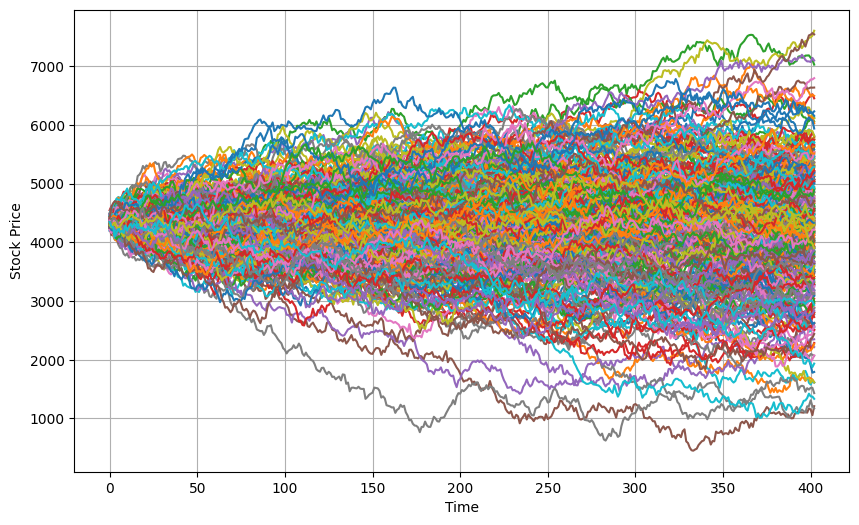

In [255]:

# Plot each simulation path
plt.figure(figsize=(10, 6))  # Set the figure size
for i in range(n_simulations):
    plt.plot(fgbm_paths[i, :], label=f"Simulation {i+1}")

# Add labels and title
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.grid(True)  # Add grid lines

# Show the plot
plt.show()


### LSTM vs GRU

In [263]:
""" 
p_valueGRUvsLSTM_constant=np.empty(n_simulations)
p_valueLSTMvsGRU_interestrate=np.empty(n_simulations)
p_valueLSTMvsGRU_lossdifference=np.empty(n_simulations)
p_valueLSTMvsGRU_laggedloss=np.empty(n_simulations)
p_value_MA_LSTMvsGRU5=np.empty(n_simulations)
p_valueGRUvsLSTM_indicator_lossdifference=np.empty(n_simulations)

for i in range(n_simulations):
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))


    # Constant function
    Z_m_fixedGRUvsLSTM_constant=loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    Z_m_fixed_barGRUvsLSTM_constant=1/n *sum(Z_m_fixedGRUvsLSTM_constant)
    omegaGRUvsLSTM_constant= 1/n * sum(Z_m_fixedGRUvsLSTM_constant*Z_m_fixedGRUvsLSTM_constant)
    teststatGRUvsLSTM_constant=n*Z_m_fixed_barGRUvsLSTM_constant*1/omegaGRUvsLSTM_constant*Z_m_fixed_barGRUvsLSTM_constant
    # Compute the p-value
    p_valueGRUvsLSTM_constant[i] = 1 - chi2.cdf(teststatGRUvsLSTM_constant, 1)



    
    # Business cycle indicator
    DeltaGRUvsLSTM=(loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixedGRUvsLSTM_interestrate=h_t_indicator_1x398*(DeltaGRUvsLSTM)
    Z_m_fixedGRUvsLSTM_bar_interestrate=1/n *Z_m_fixedGRUvsLSTM_interestrate.sum().sum()
    omegaGRUvsLSTM_interestrate= 1/n * (Z_m_fixedGRUvsLSTM_interestrate*Z_m_fixedGRUvsLSTM_interestrate).sum().sum()
    teststatLSTMvsGRU_interestrate5=n*Z_m_fixedGRUvsLSTM_bar_interestrate*1/omegaGRUvsLSTM_interestrate*Z_m_fixedGRUvsLSTM_bar_interestrate
    # Compute the p-value
    p_valueLSTMvsGRU_interestrate[i]= 1 - chi2.cdf(teststatLSTMvsGRU_interestrate5, 1)
    
    
    #Loss difference test function
    h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)
    h_t_lossdifferenceLSTMvsGRU=h_t_lossdifferenceLSTMvsGRU.reshape(1, -1)
    Z_m_fixed_LSTMvsGRU=h_t_lossdifferenceLSTMvsGRU[:, :-1]*(loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixed_bar_LSTMvsGRU=1/n *Z_m_fixed_LSTMvsGRU.sum()
    omegaLSTMvsGRU= 1/n * (Z_m_fixed_LSTMvsGRU*Z_m_fixed_LSTMvsGRU).sum()
    teststatLSTMvsGRU=n*Z_m_fixed_bar_LSTMvsGRU*1/omegaLSTMvsGRU*Z_m_fixed_bar_LSTMvsGRU
    # Compute the p-value
    p_valueLSTMvsGRU_lossdifference[i]= 1 - chi2.cdf(teststatLSTMvsGRU, 1)

    # Lagged loss difference
    h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    two_last_lossdifferenceLSTMvsGRU=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
    two_last_lossdifferenceLSTMvsGRU = two_last_lossdifferenceLSTMvsGRU.reshape((2,))
    h_t_lossdifferenceLSTMvsGRU= np.concatenate((two_last_lossdifferenceLSTMvsGRU, h_t_lossdifferenceLSTMvsGRU))
    h_t_lossdifferenceLSTMvsGRU_lagged = h_t_lossdifferenceLSTMvsGRU[1:]-h_t_lossdifferenceLSTMvsGRU[:-1]
    h_t_lossdifferenceLSTMvsGRU_lagged=h_t_lossdifferenceLSTMvsGRU_lagged[:-1].reshape(1, -1)
    Z_m_fixed_LSTMvsGRU_laggedloss=(h_t_lossdifferenceLSTMvsGRU_lagged)*(loss_values_LSTM-loss_values_GRU)
    Z_m_fixed_bar_LSTMvsGRU_laggedloss=1/n *Z_m_fixed_LSTMvsGRU_laggedloss.sum()
    omegaLSTMvsGRU_laggedloss= 1/n * (Z_m_fixed_LSTMvsGRU_laggedloss*Z_m_fixed_LSTMvsGRU_laggedloss).sum()
    teststatLSTMvsGRU_laggedloss=n*Z_m_fixed_bar_LSTMvsGRU_laggedloss*1/omegaLSTMvsGRU_laggedloss*Z_m_fixed_bar_LSTMvsGRU_laggedloss
    # Compute the p-value
    p_valueLSTMvsGRU_laggedloss[i]= 1 - chi2.cdf(teststatLSTMvsGRU_laggedloss, 1)

    
    # Moving Average
    lossdiffer_GRUvsLSTM=loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    three_last_lossdifferenceLSTMvsGRU=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
    three_last_lossdifferenceLSTMvsGRU = three_last_lossdifferenceLSTMvsGRU.reshape((3,))
    lossdiffer_GRUvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsGRU, lossdiffer_GRUvsLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_LSTMvsGRU = []
    for m in range(k, len(lossdiffer_GRUvsLSTM)+1):
        sum_delta = sum(lossdiffer_GRUvsLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_LSTMvsGRU.append(ma)

    Z_m_fixed_MA_LSTMvsGRU5=h_t_MA_LSTMvsGRU[:-1]*(loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixed_MA_bar_LSTMvsGRU5=1/n *Z_m_fixed_MA_LSTMvsGRU5.sum()
    omegaLSTMvsGRU5= 1/n * (Z_m_fixed_MA_LSTMvsGRU5*Z_m_fixed_MA_LSTMvsGRU5).sum()
    teststatLSTMvsGRU5=n*Z_m_fixed_MA_bar_LSTMvsGRU5*1/omegaLSTMvsGRU5*Z_m_fixed_MA_bar_LSTMvsGRU5
    # Compute the p-value
    p_value_MA_LSTMvsGRU5[i]= 1 - chi2.cdf(teststatLSTMvsGRU5, 1)


    # Combination of test functions
    h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)
    h_t_lossdifferenceLSTMvsGRU=h_t_lossdifferenceLSTMvsGRU.reshape(1, -1)

    h_t_indicator_lossdifferenceLSTMvsGRU=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsGRU[:, :-1]))

    DeltaLSTMvsGRU=(loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixed_indicator_lossdifferenceLSTMvsGRU=h_t_indicator_lossdifferenceLSTMvsGRU*(DeltaLSTMvsGRU)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceLSTMvsGRU, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU, (2, 1))
    omegaLSTMvsGRU_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceLSTMvsGRU@(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN.T)
    teststatLSTMvsGRU_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU.T)@(np.linalg.inv(omegaLSTMvsGRU_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU
    # Compute the p-value
    p_valueGRUvsLSTM_indicator_lossdifference[i]= 1 - chi2.cdf(teststatLSTMvsGRU_indicator_lossdifference5, 2)
     """

In [264]:
""" 
p_values_arrays_GRUvsLSTM = [p_valueGRUvsLSTM_constant, p_valueLSTMvsGRU_interestrate, 
                   p_valueLSTMvsGRU_lossdifference, p_valueLSTMvsGRU_laggedloss, 
                   p_value_MA_LSTMvsGRU5, p_valueGRUvsLSTM_indicator_lossdifference] """

In [265]:
""" # Specify the file path
file_path = "p_values_arrays_GRUvsLSTM.pkl"

# Save the list to a binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(p_values_arrays_GRUvsLSTM, binary_file) """

In [266]:

# Load the data from the binary file
with open("p_values_arrays_GRUvsLSTM.pkl", "rb") as binary_file:
    p_values_arrays_GRUvsLSTM = pickle.load(binary_file)

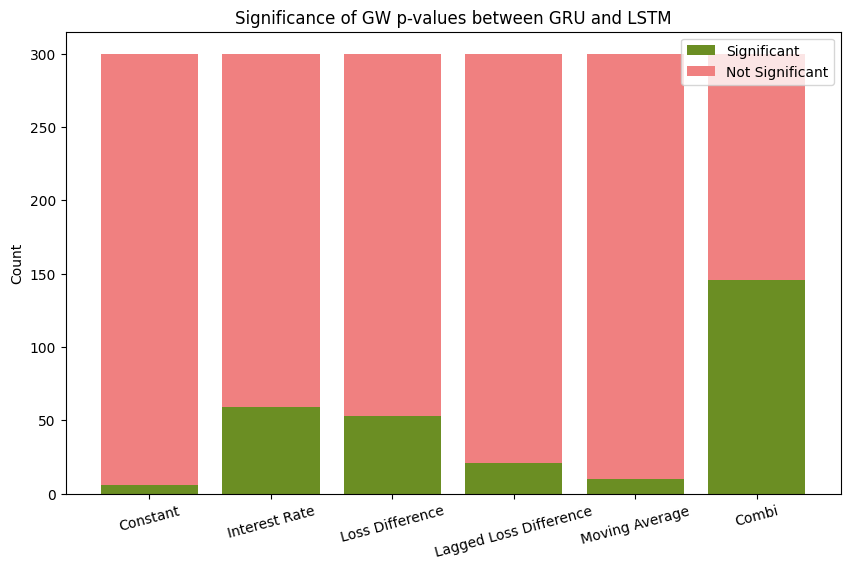

In [268]:
labels = ['Constant', 'Interest Rate', 
          'Loss Difference', 'Lagged Loss Difference', 
          'Moving Average', 'Combi']
significant = [np.sum(p_values <= 0.05) for p_values in p_values_arrays_GRUvsLSTM]
not_significant = [n_simulations - s for s in significant]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(significant)), significant, label='Significant', color="olivedrab")
plt.bar(np.arange(len(significant)), not_significant, bottom=significant, label='Not Significant', color='lightcoral')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('Count')
plt.title('Significance of GW p-values between GRU and LSTM')
plt.legend()
plt.show()


In [260]:
# Same result
""" Sim = np.zeros((n_simulations, n_days))
loss_values_LSTM_Sim = np.zeros((n_simulations, n_days - 5))
loss_values_GRU_Sim = np.zeros((n_simulations, n_days - 5))

p_valueGRUvsLSTM_constant=np.empty(n_simulations)
p_valueLSTMvsGRU_interestrate=np.empty(n_simulations)
p_valueLSTMvsGRU_lossdifference=np.empty(n_simulations)
p_valueLSTMvsGRU_laggedloss=np.empty(n_simulations)
p_value_MA_LSTMvsGRU5=np.empty(n_simulations)
p_valueGRUvsLSTM_indicator_lossdifference=np.empty(n_simulations)

for i in range(n_simulations):
    Sim[i, :] = fgbm_paths[i, :]
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))

    # LSTM
    for j in range(n_days - 5):
    
        loss = LSTM_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]
        loss_values_LSTM_Sim[i, j] = loss

    #GRU
    for j in range(n_days - 5):
        loss = GRU_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]
        loss_values_GRU_Sim[i, j] = loss



    # Constant function
    Z_m_fixedGRUvsLSTM_constant=loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    Z_m_fixed_barGRUvsLSTM_constant=1/n *sum(Z_m_fixedGRUvsLSTM_constant)
    omegaGRUvsLSTM_constant= 1/n * sum(Z_m_fixedGRUvsLSTM_constant*Z_m_fixedGRUvsLSTM_constant)
    teststatGRUvsLSTM_constant=n*Z_m_fixed_barGRUvsLSTM_constant*1/omegaGRUvsLSTM_constant*Z_m_fixed_barGRUvsLSTM_constant
    # Compute the p-value
    p_valueGRUvsLSTM_constant[i] = 1 - chi2.cdf(teststatGRUvsLSTM_constant, 1)



    
    # Business cycle indicator
    DeltaGRUvsLSTM=(loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixedGRUvsLSTM_interestrate=h_t_indicator_1x398*(DeltaGRUvsLSTM)
    Z_m_fixedGRUvsLSTM_bar_interestrate=1/n *Z_m_fixedGRUvsLSTM_interestrate.sum().sum()
    omegaGRUvsLSTM_interestrate= 1/n * (Z_m_fixedGRUvsLSTM_interestrate*Z_m_fixedGRUvsLSTM_interestrate).sum().sum()
    teststatLSTMvsGRU_interestrate5=n*Z_m_fixedGRUvsLSTM_bar_interestrate*1/omegaGRUvsLSTM_interestrate*Z_m_fixedGRUvsLSTM_bar_interestrate
    # Compute the p-value
    p_valueLSTMvsGRU_interestrate[i]= 1 - chi2.cdf(teststatLSTMvsGRU_interestrate5, 1)
    
    
    #Loss difference test function
    h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)
    h_t_lossdifferenceLSTMvsGRU=h_t_lossdifferenceLSTMvsGRU.reshape(1, -1)
    Z_m_fixed_LSTMvsGRU=h_t_lossdifferenceLSTMvsGRU[:, :-1]*(loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixed_bar_LSTMvsGRU=1/n *Z_m_fixed_LSTMvsGRU.sum()
    omegaLSTMvsGRU= 1/n * (Z_m_fixed_LSTMvsGRU*Z_m_fixed_LSTMvsGRU).sum()
    teststatLSTMvsGRU=n*Z_m_fixed_bar_LSTMvsGRU*1/omegaLSTMvsGRU*Z_m_fixed_bar_LSTMvsGRU
    # Compute the p-value
    p_valueLSTMvsGRU_lossdifference[i]= 1 - chi2.cdf(teststatLSTMvsGRU, 1)

    # Lagged loss difference
    h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    two_last_lossdifferenceLSTMvsGRU=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
    two_last_lossdifferenceLSTMvsGRU = two_last_lossdifferenceLSTMvsGRU.reshape((2,))
    h_t_lossdifferenceLSTMvsGRU= np.concatenate((two_last_lossdifferenceLSTMvsGRU, h_t_lossdifferenceLSTMvsGRU))
    h_t_lossdifferenceLSTMvsGRU_lagged = h_t_lossdifferenceLSTMvsGRU[1:]-h_t_lossdifferenceLSTMvsGRU[:-1]
    h_t_lossdifferenceLSTMvsGRU_lagged=h_t_lossdifferenceLSTMvsGRU_lagged[:-1].reshape(1, -1)
    Z_m_fixed_LSTMvsGRU_laggedloss=(h_t_lossdifferenceLSTMvsGRU_lagged)*(loss_values_LSTM-loss_values_GRU)
    Z_m_fixed_bar_LSTMvsGRU_laggedloss=1/n *Z_m_fixed_LSTMvsGRU_laggedloss.sum()
    omegaLSTMvsGRU_laggedloss= 1/n * (Z_m_fixed_LSTMvsGRU_laggedloss*Z_m_fixed_LSTMvsGRU_laggedloss).sum()
    teststatLSTMvsGRU_laggedloss=n*Z_m_fixed_bar_LSTMvsGRU_laggedloss*1/omegaLSTMvsGRU_laggedloss*Z_m_fixed_bar_LSTMvsGRU_laggedloss
    # Compute the p-value
    p_valueLSTMvsGRU_laggedloss[i]= 1 - chi2.cdf(teststatLSTMvsGRU_laggedloss, 1)

    
    # Moving Average
    lossdiffer_GRUvsLSTM=loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    three_last_lossdifferenceLSTMvsGRU=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
    three_last_lossdifferenceLSTMvsGRU = three_last_lossdifferenceLSTMvsGRU.reshape((3,))
    lossdiffer_GRUvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsGRU, lossdiffer_GRUvsLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_LSTMvsGRU = []
    for m in range(k, len(lossdiffer_GRUvsLSTM)+1):
        sum_delta = sum(lossdiffer_GRUvsLSTM[m-k:i])
        ma = sum_delta / k
        h_t_MA_LSTMvsGRU.append(ma)

    Z_m_fixed_MA_LSTMvsGRU5=h_t_MA_LSTMvsGRU[:-1]*(loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixed_MA_bar_LSTMvsGRU5=1/n *Z_m_fixed_MA_LSTMvsGRU5.sum()
    omegaLSTMvsGRU5= 1/n * (Z_m_fixed_MA_LSTMvsGRU5*Z_m_fixed_MA_LSTMvsGRU5).sum()
    teststatLSTMvsGRU5=n*Z_m_fixed_MA_bar_LSTMvsGRU5*1/omegaLSTMvsGRU5*Z_m_fixed_MA_bar_LSTMvsGRU5
    # Compute the p-value
    p_value_MA_LSTMvsGRU5[i]= 1 - chi2.cdf(teststatLSTMvsGRU5, 1)


    # Combination of test functions
    h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)
    h_t_lossdifferenceLSTMvsGRU=h_t_lossdifferenceLSTMvsGRU.reshape(1, -1)

    h_t_indicator_lossdifferenceLSTMvsGRU=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsGRU[:, :-1]))

    DeltaLSTMvsGRU=(loss_values_LSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixed_indicator_lossdifferenceLSTMvsGRU=h_t_indicator_lossdifferenceLSTMvsGRU*(DeltaLSTMvsGRU)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceLSTMvsGRU, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU, (2, 1))
    omegaLSTMvsGRU_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceLSTMvsGRU@(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN.T)
    teststatLSTMvsGRU_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU.T)@(np.linalg.inv(omegaLSTMvsGRU_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU
    # Compute the p-value
    p_valueGRUvsLSTM_indicator_lossdifference[i]= 1 - chi2.cdf(teststatLSTMvsGRU_indicator_lossdifference5, 2)
     """

' Sim = np.zeros((n_simulations, n_days))\nloss_values_LSTM_Sim = np.zeros((n_simulations, n_days - 5))\nloss_values_GRU_Sim = np.zeros((n_simulations, n_days - 5))\n\np_valueGRUvsLSTM_constant=np.empty(n_simulations)\np_valueLSTMvsGRU_interestrate=np.empty(n_simulations)\np_valueLSTMvsGRU_lossdifference=np.empty(n_simulations)\np_valueLSTMvsGRU_laggedloss=np.empty(n_simulations)\np_value_MA_LSTMvsGRU5=np.empty(n_simulations)\np_valueGRUvsLSTM_indicator_lossdifference=np.empty(n_simulations)\n\nfor i in range(n_simulations):\n    Sim[i, :] = fgbm_paths[i, :]\n    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)\n    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))\n\n    # LSTM\n    for j in range(n_days - 5):\n    \n        loss = LSTM_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]\n        loss_values_LSTM_Sim[i, j] = loss\n\n    

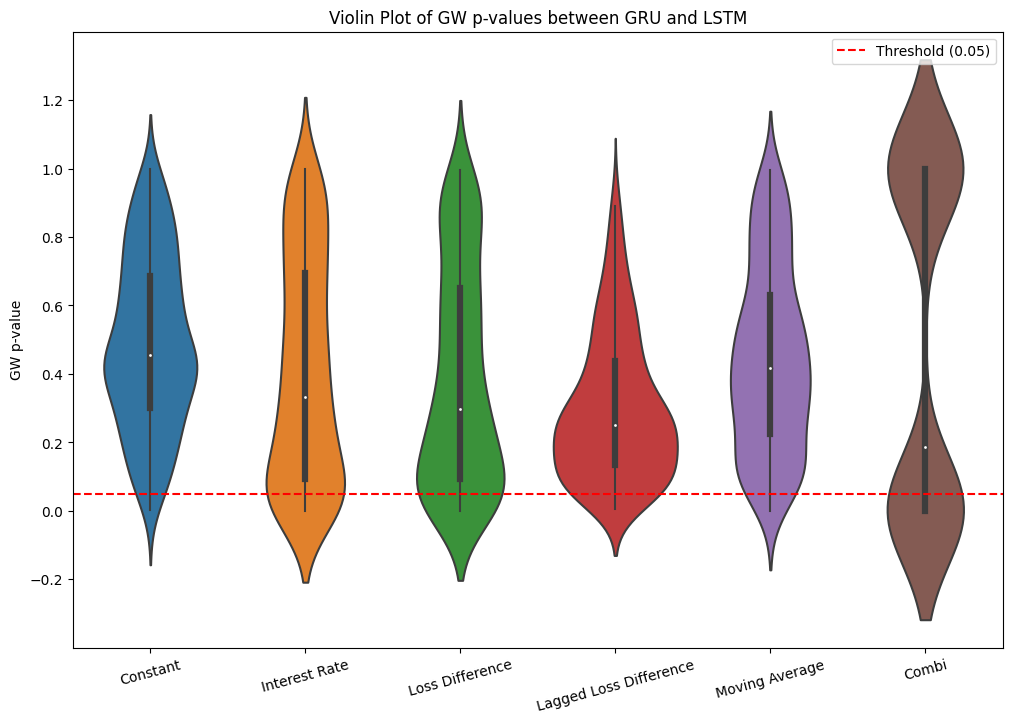

In [269]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=p_values_arrays_GRUvsLSTM)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('GW p-value')
plt.title('Violin Plot of GW p-values between GRU and LSTM')
plt.legend()
plt.show()


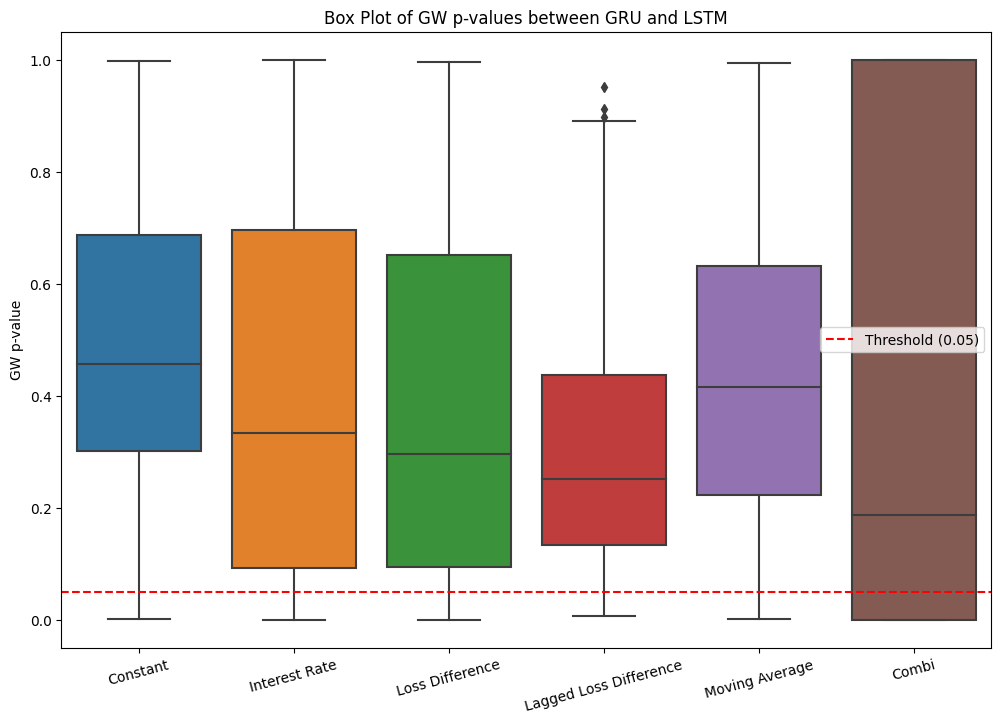

In [270]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_GRUvsLSTM)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('GW p-value')
plt.title('Box Plot of GW p-values between GRU and LSTM')

plt.legend()
plt.show()


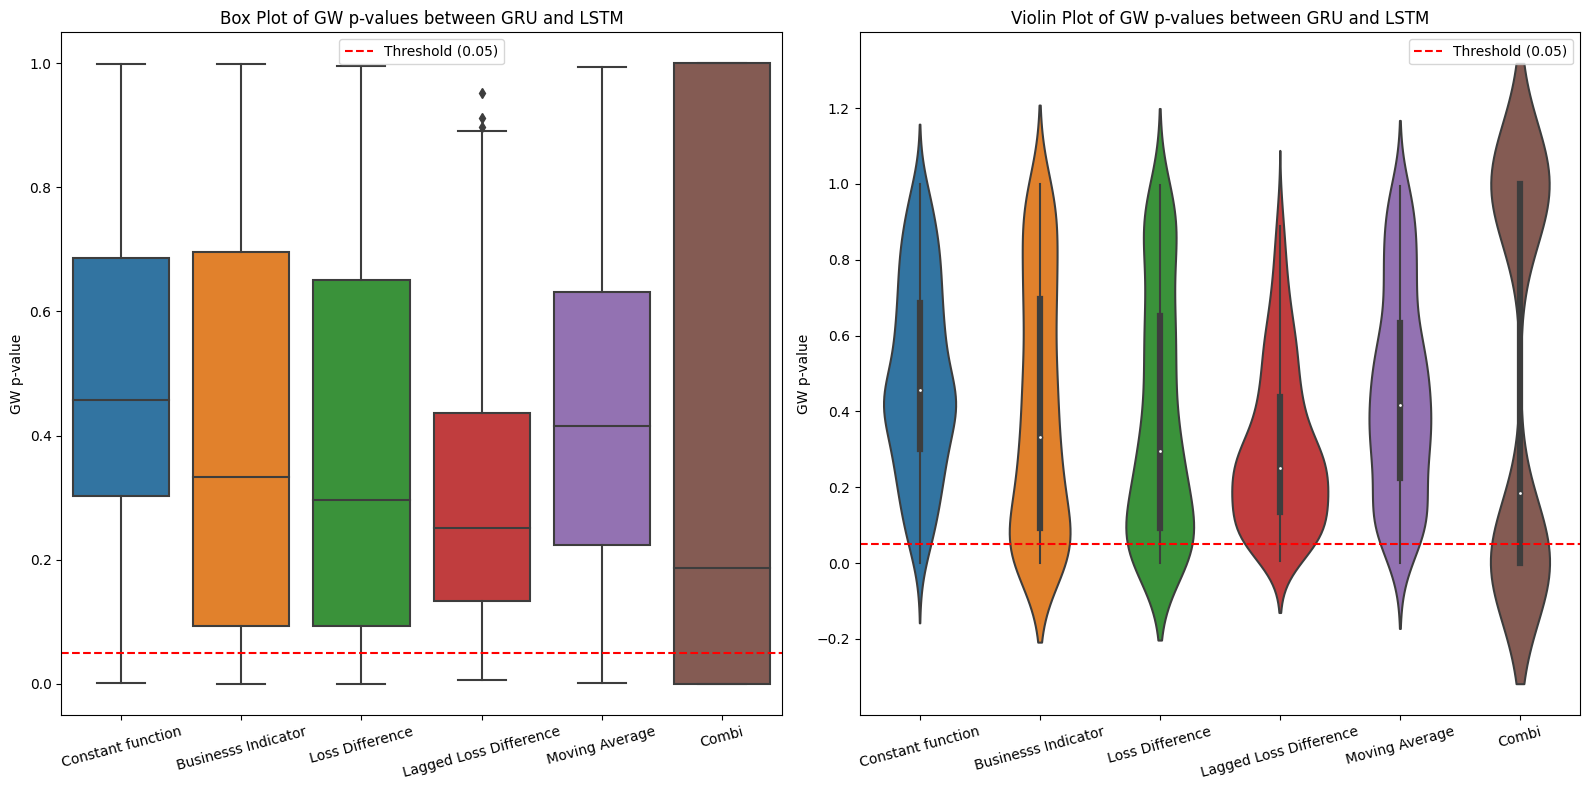

In [335]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Box Plot
sns.boxplot(data=p_values_arrays_GRUvsLSTM, ax=axes[0])
axes[0].axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
axes[0].set_xticks(np.arange(len(labels)))
axes[0].set_xticklabels(labels, rotation=15)
axes[0].set_ylabel('GW p-value')
axes[0].set_title('Box Plot of GW p-values between GRU and LSTM')
axes[0].legend()

# Violin Plot
sns.violinplot(data=p_values_arrays_GRUvsLSTM, ax=axes[1])
axes[1].axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
axes[1].set_xticks(np.arange(len(labels)))
axes[1].set_xticklabels(labels, rotation=15)
axes[1].set_ylabel('GW p-value')
axes[1].set_title('Violin Plot of GW p-values between GRU and LSTM')
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

In [271]:
# Initialize a list to store quartiles and median data
quartile_median_data = []

# Add quartiles and median annotations and store data
for i, label in enumerate(labels):
    data = p_values_arrays_GRUvsLSTM[i]
    quartiles = np.percentile(data, [25, 75])
    median = np.median(data)
    
    quartile_median_data.append([label, quartiles[0], quartiles[1], median])

# Display quartile and median data as a table
table = tabulate(quartile_median_data, headers=["Label", "Q1", "Q3", "Median"], tablefmt="pretty")
print(table)


+------------------------+---------------------+---------------------+---------------------+
|         Label          |         Q1          |         Q3          |       Median        |
+------------------------+---------------------+---------------------+---------------------+
|        Constant        | 0.30185520760697554 |  0.686385216866456  | 0.45657929563507554 |
|     Interest Rate      | 0.09296223253302358 | 0.6956039584121089  | 0.33283114701572647 |
|    Loss Difference     | 0.09335808915799934 | 0.6513475800885803  | 0.2966820134363656  |
| Lagged Loss Difference | 0.1340689521814779  | 0.43679822239362015 | 0.2509181207462102  |
|     Moving Average     | 0.2234377879038302  | 0.6319717690422758  | 0.41596081960213505 |
|         Combi          |         0.0         |         1.0         | 0.18612144945918602 |
+------------------------+---------------------+---------------------+---------------------+


### BiLSTM vs GRU

In [273]:
""" loss_values_BiLSTM_Sim = np.zeros((n_simulations, n_days - 5))

p_valueGRUvsBiLSTM_constant=np.empty(n_simulations)
p_valueBiLSTMvsGRU_interestrate=np.empty(n_simulations)
p_valueBiLSTMvsGRU_lossdifference=np.empty(n_simulations)
p_valueBiLSTMvsGRU_laggedloss=np.empty(n_simulations)
p_value_MA_BiLSTMvsGRU5=np.empty(n_simulations)
p_valueBiLSTMvsGRU_indicator_lossdifference=np.empty(n_simulations)

for i in range(n_simulations):
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))
    

    # BiLSTM
    for j in range(n_days - 5):
    
        lossBiLSTM = BiLSTM_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]
        loss_values_BiLSTM_Sim[i, j] = lossBiLSTM

    # Constant function
    Z_m_fixedGRUvsBiLSTM_constant=loss_values_BiLSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    Z_m_fixed_barGRUvsBiLSTM_constant=1/n *sum(Z_m_fixedGRUvsBiLSTM_constant)
    omegaGRUvsBiLSTM_constant= 1/n * sum(Z_m_fixedGRUvsBiLSTM_constant*Z_m_fixedGRUvsBiLSTM_constant)
    teststatGRUvsBiLSTM_constant=n*Z_m_fixed_barGRUvsBiLSTM_constant*1/omegaGRUvsBiLSTM_constant*Z_m_fixed_barGRUvsBiLSTM_constant
    # Compute the p-value
    p_valueGRUvsBiLSTM_constant[i] = 1 - chi2.cdf(teststatGRUvsBiLSTM_constant, 1)
    # Business cycle indicator
    DeltaGRUvsBiLSTM=(loss_values_BiLSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixedGRUvsBiLSTM_interestrate=h_t_indicator_1x398*(DeltaGRUvsBiLSTM)
    Z_m_fixedGRUvsBiLSTM_bar_interestrate=1/n *Z_m_fixedGRUvsBiLSTM_interestrate.sum().sum()
    omegaGRUvsBiLSTM_interestrate= 1/n * (Z_m_fixedGRUvsBiLSTM_interestrate*Z_m_fixedGRUvsBiLSTM_interestrate).sum().sum()
    teststatBiLSTMvsGRU_interestrate5=n*Z_m_fixedGRUvsBiLSTM_bar_interestrate*1/omegaGRUvsBiLSTM_interestrate*Z_m_fixedGRUvsBiLSTM_bar_interestrate
    # Compute the p-value
    p_valueBiLSTMvsGRU_interestrate[i]= 1 - chi2.cdf(teststatBiLSTMvsGRU_interestrate5, 1)
    #Loss difference test function
    h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    h_t_lossdifferenceBiLSTMvsGRU= np.insert(h_t_lossdifferenceBiLSTMvsGRU, 0, 0)
    h_t_lossdifferenceBiLSTMvsGRU=h_t_lossdifferenceBiLSTMvsGRU.reshape(1, -1)
    Z_m_fixed_BiLSTMvsGRU=h_t_lossdifferenceBiLSTMvsGRU[:, :-1]*(loss_values_BiLSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixed_bar_BiLSTMvsGRU=1/n *Z_m_fixed_BiLSTMvsGRU.sum()
    omegaBiLSTMvsGRU= 1/n * (Z_m_fixed_BiLSTMvsGRU*Z_m_fixed_BiLSTMvsGRU).sum()
    teststatBiLSTMvsGRU=n*Z_m_fixed_bar_BiLSTMvsGRU*1/omegaBiLSTMvsGRU*Z_m_fixed_bar_BiLSTMvsGRU
    # Compute the p-value
    p_valueBiLSTMvsGRU_lossdifference[i]= 1 - chi2.cdf(teststatBiLSTMvsGRU, 1)
    # Lagged loss difference
    h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    two_last_lossdifferenceBiLSTMvsGRU=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
    two_last_lossdifferenceBiLSTMvsGRU = two_last_lossdifferenceBiLSTMvsGRU.reshape((2,))
    h_t_lossdifferenceBiLSTMvsGRU= np.concatenate((two_last_lossdifferenceBiLSTMvsGRU, h_t_lossdifferenceBiLSTMvsGRU))
    h_t_lossdifferenceBiLSTMvsGRU_lagged = h_t_lossdifferenceBiLSTMvsGRU[1:]-h_t_lossdifferenceBiLSTMvsGRU[:-1]
    h_t_lossdifferenceBiLSTMvsGRU_lagged=h_t_lossdifferenceBiLSTMvsGRU_lagged[:-1].reshape(1, -1)
    Z_m_fixed_BiLSTMvsGRU_laggedloss=(h_t_lossdifferenceBiLSTMvsGRU_lagged)*(loss_values_BiLSTM-loss_values_GRU)
    Z_m_fixed_bar_BiLSTMvsGRU_laggedloss=1/n *Z_m_fixed_BiLSTMvsGRU_laggedloss.sum()
    omegaBiLSTMvsGRU_laggedloss= 1/n * (Z_m_fixed_BiLSTMvsGRU_laggedloss*Z_m_fixed_BiLSTMvsGRU_laggedloss).sum()
    teststatBiLSTMvsGRU_laggedloss=n*Z_m_fixed_bar_BiLSTMvsGRU_laggedloss*1/omegaBiLSTMvsGRU_laggedloss*Z_m_fixed_bar_BiLSTMvsGRU_laggedloss
    # Compute the p-value
    p_valueBiLSTMvsGRU_laggedloss[i]= 1 - chi2.cdf(teststatBiLSTMvsGRU_laggedloss, 1)

    # Moving Average
    lossdiffer_GRUvsBiLSTM=loss_values_BiLSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]
    three_last_lossdifferenceBiLSTMvsGRU=(train_target_pred_BiLSTM[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
    three_last_lossdifferenceBiLSTMvsGRU = three_last_lossdifferenceBiLSTMvsGRU.reshape((3,))
    lossdiffer_GRUvsBiLSTM= np.concatenate((three_last_lossdifferenceBiLSTMvsGRU, lossdiffer_GRUvsBiLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_BiLSTMvsGRU = []
    for m in range(k, len(lossdiffer_GRUvsBiLSTM)+1):
        sum_delta = sum(lossdiffer_GRUvsBiLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_BiLSTMvsGRU.append(ma)

    Z_m_fixed_MA_BiLSTMvsGRU5=h_t_MA_BiLSTMvsGRU[:-1]*(loss_values_BiLSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixed_MA_bar_BiLSTMvsGRU5=1/n *Z_m_fixed_MA_BiLSTMvsGRU5.sum()
    omegaBiLSTMvsGRU5= 1/n * (Z_m_fixed_MA_BiLSTMvsGRU5*Z_m_fixed_MA_BiLSTMvsGRU5).sum()
    teststatBiLSTMvsGRU5=n*Z_m_fixed_MA_bar_BiLSTMvsGRU5*1/omegaBiLSTMvsGRU5*Z_m_fixed_MA_bar_BiLSTMvsGRU5
    # Compute the p-value
    p_value_MA_BiLSTMvsGRU5[i]= 1 - chi2.cdf(teststatBiLSTMvsGRU5, 1) 

    
    # Combination of test functions
    h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM_Sim[i, :]-loss_values_GRU_Sim[i, :]

    h_t_lossdifferenceBiLSTMvsGRU= np.insert(h_t_lossdifferenceBiLSTMvsGRU, 0, 0)
    h_t_lossdifferenceBiLSTMvsGRU=h_t_lossdifferenceBiLSTMvsGRU.reshape(1, -1)
    

    h_t_indicator_lossdifferenceBiLSTMvsGRU=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsGRU[:, :-1]))

    DeltaBiLSTMvsGRU=(loss_values_BiLSTM_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixed_indicator_lossdifferenceBiLSTMvsGRU=h_t_indicator_lossdifferenceBiLSTMvsGRU*(DeltaBiLSTMvsGRU)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsGRU=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceBiLSTMvsGRU, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsGRU=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsGRU, (2, 1))
    omegaBiLSTMvsGRU_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceBiLSTMvsGRU@(Z_m_fixed_indicator_lossdifferenceBiLSTMvsGRU.T)
    teststatBiLSTMvsGRU_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsGRU.T)@(np.linalg.inv(omegaBiLSTMvsGRU_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsGRU
    # Compute the p-value
    p_valueBiLSTMvsGRU_indicator_lossdifference[i]= 1 - chi2.cdf(teststatBiLSTMvsGRU_indicator_lossdifference5, 2)

     """

In [274]:
""" # Specify the file path where you want to save the matrix
file_path = "loss_values_BiLSTM_Sim.pkl"

# Save the matrix to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(loss_values_BiLSTM_Sim, binary_file) """

In [275]:
# Load the data from the binary file
with open("loss_values_BiLSTM_Sim.pkl", "rb") as binary_file:
    loss_values_BiLSTM_Sim = pickle.load(binary_file)

In [266]:
""" # Specify the file path where you want to save the matrix
file_path = "loss_values_GRU_Sim.pkl"

# Save the matrix to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(loss_values_GRU_Sim, binary_file) """

' # Specify the file path where you want to save the matrix\nfile_path = "loss_values_GRU_Sim.pkl"\n\n# Save the matrix to the binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(loss_values_GRU_Sim, binary_file) '

In [262]:
# Load the data from the binary file
with open("loss_values_GRU_Sim.pkl", "rb") as binary_file:
    loss_values_GRU_Sim = pickle.load(binary_file)

In [268]:
""" # Specify the file path where you want to save the matrix
file_path = "Sim.pkl"

# Save the matrix to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(Sim, binary_file) """

' # Specify the file path where you want to save the matrix\nfile_path = "Sim.pkl"\n\n# Save the matrix to the binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(Sim, binary_file) '

In [259]:
# Load the data from the binary file
with open("Sim.pkl", "rb") as binary_file:
    Sim = pickle.load(binary_file)

In [276]:
""" 
p_values_arrays_BiLSTMvsGRU = [p_valueGRUvsBiLSTM_constant, p_valueBiLSTMvsGRU_interestrate, 
                   p_valueBiLSTMvsGRU_lossdifference, p_valueBiLSTMvsGRU_laggedloss, 
                   p_value_MA_BiLSTMvsGRU5, p_valueBiLSTMvsGRU_indicator_lossdifference] """

In [277]:
""" 
# Specify the file path where you want to save the array
file_path = "p_values_arrays_BiLSTMvsGRU.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(p_values_arrays_BiLSTMvsGRU, binary_file) """

In [278]:

# Load the data from the binary file
with open("p_values_arrays_BiLSTMvsGRU.pkl", "rb") as binary_file:
    p_values_arrays_BiLSTMvsGRU = pickle.load(binary_file)

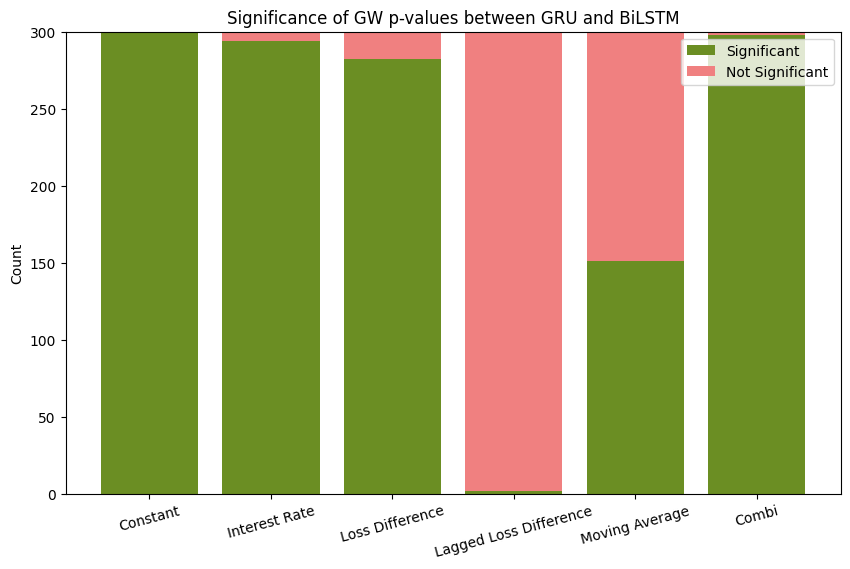

In [279]:
labels = ['Constant', 'Interest Rate', 
          'Loss Difference', 'Lagged Loss Difference', 
          'Moving Average', 'Combi']
significant = [np.sum(p_values <= 0.05) for p_values in p_values_arrays_BiLSTMvsGRU]
not_significant = [n_simulations - s for s in significant]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(significant)), significant, label='Significant', color='olivedrab')
plt.bar(np.arange(len(significant)), not_significant, bottom=significant, label='Not Significant', color='lightcoral')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('Count')
plt.title('Significance of GW p-values between GRU and BiLSTM')

plt.legend()
plt.show()


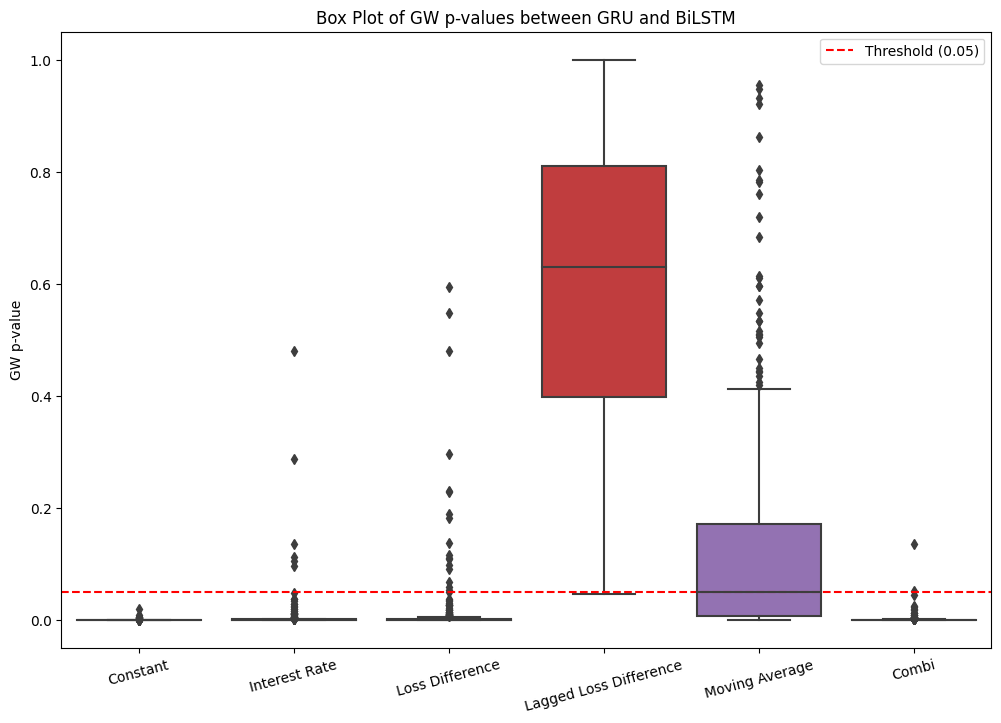

In [280]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_BiLSTMvsGRU)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('GW p-value')
plt.title('Box Plot of GW p-values between GRU and BiLSTM')

plt.legend()
plt.show()


In [281]:
# Initialize a list to store quartiles and median data
quartile_median_data = []

# Add quartiles and median annotations and store data
for i, label in enumerate(labels):
    data = p_values_arrays_BiLSTMvsGRU[i]
    quartiles = np.percentile(data, [25, 75])
    median = np.median(data)
    
    quartile_median_data.append([label, quartiles[0], quartiles[1], median])

# Display quartile and median data as a table
table = tabulate(quartile_median_data, headers=["Label", "Q1", "Q3", "Median"], tablefmt="pretty")
print(table)


+------------------------+------------------------+------------------------+------------------------+
|         Label          |           Q1           |           Q3           |         Median         |
+------------------------+------------------------+------------------------+------------------------+
|        Constant        | 3.0530349148794045e-07 | 5.231070791669734e-05  | 5.449660219314367e-06  |
|     Interest Rate      | 5.590789838305632e-07  | 0.0005884444544204392  | 2.5066446704025136e-05 |
|    Loss Difference     | 8.906715395745612e-06  |  0.001994787104404455  | 0.00017338166471658756 |
| Lagged Loss Difference |   0.3984457398906649   |   0.8102583189928316   |   0.6300623465909503   |
|     Moving Average     |  0.00719493878661015   |  0.17054010857791402   |  0.048839682069529544  |
|         Combi          | 2.476394112826963e-07  | 0.00022004290749141897 | 7.230007998293431e-06  |
+------------------------+------------------------+------------------------+------

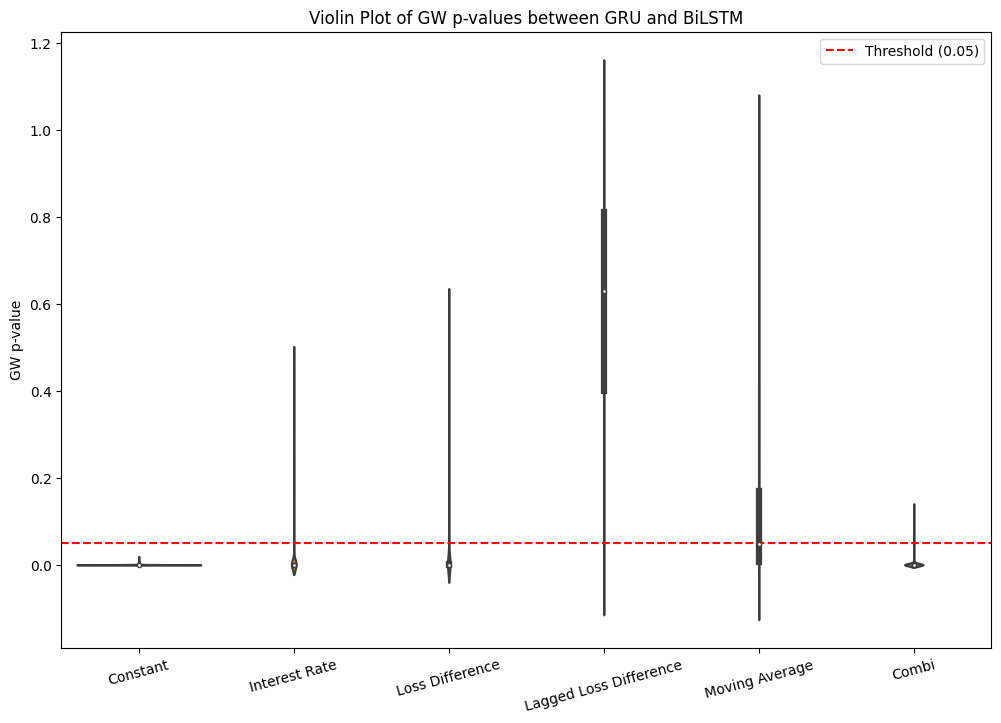

In [283]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=p_values_arrays_BiLSTMvsGRU)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('GW p-value')
plt.title('Violin Plot of GW p-values between GRU and BiLSTM')
plt.legend()
plt.show()

### GRU vs RNN

In [284]:
# Load the data from the binary file
with open("loss_values_RNN_Sim.pkl", "rb") as binary_file:
    loss_values_RNN_Sim = pickle.load(binary_file)

In [285]:
""" 
p_valueGRUvsRNN_constant=np.empty(n_simulations)
p_valueGRUvsRNN_interestrate=np.empty(n_simulations)
p_valueGRUvsRNN_lossdifference=np.empty(n_simulations)
p_valueGRUvsRNN_laggedloss=np.empty(n_simulations)
p_value_MA_GRUvsRNN=np.empty(n_simulations)
p_valueGRUvsRNN_indicator_lossdifference=np.empty(n_simulations)


for i in range(n_simulations):
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))
    

    # Constant function
    Z_m_fixedGRUvsRNN_constant=loss_values_RNN_Sim[i, :]-loss_values_GRU_Sim[i, :]
    Z_m_fixed_barGRUvsRNN_constant=1/n *sum(Z_m_fixedGRUvsRNN_constant)
    omegaGRUvsRNN_constant= 1/n * sum(Z_m_fixedGRUvsRNN_constant*Z_m_fixedGRUvsRNN_constant)
    teststatGRUvsRNN_constant=n*Z_m_fixed_barGRUvsRNN_constant*1/omegaGRUvsRNN_constant*Z_m_fixed_barGRUvsRNN_constant
    # Compute the p-value
    p_valueGRUvsRNN_constant[i] = 1 - chi2.cdf(teststatGRUvsRNN_constant, 1)

    # Business cycle indicator
    DeltaGRUvsRNN=(loss_values_RNN_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixedGRUvsRNN_interestrate=h_t_indicator_1x398*(DeltaGRUvsRNN)
    Z_m_fixedGRUvsRNN_bar_interestrate=1/n *Z_m_fixedGRUvsRNN_interestrate.sum().sum()
    omegaGRUvsRNN_interestrate= 1/n * (Z_m_fixedGRUvsRNN_interestrate*Z_m_fixedGRUvsRNN_interestrate).sum().sum()
    teststatGRUvsRNN_interestrate5=n*Z_m_fixedGRUvsRNN_bar_interestrate*1/omegaGRUvsRNN_interestrate*Z_m_fixedGRUvsRNN_bar_interestrate
    # Compute the p-value
    p_valueGRUvsRNN_interestrate[i]= 1 - chi2.cdf(teststatGRUvsRNN_interestrate5, 1)

    #Loss difference test function
    h_t_lossdifferenceGRUvsRNN=loss_values_RNN_Sim[i, :]-loss_values_GRU_Sim[i, :]
    h_t_lossdifferenceGRUvsRNN= np.insert(h_t_lossdifferenceGRUvsRNN, 0, 0)
    h_t_lossdifferenceGRUvsRNN=h_t_lossdifferenceGRUvsRNN.reshape(1, -1)
    Z_m_fixed_GRUvsRNN=h_t_lossdifferenceGRUvsRNN[:, :-1]*(loss_values_GRU_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_bar_GRUvsRNN=1/n *Z_m_fixed_GRUvsRNN.sum()
    omegaGRUvsRNN= 1/n * (Z_m_fixed_GRUvsRNN*Z_m_fixed_GRUvsRNN).sum()
    teststatGRUvsRNN=n*Z_m_fixed_bar_GRUvsRNN*1/omegaGRUvsRNN*Z_m_fixed_bar_GRUvsRNN

    # Compute the p-value
    p_valueGRUvsRNN_lossdifference[i]= 1 - chi2.cdf(teststatGRUvsRNN, 1)


    
    # Lagged loss difference
    h_t_lossdifferenceGRUvsRNN=loss_values_RNN_Sim[i, :]-loss_values_GRU_Sim[i, :]
    two_last_lossdifferenceGRUvsRNN=(train_target_pred_rnn[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
    two_last_lossdifferenceGRUvsRNN = two_last_lossdifferenceGRUvsRNN.reshape((2,))
    h_t_lossdifferenceGRUvsRNN= np.concatenate((two_last_lossdifferenceGRUvsRNN, h_t_lossdifferenceGRUvsRNN))
    h_t_lossdifferenceGRUvsRNN_lagged = h_t_lossdifferenceGRUvsRNN[1:]-h_t_lossdifferenceGRUvsRNN[:-1]
    h_t_lossdifferenceGRUvsRNN_lagged=h_t_lossdifferenceGRUvsRNN_lagged[:-1].reshape(1, -1)
    Z_m_fixed_GRUvsRNN_laggedloss=(h_t_lossdifferenceGRUvsRNN_lagged)*(loss_values_RNN-loss_values_GRU)
    Z_m_fixed_bar_GRUvsRNN_laggedloss=1/n *Z_m_fixed_GRUvsRNN_laggedloss.sum()
    omegaGRUvsRNN_laggedloss= 1/n * (Z_m_fixed_GRUvsRNN_laggedloss*Z_m_fixed_GRUvsRNN_laggedloss).sum()
    teststatGRUvsRNN_laggedloss=n*Z_m_fixed_bar_GRUvsRNN_laggedloss*1/omegaGRUvsRNN_laggedloss*Z_m_fixed_bar_GRUvsRNN_laggedloss
    # Compute the p-value
    p_valueGRUvsRNN_laggedloss[i]= 1 - chi2.cdf(teststatGRUvsRNN_laggedloss, 1)

    # Moving Average
    lossdiffer_GRUvsRNN=loss_values_RNN_Sim[i, :]-loss_values_GRU_Sim[i, :]
    three_last_lossdifferenceGRUvsRNN=(train_target_pred_rnn[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
    three_last_lossdifferenceGRUvsRNN = three_last_lossdifferenceGRUvsRNN.reshape((3,))
    lossdiffer_GRUvsRNN= np.concatenate((three_last_lossdifferenceGRUvsRNN, lossdiffer_GRUvsRNN))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_GRUvsRNN = []
    for m in range(k, len(lossdiffer_GRUvsRNN)+1):
        sum_delta = sum(lossdiffer_GRUvsRNN[m-k:m])
        ma = sum_delta / k
        h_t_MA_GRUvsRNN.append(ma)

    Z_m_fixed_MA_GRUvsRNN=h_t_MA_GRUvsRNN[:-1]*(loss_values_RNN_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixed_MA_bar_GRUvsRNN=1/n *Z_m_fixed_MA_GRUvsRNN.sum()
    omegaGRUvsRNN= 1/n * (Z_m_fixed_MA_GRUvsRNN*Z_m_fixed_MA_GRUvsRNN).sum()
    teststatGRUvsRNN=n*Z_m_fixed_MA_bar_GRUvsRNN*1/omegaGRUvsRNN*Z_m_fixed_MA_bar_GRUvsRNN
    # Compute the p-value
    p_value_MA_GRUvsRNN[i]= 1 - chi2.cdf(teststatGRUvsRNN, 1) 

    
    # Combination of test functions
    h_t_lossdifferenceGRUvsRNN=loss_values_RNN_Sim[i, :]-loss_values_GRU_Sim[i, :]

    h_t_lossdifferenceGRUvsRNN= np.insert(h_t_lossdifferenceGRUvsRNN, 0, 0)
    h_t_lossdifferenceGRUvsRNN=h_t_lossdifferenceGRUvsRNN.reshape(1, -1)
    

    h_t_indicator_lossdifferenceGRUvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceGRUvsRNN[:, :-1]))

    DeltaGRUvsRNN=(loss_values_RNN_Sim[i, :]-loss_values_GRU_Sim[i, :])
    Z_m_fixed_indicator_lossdifferenceGRUvsRNN=h_t_indicator_lossdifferenceGRUvsRNN*(DeltaGRUvsRNN)
    Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceGRUvsRNN, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN, (2, 1))
    omegaGRUvsRNN_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceGRUvsRNN@(Z_m_fixed_indicator_lossdifferenceGRUvsRNN.T)
    teststatGRUvsRNN_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN.T)@(np.linalg.inv(omegaGRUvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN
    # Compute the p-value
    p_valueGRUvsRNN_indicator_lossdifference[i]= 1 - chi2.cdf(teststatGRUvsRNN_indicator_lossdifference5, 2)


     """

In [277]:
""" 
# Specify the file path where you want to save the array
file_path = "loss_values_RNN_Sim.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(loss_values_RNN_Sim, binary_file) 

 """

' \n# Specify the file path where you want to save the array\nfile_path = "loss_values_RNN_Sim.pkl"\n\n# Save the array to the binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(loss_values_RNN_Sim, binary_file) \n\n '

In [286]:
""" p_values_arrays_RNNvsGRU = [p_valueGRUvsRNN_constant, p_valueGRUvsRNN_interestrate, 
                   p_valueGRUvsRNN_lossdifference, p_valueGRUvsRNN_laggedloss, 
                   p_value_MA_GRUvsRNN, p_valueGRUvsRNN_indicator_lossdifference]
 """

In [287]:
""" 
# Specify the file path where you want to save the array
file_path = "p_values_arrays_RNNvsGRU.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(p_values_arrays_RNNvsGRU, binary_file) 
 """

In [288]:

# Load the data from the binary file
with open("p_values_arrays_RNNvsGRU.pkl", "rb") as binary_file:
    p_values_arrays_RNNvsGRU = pickle.load(binary_file)

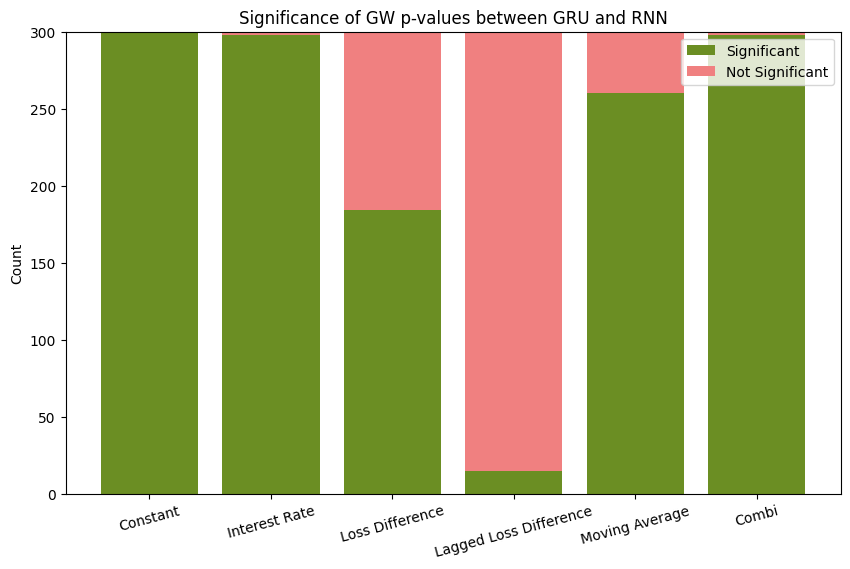

In [289]:
labels = ['Constant', 'Interest Rate', 
          'Loss Difference', 'Lagged Loss Difference', 
          'Moving Average', 'Combi']




significant = [np.sum(p_values <= 0.05) for p_values in p_values_arrays_RNNvsGRU]
not_significant = [n_simulations - s for s in significant]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(significant)), significant, label='Significant', color='olivedrab')
plt.bar(np.arange(len(significant)), not_significant, bottom=significant, label='Not Significant', color='lightcoral')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('Count')
plt.title('Significance of GW p-values between GRU and RNN')
plt.legend()
plt.show()


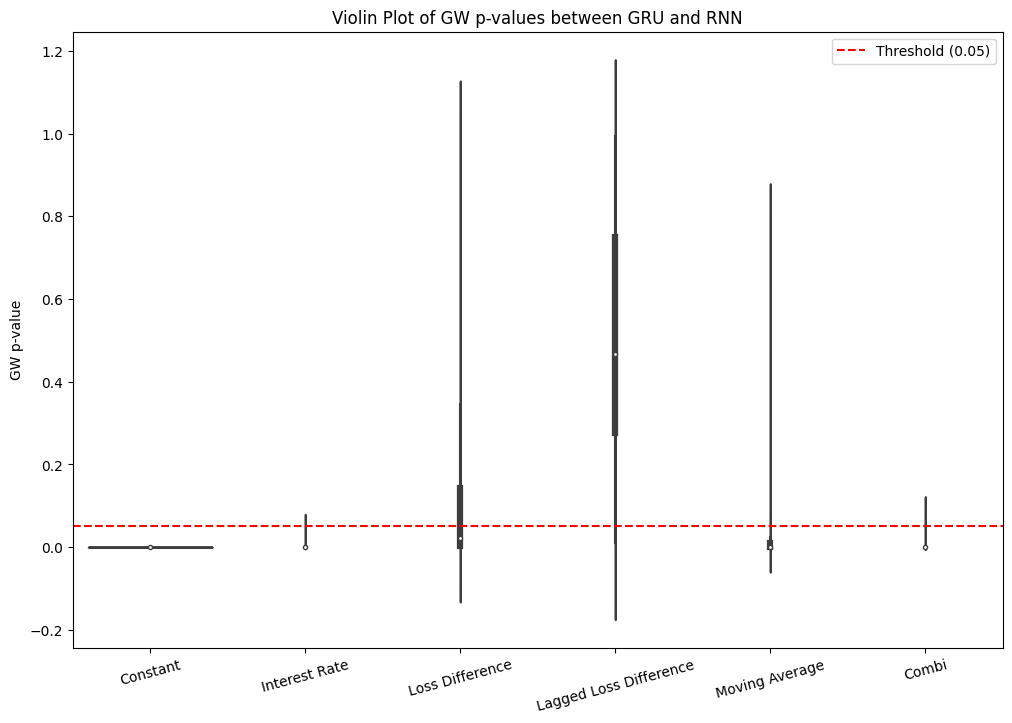

In [290]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=p_values_arrays_RNNvsGRU)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('GW p-value')
plt.title('Violin Plot of GW p-values between GRU and RNN')
plt.legend()
plt.show()

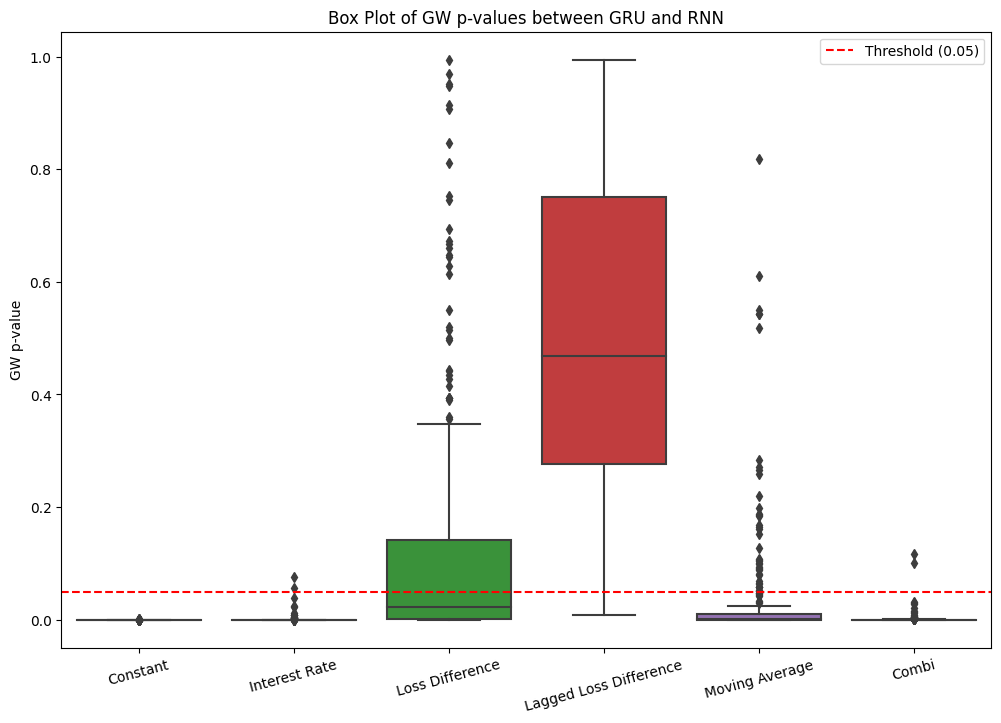

In [291]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_RNNvsGRU)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('GW p-value')
plt.title('Box Plot of GW p-values between GRU and RNN')

plt.legend()
plt.show()


In [292]:
# Initialize a list to store quartiles and median data
quartile_median_data = []

# Add quartiles and median annotations and store data
for i, label in enumerate(labels):
    data = p_values_arrays_RNNvsGRU[i]
    quartiles = np.percentile(data, [25, 75])
    median = np.median(data)
    
    quartile_median_data.append([label, quartiles[0], quartiles[1], median])

# Display quartile and median data as a table
table = tabulate(quartile_median_data, headers=["Label", "Q1", "Q3", "Median"], tablefmt="pretty")
print(table)


+------------------------+------------------------+------------------------+------------------------+
|         Label          |           Q1           |           Q3           |         Median         |
+------------------------+------------------------+------------------------+------------------------+
|        Constant        | 6.711292632743948e-11  | 1.0071637679409662e-07 | 2.5658974944775537e-09 |
|     Interest Rate      | 2.0520728585826653e-07 | 8.210613048489912e-05  | 5.275505425006433e-06  |
|    Loss Difference     |  0.002113962187616447  |  0.14236845221399835   |  0.02208013642205353   |
| Lagged Loss Difference |   0.2766683705389177   |   0.7509210811658685   |  0.46807255170098366   |
|     Moving Average     | 5.948795626373182e-05  |  0.009873219503417907  | 0.0009248713079506587  |
|         Combi          | 7.285719090532883e-07  | 0.00020212940011229974 | 1.591500379699573e-05  |
+------------------------+------------------------+------------------------+------

###  LSTM vs RNN

In [293]:
# Load the data from the binary file
with open("loss_values_LSTM_Sim.pkl", "rb") as binary_file:
    loss_values_LSTM_Sim = pickle.load(binary_file)

In [294]:
""" 
p_valueRNNvsLSTM_constant=np.empty(n_simulations)
p_valueLSTMvsRNN_interestrate=np.empty(n_simulations)
p_valueLSTMvsRNN_lossdifference=np.empty(n_simulations)
p_valueLSTMvsRNN_laggedloss=np.empty(n_simulations)
p_value_MA_LSTMvsRNN=np.empty(n_simulations)
p_valueRNNvsLSTM_indicator_lossdifference=np.empty(n_simulations)

for i in range(n_simulations):
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))

    # Constant function
    Z_m_fixedRNNvsLSTM_constant=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    Z_m_fixed_barRNNvsLSTM_constant=1/n *sum(Z_m_fixedRNNvsLSTM_constant)
    omegaRNNvsLSTM_constant= 1/n * sum(Z_m_fixedRNNvsLSTM_constant*Z_m_fixedRNNvsLSTM_constant)
    teststatRNNvsLSTM_constant=n*Z_m_fixed_barRNNvsLSTM_constant*1/omegaRNNvsLSTM_constant*Z_m_fixed_barRNNvsLSTM_constant
    # Compute the p-value
    p_valueRNNvsLSTM_constant[i] = 1 - chi2.cdf(teststatRNNvsLSTM_constant, 1)



    
    # Business cycle indicator
    DeltaRNNsLSTM=(loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixedRNNvsLSTM_interestrate=h_t_indicator_1x398*(DeltaRNNsLSTM)
    Z_m_fixedRNNvsLSTM_bar_interestrate=1/n *Z_m_fixedRNNvsLSTM_interestrate.sum().sum()
    omegaRNNvsLSTM_interestrate= 1/n * (Z_m_fixedRNNvsLSTM_interestrate*Z_m_fixedRNNvsLSTM_interestrate).sum().sum()
    teststatLSTMvsRNN_interestrate5=n*Z_m_fixedRNNvsLSTM_bar_interestrate*1/omegaRNNvsLSTM_interestrate*Z_m_fixedRNNvsLSTM_bar_interestrate
    # Compute the p-value
    p_valueLSTMvsRNN_interestrate[i]= 1 - chi2.cdf(teststatLSTMvsRNN_interestrate5, 1)
    
    
    #Loss difference test function
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
    h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)
    Z_m_fixed_LSTMvsRNN=h_t_lossdifferenceLSTMvsRNN[:, :-1]*(loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_bar_LSTMvsRNN=1/n *Z_m_fixed_LSTMvsRNN.sum()
    omegaLSTMvsRNN= 1/n * (Z_m_fixed_LSTMvsRNN*Z_m_fixed_LSTMvsRNN).sum()
    teststatLSTMvsRNN=n*Z_m_fixed_bar_LSTMvsRNN*1/omegaLSTMvsRNN*Z_m_fixed_bar_LSTMvsRNN
    # Compute the p-value
    p_valueLSTMvsRNN_lossdifference[i]= 1 - chi2.cdf(teststatLSTMvsRNN, 1)

    # Lagged loss difference
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    two_last_lossdifferenceLSTMvsRNN=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_rnn[-2:].T-train_target[-2:])
    two_last_lossdifferenceLSTMvsRNN = two_last_lossdifferenceLSTMvsRNN.reshape((2,))
    h_t_lossdifferenceLSTMvsRNN= np.concatenate((two_last_lossdifferenceLSTMvsRNN, h_t_lossdifferenceLSTMvsRNN))
    h_t_lossdifferenceLSTMvsRNN_lagged = h_t_lossdifferenceLSTMvsRNN[1:]-h_t_lossdifferenceLSTMvsRNN[:-1]
    h_t_lossdifferenceLSTMvsRNN_lagged=h_t_lossdifferenceLSTMvsRNN_lagged[:-1].reshape(1, -1)
    Z_m_fixed_LSTMvsRNN_laggedloss=(h_t_lossdifferenceLSTMvsRNN_lagged)*(loss_values_LSTM-loss_values_RNN)
    Z_m_fixed_bar_LSTMvsRNN_laggedloss=1/n *Z_m_fixed_LSTMvsRNN_laggedloss.sum()
    omegaLSTMvsRNN_laggedloss= 1/n * (Z_m_fixed_LSTMvsRNN_laggedloss*Z_m_fixed_LSTMvsRNN_laggedloss).sum()
    teststatLSTMvsRNN_laggedloss=n*Z_m_fixed_bar_LSTMvsRNN_laggedloss*1/omegaLSTMvsRNN_laggedloss*Z_m_fixed_bar_LSTMvsRNN_laggedloss
    # Compute the p-value
    p_valueLSTMvsRNN_laggedloss[i]= 1 - chi2.cdf(teststatLSTMvsRNN_laggedloss, 1)

    
    # Moving Average
    lossdiffer_RNNvsLSTM=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    three_last_lossdifferenceLSTMvsRNN=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_rnn[-3:].T-train_target[-3:])
    three_last_lossdifferenceLSTMvsRNN = three_last_lossdifferenceLSTMvsRNN.reshape((3,))
    lossdiffer_RNNvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsRNN, lossdiffer_RNNvsLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_LSTMvsRNN = []
    for m in range(k, len(lossdiffer_RNNvsLSTM)+1):
        sum_delta = sum(lossdiffer_RNNvsLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_LSTMvsRNN.append(ma)

    Z_m_fixed_MA_LSTMvsRNN=h_t_MA_LSTMvsRNN[:-1]*(loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_MA_bar_LSTMvsRNN=1/n *Z_m_fixed_MA_LSTMvsRNN.sum()
    omegaLSTMvsRNN= 1/n * (Z_m_fixed_MA_LSTMvsRNN*Z_m_fixed_MA_LSTMvsRNN).sum()
    teststatLSTMvsRNN=n*Z_m_fixed_MA_bar_LSTMvsRNN*1/omegaLSTMvsRNN*Z_m_fixed_MA_bar_LSTMvsRNN
    # Compute the p-value
    p_value_MA_LSTMvsRNN[i]= 1 - chi2.cdf(teststatLSTMvsRNN, 1)


    # Combination of test functions
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
    h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)

    h_t_indicator_lossdifferenceLSTMvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsRNN[:, :-1]))

    DeltaLSTMvsRNN=(loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_indicator_lossdifferenceLSTMvsRNN=h_t_indicator_lossdifferenceLSTMvsRNN*(DeltaLSTMvsRNN)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN, (2, 1))
    omegaLSTMvsRNN_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceLSTMvsRNN@(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN.T)
    teststatLSTMvsRNN_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN.T)@(np.linalg.inv(omegaLSTMvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN
    # Compute the p-value
    p_valueRNNvsLSTM_indicator_lossdifference[i]= 1 - chi2.cdf(teststatLSTMvsRNN_indicator_lossdifference5, 2)
     """

In [286]:
""" 
# Specify the file path where you want to save the array
file_path = "loss_values_LSTM_Sim.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(loss_values_LSTM_Sim, binary_file) 

 """

' \n# Specify the file path where you want to save the array\nfile_path = "loss_values_LSTM_Sim.pkl"\n\n# Save the array to the binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(loss_values_LSTM_Sim, binary_file) \n\n '

In [295]:
""" p_values_arrays_LSTMvsRNN = [p_valueRNNvsLSTM_constant, p_valueLSTMvsRNN_interestrate, 
                   p_valueLSTMvsRNN_lossdifference, p_valueLSTMvsRNN_laggedloss, 
                   p_value_MA_LSTMvsRNN, p_valueRNNvsLSTM_indicator_lossdifference]
 """

In [296]:
""" 
# Specify the file path where you want to save the array
file_path = "p_values_arrays_LSTMvsRNN.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(p_values_arrays_LSTMvsRNN, binary_file) 
 """

In [297]:
# Load the data from the binary file
with open("p_values_arrays_LSTMvsRNN.pkl", "rb") as binary_file:
    p_values_arrays_LSTMvsRNN = pickle.load(binary_file)

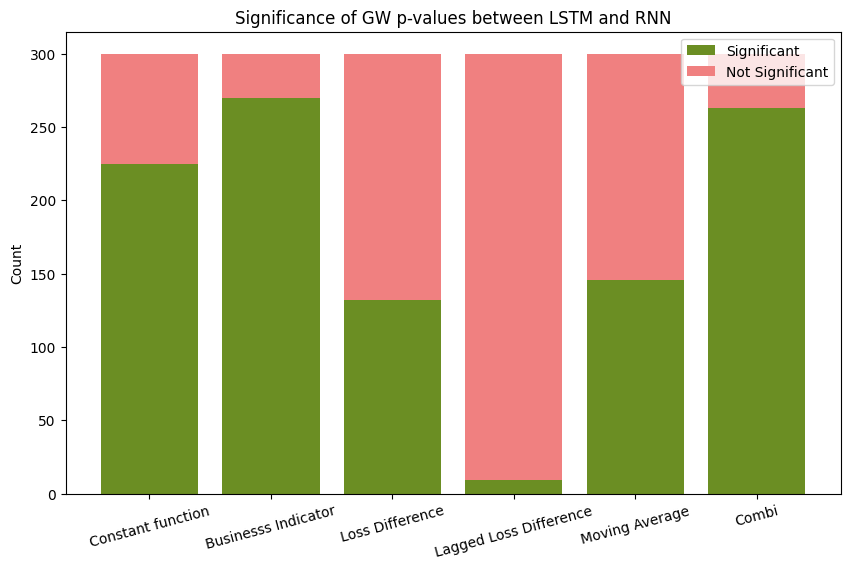

In [298]:

labels = ['Constant function', 'Businesss Indicator', 
          'Loss Difference', 'Lagged Loss Difference', 
          'Moving Average', 'Combi']


significant = [np.sum(p_values <= 0.05) for p_values in p_values_arrays_LSTMvsRNN]
not_significant = [n_simulations - s for s in significant]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(significant)), significant, label='Significant', color='olivedrab')
plt.bar(np.arange(len(significant)), not_significant, bottom=significant, label='Not Significant', color='lightcoral')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('Count')
plt.title('Significance of GW p-values between LSTM and RNN')
plt.legend()
plt.show()


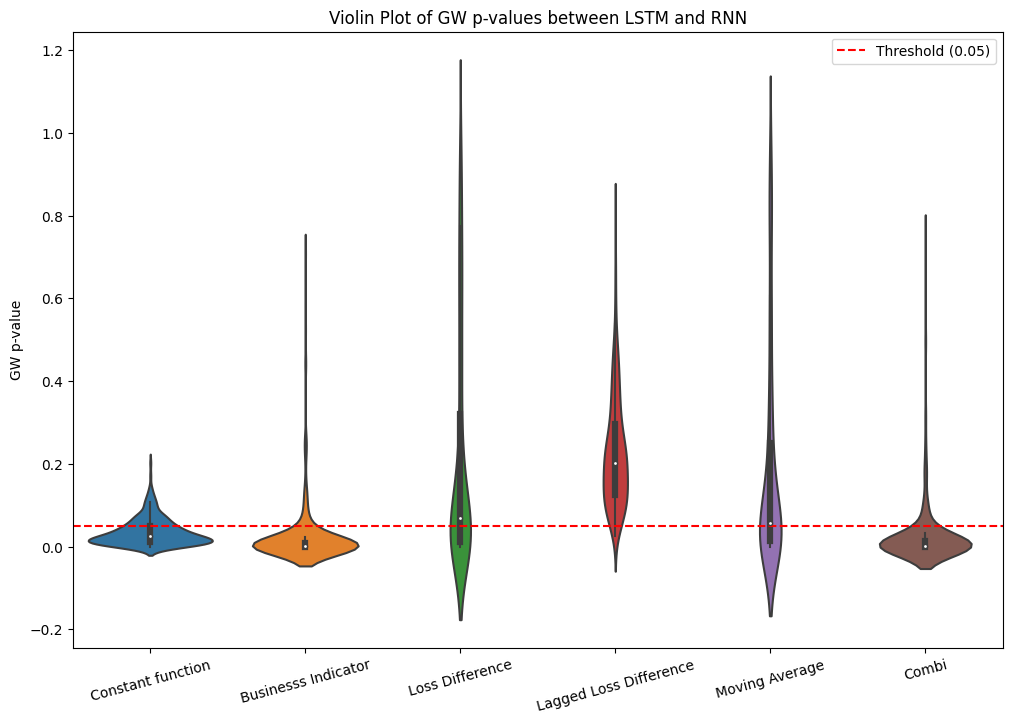

In [299]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=p_values_arrays_LSTMvsRNN)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('GW p-value')
plt.title('Violin Plot of GW p-values between LSTM and RNN')
plt.legend()
plt.show()

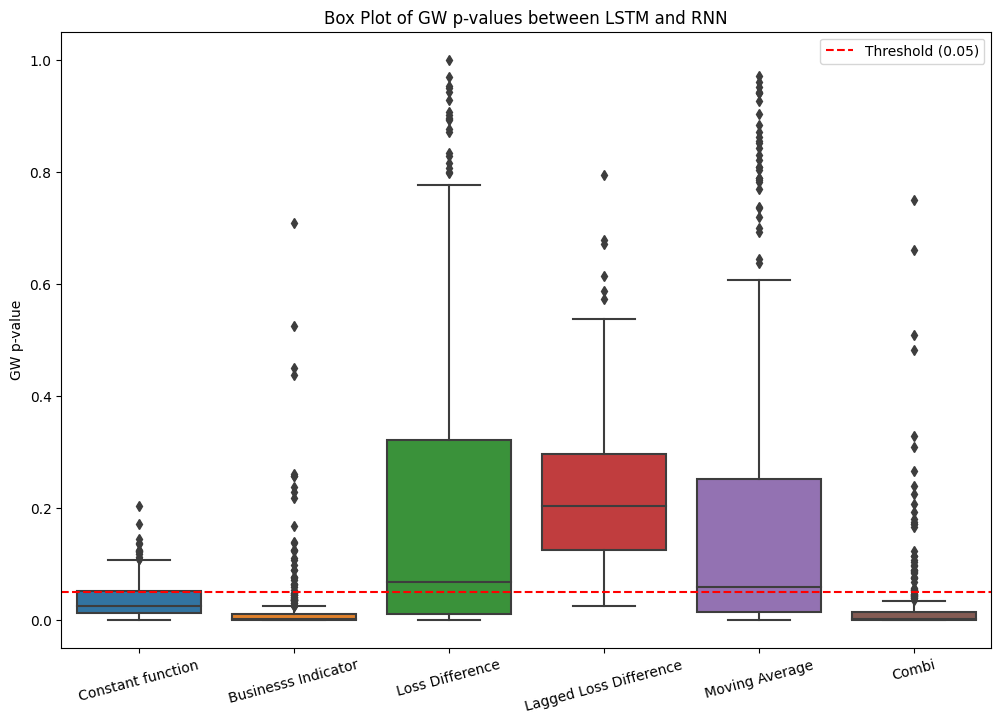

In [300]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_LSTMvsRNN)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('GW p-value')
plt.title('Box Plot of GW p-values between LSTM and RNN')

plt.legend()
plt.show()


In [301]:
# Initialize a list to store quartiles and median data
quartile_median_data = []

# Add quartiles and median annotations and store data
for i, label in enumerate(labels):
    data = p_values_arrays_LSTMvsRNN[i]
    quartiles = np.percentile(data, [25, 75])
    median = np.median(data)
    
    quartile_median_data.append([label, quartiles[0], quartiles[1], median])

# Display quartile and median data as a table
table = tabulate(quartile_median_data, headers=["Label", "Q1", "Q3", "Median"], tablefmt="pretty")
print(table)


+------------------------+------------------------+----------------------+-----------------------+
|         Label          |           Q1           |          Q3          |        Median         |
+------------------------+------------------------+----------------------+-----------------------+
|   Constant function    |  0.011583100589358353  | 0.05034816274462528  | 0.025031670034609543  |
|  Businesss Indicator   | 4.6233480301666185e-05 | 0.009648712942645438 | 0.0006010438984296873 |
|    Loss Difference     |  0.010338645779151251  |   0.32042538139406   |  0.06795450109761719  |
| Lagged Loss Difference |  0.12382345505853468   | 0.29633178892129247  |  0.20284342103682917  |
|     Moving Average     |  0.01288454684182505   |  0.2513046772595262  | 0.057732887737749095  |
|         Combi          | 7.782605628101069e-05  | 0.013615217554816428 | 0.0008663381204666587 |
+------------------------+------------------------+----------------------+-----------------------+


In [294]:
""" # Lagged loss when I added 2 number 0 instead of the true values
Sim = np.zeros((n_simulations, n_days))
loss_values_LSTM_Sim = np.zeros((n_simulations, n_days - 5))
loss_values_RNN_Sim = np.zeros((n_simulations, n_days - 5))

p_valueRNNvsLSTM_constant=np.empty(n_simulations)
p_valueLSTMvsRNN_interestrate=np.empty(n_simulations)
p_valueLSTMvsRNN_lossdifference=np.empty(n_simulations)
p_valueLSTMvsRNN_laggedloss=np.empty(n_simulations)
p_value_MA_LSTMvsRNN=np.empty(n_simulations)
p_valueRNNvsLSTM_indicator_lossdifference=np.empty(n_simulations)

for i in range(n_simulations):
    Sim[i, :] = fgbm_paths[i, :]
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))

    # LSTM
    for j in range(n_days - 5):
    
        loss = LSTM_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]
        loss_values_LSTM_Sim[i, j] = loss

    #GRU
    for j in range(n_days - 5):
        loss = RNN_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]
        loss_values_RNN_Sim[i, j] = loss



    # Constant function
    Z_m_fixedRNNvsLSTM_constant=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    Z_m_fixed_barRNNvsLSTM_constant=1/n *sum(Z_m_fixedRNNvsLSTM_constant)
    omegaRNNvsLSTM_constant= 1/n * sum(Z_m_fixedRNNvsLSTM_constant*Z_m_fixedRNNvsLSTM_constant)
    teststatRNNvsLSTM_constant=n*Z_m_fixed_barRNNvsLSTM_constant*1/omegaRNNvsLSTM_constant*Z_m_fixed_barRNNvsLSTM_constant
    # Compute the p-value
    p_valueRNNvsLSTM_constant[i] = 1 - chi2.cdf(teststatRNNvsLSTM_constant, 1)



    
    # Business cycle indicator
    DeltaRNNsLSTM=(loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixedRNNvsLSTM_interestrate=h_t_indicator_1x398*(DeltaRNNsLSTM)
    Z_m_fixedRNNvsLSTM_bar_interestrate=1/n *Z_m_fixedRNNvsLSTM_interestrate.sum().sum()
    omegaRNNvsLSTM_interestrate= 1/n * (Z_m_fixedRNNvsLSTM_interestrate*Z_m_fixedRNNvsLSTM_interestrate).sum().sum()
    teststatLSTMvsRNN_interestrate5=n*Z_m_fixedRNNvsLSTM_bar_interestrate*1/omegaRNNvsLSTM_interestrate*Z_m_fixedRNNvsLSTM_bar_interestrate
    # Compute the p-value
    p_valueLSTMvsRNN_interestrate[i]= 1 - chi2.cdf(teststatLSTMvsRNN_interestrate5, 1)
    
    
    #Loss difference test function
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
    h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)
    Z_m_fixed_LSTMvsRNN=h_t_lossdifferenceLSTMvsRNN[:, :-1]*(loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_bar_LSTMvsRNN=1/n *Z_m_fixed_LSTMvsRNN.sum()
    omegaLSTMvsRNN= 1/n * (Z_m_fixed_LSTMvsRNN*Z_m_fixed_LSTMvsRNN).sum()
    teststatLSTMvsRNN=n*Z_m_fixed_bar_LSTMvsRNN*1/omegaLSTMvsRNN*Z_m_fixed_bar_LSTMvsRNN
    # Compute the p-value
    p_valueLSTMvsRNN_lossdifference[i]= 1 - chi2.cdf(teststatLSTMvsRNN, 1)

    # Lagged loss difference
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    h_t_lossdifferenceLSTMvsRNN = np.insert(h_t_lossdifferenceLSTMvsRNN, 0, [0, 0])

    h_t_lossdifferenceLSTMvsRNN_lagged = h_t_lossdifferenceLSTMvsRNN[1:]-h_t_lossdifferenceLSTMvsRNN[:-1]
    h_t_lossdifferenceLSTMvsRNN_lagged=h_t_lossdifferenceLSTMvsRNN_lagged[:-1].reshape(1, -1)
    Z_m_fixed_LSTMvsRNN_laggedloss=(h_t_lossdifferenceLSTMvsRNN_lagged)*(loss_values_LSTM-loss_values_RNN)
    Z_m_fixed_bar_LSTMvsRNN_laggedloss=1/n *Z_m_fixed_LSTMvsRNN_laggedloss.sum()
    omegaLSTMvsRNN_laggedloss= 1/n * (Z_m_fixed_LSTMvsRNN_laggedloss*Z_m_fixed_LSTMvsRNN_laggedloss).sum()
    teststatLSTMvsRNN_laggedloss=n*Z_m_fixed_bar_LSTMvsRNN_laggedloss*1/omegaLSTMvsRNN_laggedloss*Z_m_fixed_bar_LSTMvsRNN_laggedloss
    # Compute the p-value
    p_valueLSTMvsRNN_laggedloss[i]= 1 - chi2.cdf(teststatLSTMvsRNN_laggedloss, 1)

    
    # Moving Average
    lossdiffer_RNNvsLSTM=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    three_last_lossdifferenceLSTMvsRNN=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_rnn[-3:].T-train_target[-3:])
    three_last_lossdifferenceLSTMvsRNN = three_last_lossdifferenceLSTMvsRNN.reshape((3,))
    lossdiffer_RNNvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsRNN, lossdiffer_RNNvsLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_LSTMvsRNN = []
    for m in range(k, len(lossdiffer_RNNvsLSTM)+1):
        sum_delta = sum(lossdiffer_RNNvsLSTM[m-k:i])
        ma = sum_delta / k
        h_t_MA_LSTMvsRNN.append(ma)

    Z_m_fixed_MA_LSTMvsRNN=h_t_MA_LSTMvsRNN[:-1]*(loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_MA_bar_LSTMvsRNN=1/n *Z_m_fixed_MA_LSTMvsRNN.sum()
    omegaLSTMvsRNN= 1/n * (Z_m_fixed_MA_LSTMvsRNN*Z_m_fixed_MA_LSTMvsRNN).sum()
    teststatLSTMvsRNN=n*Z_m_fixed_MA_bar_LSTMvsRNN*1/omegaLSTMvsRNN*Z_m_fixed_MA_bar_LSTMvsRNN
    # Compute the p-value
    p_value_MA_LSTMvsRNN[i]= 1 - chi2.cdf(teststatLSTMvsRNN, 1)


    # Combination of test functions
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
    h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)

    h_t_indicator_lossdifferenceLSTMvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsRNN[:, :-1]))

    DeltaLSTMvsRNN=(loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_indicator_lossdifferenceLSTMvsRNN=h_t_indicator_lossdifferenceLSTMvsRNN*(DeltaLSTMvsRNN)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN, (2, 1))
    omegaLSTMvsRNN_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceLSTMvsRNN@(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN.T)
    teststatLSTMvsRNN_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN.T)@(np.linalg.inv(omegaLSTMvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN
    # Compute the p-value
    p_valueRNNvsLSTM_indicator_lossdifference[i]= 1 - chi2.cdf(teststatLSTMvsRNN_indicator_lossdifference5, 2)
     """

' # Lagged loss when I added 2 number 0 instead of the true values\nSim = np.zeros((n_simulations, n_days))\nloss_values_LSTM_Sim = np.zeros((n_simulations, n_days - 5))\nloss_values_RNN_Sim = np.zeros((n_simulations, n_days - 5))\n\np_valueRNNvsLSTM_constant=np.empty(n_simulations)\np_valueLSTMvsRNN_interestrate=np.empty(n_simulations)\np_valueLSTMvsRNN_lossdifference=np.empty(n_simulations)\np_valueLSTMvsRNN_laggedloss=np.empty(n_simulations)\np_value_MA_LSTMvsRNN=np.empty(n_simulations)\np_valueRNNvsLSTM_indicator_lossdifference=np.empty(n_simulations)\n\nfor i in range(n_simulations):\n    Sim[i, :] = fgbm_paths[i, :]\n    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)\n    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))\n\n    # LSTM\n    for j in range(n_days - 5):\n    \n        loss = LSTM_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1],

In [295]:
""" # Lagged loss when I added 2 number 0 instead of the true values
# Reducted version =)) same result
Sim = np.zeros((n_simulations, n_days))

p_valueRNNvsLSTM_constant2=np.empty(n_simulations)
p_valueLSTMvsRNN_laggedloss2=np.empty(n_simulations)

for i in range(n_simulations):
    
    # Constant function
    Z_m_fixedRNNvsLSTM_constant=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    Z_m_fixed_barRNNvsLSTM_constant=1/n *sum(Z_m_fixedRNNvsLSTM_constant)
    omegaRNNvsLSTM_constant= 1/n * sum(Z_m_fixedRNNvsLSTM_constant*Z_m_fixedRNNvsLSTM_constant)
    teststatRNNvsLSTM_constant=n*Z_m_fixed_barRNNvsLSTM_constant*1/omegaRNNvsLSTM_constant*Z_m_fixed_barRNNvsLSTM_constant
    # Compute the p-value
    p_valueRNNvsLSTM_constant2[i] = 1 - chi2.cdf(teststatRNNvsLSTM_constant, 1)


    # Lagged loss difference
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    h_t_lossdifferenceLSTMvsRNN = np.insert(h_t_lossdifferenceLSTMvsRNN, 0, [0, 0])

    h_t_lossdifferenceLSTMvsRNN_lagged = h_t_lossdifferenceLSTMvsRNN[1:]-h_t_lossdifferenceLSTMvsRNN[:-1]
    h_t_lossdifferenceLSTMvsRNN_lagged=h_t_lossdifferenceLSTMvsRNN_lagged[:-1].reshape(1, -1)
    Z_m_fixed_LSTMvsRNN_laggedloss=(h_t_lossdifferenceLSTMvsRNN_lagged)*(loss_values_LSTM-loss_values_RNN)
    Z_m_fixed_bar_LSTMvsRNN_laggedloss=1/n *Z_m_fixed_LSTMvsRNN_laggedloss.sum()
    omegaLSTMvsRNN_laggedloss= 1/n * (Z_m_fixed_LSTMvsRNN_laggedloss*Z_m_fixed_LSTMvsRNN_laggedloss).sum()
    teststatLSTMvsRNN_laggedloss=n*Z_m_fixed_bar_LSTMvsRNN_laggedloss*1/omegaLSTMvsRNN_laggedloss*Z_m_fixed_bar_LSTMvsRNN_laggedloss
    # Compute the p-value
    p_valueLSTMvsRNN_laggedloss2[i]= 1 - chi2.cdf(teststatLSTMvsRNN_laggedloss, 1)

    
    
     """

' # Lagged loss when I added 2 number 0 instead of the true values\n# Reducted version =)) same result\nSim = np.zeros((n_simulations, n_days))\n\np_valueRNNvsLSTM_constant2=np.empty(n_simulations)\np_valueLSTMvsRNN_laggedloss2=np.empty(n_simulations)\n\nfor i in range(n_simulations):\n    \n    # Constant function\n    Z_m_fixedRNNvsLSTM_constant=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]\n    Z_m_fixed_barRNNvsLSTM_constant=1/n *sum(Z_m_fixedRNNvsLSTM_constant)\n    omegaRNNvsLSTM_constant= 1/n * sum(Z_m_fixedRNNvsLSTM_constant*Z_m_fixedRNNvsLSTM_constant)\n    teststatRNNvsLSTM_constant=n*Z_m_fixed_barRNNvsLSTM_constant*1/omegaRNNvsLSTM_constant*Z_m_fixed_barRNNvsLSTM_constant\n    # Compute the p-value\n    p_valueRNNvsLSTM_constant2[i] = 1 - chi2.cdf(teststatRNNvsLSTM_constant, 1)\n\n\n    # Lagged loss difference\n    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]\n    h_t_lossdifferenceLSTMvsRNN = np.insert(h_t_lossdifferenceLSTMvsRNN,

### BiLSTM vs RNN

In [302]:
""" 

p_valueRNNvsBiLSTM_constant=np.empty(n_simulations)
p_valueBiLSTMvsRNN_interestrate=np.empty(n_simulations)
p_valueBiLSTMvsRNN_lossdifference=np.empty(n_simulations)
p_valueBiLSTMvsRNN_laggedloss=np.empty(n_simulations)
p_value_MA_BiLSTMvsRNN=np.empty(n_simulations)
p_valueRNNvsBiLSTM_indicator_lossdifference=np.empty(n_simulations)



for i in range(n_simulations):
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))
    

    # Constant function
    Z_m_fixedRNNvsBiLSTM_constant=loss_values_BiLSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    Z_m_fixed_barRNNvsBiLSTM_constant=1/n *sum(Z_m_fixedRNNvsBiLSTM_constant)
    omegaRNNvsBiLSTM_constant= 1/n * sum(Z_m_fixedRNNvsBiLSTM_constant*Z_m_fixedRNNvsBiLSTM_constant)
    teststatRNNvsBiLSTM_constant=n*Z_m_fixed_barRNNvsBiLSTM_constant*1/omegaRNNvsBiLSTM_constant*Z_m_fixed_barRNNvsBiLSTM_constant
    # Compute the p-value
    p_valueRNNvsBiLSTM_constant[i] = 1 - chi2.cdf(teststatRNNvsBiLSTM_constant, 1)



    # Business cycle indicator
    DeltaRNNsBiLSTM=(loss_values_BiLSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixedRNNvsBiLSTM_interestrate=h_t_indicator_1x398*(DeltaRNNsBiLSTM)
    Z_m_fixedRNNvsBiLSTM_bar_interestrate=1/n *Z_m_fixedRNNvsBiLSTM_interestrate.sum().sum()
    omegaRNNvsBiLSTM_interestrate= 1/n * (Z_m_fixedRNNvsBiLSTM_interestrate*Z_m_fixedRNNvsBiLSTM_interestrate).sum().sum()
    teststatBiLSTMvsRNN_interestrate5=n*Z_m_fixedRNNvsBiLSTM_bar_interestrate*1/omegaRNNvsBiLSTM_interestrate*Z_m_fixedRNNvsBiLSTM_bar_interestrate
    # Compute the p-value
    p_valueBiLSTMvsRNN_interestrate[i]= 1 - chi2.cdf(teststatBiLSTMvsRNN_interestrate5, 1)
    
    
    #Loss difference test function
    h_t_lossdifferenceBiLSTMvsRNN=loss_values_BiLSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    h_t_lossdifferenceBiLSTMvsRNN= np.insert(h_t_lossdifferenceBiLSTMvsRNN, 0, 0)
    h_t_lossdifferenceBiLSTMvsRNN=h_t_lossdifferenceBiLSTMvsRNN.reshape(1, -1)
    Z_m_fixed_BiLSTMvsRNN=h_t_lossdifferenceBiLSTMvsRNN[:, :-1]*(loss_values_BiLSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_bar_BiLSTMvsRNN=1/n *Z_m_fixed_BiLSTMvsRNN.sum()
    omegaBiLSTMvsRNN= 1/n * (Z_m_fixed_BiLSTMvsRNN*Z_m_fixed_BiLSTMvsRNN).sum()
    teststatBiLSTMvsRNN=n*Z_m_fixed_bar_BiLSTMvsRNN*1/omegaBiLSTMvsRNN*Z_m_fixed_bar_BiLSTMvsRNN
    # Compute the p-value
    p_valueBiLSTMvsRNN_lossdifference[i]= 1 - chi2.cdf(teststatBiLSTMvsRNN, 1)

    # Lagged loss difference
    h_t_lossdifferenceBiLSTMvsRNN=loss_values_BiLSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    two_last_lossdifferenceBiLSTMvsRNN=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred_rnn[-2:].T-train_target[-2:])
    two_last_lossdifferenceBiLSTMvsRNN = two_last_lossdifferenceBiLSTMvsRNN.reshape((2,))
    h_t_lossdifferenceBiLSTMvsRNN= np.concatenate((two_last_lossdifferenceBiLSTMvsRNN, h_t_lossdifferenceBiLSTMvsRNN))
    h_t_lossdifferenceBiLSTMvsRNN_lagged = h_t_lossdifferenceBiLSTMvsRNN[1:]-h_t_lossdifferenceBiLSTMvsRNN[:-1]
    h_t_lossdifferenceBiLSTMvsRNN_lagged=h_t_lossdifferenceBiLSTMvsRNN_lagged[:-1].reshape(1, -1)
    Z_m_fixed_BiLSTMvsRNN_laggedloss=(h_t_lossdifferenceBiLSTMvsRNN_lagged)*(loss_values_BiLSTM-loss_values_RNN)
    Z_m_fixed_bar_BiLSTMvsRNN_laggedloss=1/n *Z_m_fixed_BiLSTMvsRNN_laggedloss.sum()
    omegaBiLSTMvsRNN_laggedloss= 1/n * (Z_m_fixed_BiLSTMvsRNN_laggedloss*Z_m_fixed_BiLSTMvsRNN_laggedloss).sum()
    teststatBiLSTMvsRNN_laggedloss=n*Z_m_fixed_bar_BiLSTMvsRNN_laggedloss*1/omegaBiLSTMvsRNN_laggedloss*Z_m_fixed_bar_BiLSTMvsRNN_laggedloss
    # Compute the p-value
    p_valueBiLSTMvsRNN_laggedloss[i]= 1 - chi2.cdf(teststatBiLSTMvsRNN_laggedloss, 1)

    
    # Moving Average
    lossdiffer_RNNvsBiLSTM=loss_values_BiLSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    three_last_lossdifferenceBiLSTMvsRNN=(train_target_pred_BiLSTM[-3:].T-train_target[-3:])-(train_target_pred_rnn[-3:].T-train_target[-3:])
    three_last_lossdifferenceBiLSTMvsRNN = three_last_lossdifferenceBiLSTMvsRNN.reshape((3,))
    lossdiffer_RNNvsBiLSTM= np.concatenate((three_last_lossdifferenceBiLSTMvsRNN, lossdiffer_RNNvsBiLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_BiLSTMvsRNN = []
    for m in range(k, len(lossdiffer_RNNvsBiLSTM)+1):
        sum_delta = sum(lossdiffer_RNNvsBiLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_BiLSTMvsRNN.append(ma)

    Z_m_fixed_MA_BiLSTMvsRNN=h_t_MA_BiLSTMvsRNN[:-1]*(loss_values_BiLSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_MA_bar_BiLSTMvsRNN=1/n *Z_m_fixed_MA_BiLSTMvsRNN.sum()
    omegaBiLSTMvsRNN= 1/n * (Z_m_fixed_MA_BiLSTMvsRNN*Z_m_fixed_MA_BiLSTMvsRNN).sum()
    teststatBiLSTMvsRNN=n*Z_m_fixed_MA_bar_BiLSTMvsRNN*1/omegaBiLSTMvsRNN*Z_m_fixed_MA_bar_BiLSTMvsRNN
    # Compute the p-value
    p_value_MA_BiLSTMvsRNN[i]= 1 - chi2.cdf(teststatBiLSTMvsRNN, 1)


    # Combination of test functions
    h_t_lossdifferenceBiLSTMvsRNN=loss_values_BiLSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    h_t_lossdifferenceBiLSTMvsRNN= np.insert(h_t_lossdifferenceBiLSTMvsRNN, 0, 0)
    h_t_lossdifferenceBiLSTMvsRNN=h_t_lossdifferenceBiLSTMvsRNN.reshape(1, -1)

    h_t_indicator_lossdifferenceBiLSTMvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsRNN[:, :-1]))

    DeltaBiLSTMvsRNN=(loss_values_BiLSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN=h_t_indicator_lossdifferenceBiLSTMvsRNN*(DeltaBiLSTMvsRNN)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN, (2, 1))
    omegaBiLSTMvsRNN_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN@(Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN.T)
    teststatBiLSTMvsRNN_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN.T)@(np.linalg.inv(omegaBiLSTMvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN
    # Compute the p-value
    p_valueRNNvsBiLSTM_indicator_lossdifference[i]= 1 - chi2.cdf(teststatBiLSTMvsRNN_indicator_lossdifference5, 2)
     """

In [303]:
""" 
# Specify the file path where you want to save the array
file_path = "loss_values_BiLSTM_Sim.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(loss_values_BiLSTM_Sim, binary_file) 

 """

In [304]:
# Load the data from the binary file
with open("loss_values_BiLSTM_Sim.pkl", "rb") as binary_file:
    loss_values_BiLSTM_Sim = pickle.load(binary_file)

In [305]:
""" p_values_arrays_BiLSTMvsRNN = [p_valueRNNvsBiLSTM_constant, p_valueBiLSTMvsRNN_interestrate, 
                   p_valueBiLSTMvsRNN_lossdifference, p_valueBiLSTMvsRNN_laggedloss, 
                   p_value_MA_BiLSTMvsRNN, p_valueRNNvsBiLSTM_indicator_lossdifference]
 """

In [306]:
""" 
# Specify the file path where you want to save the array
file_path = "p_values_arrays_BiLSTMvsRNN.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(p_values_arrays_BiLSTMvsRNN, binary_file) 
 """

In [307]:
# Load the data from the binary file
with open("p_values_arrays_BiLSTMvsRNN.pkl", "rb") as binary_file:
    p_values_arrays_BiLSTMvsRNN = pickle.load(binary_file)

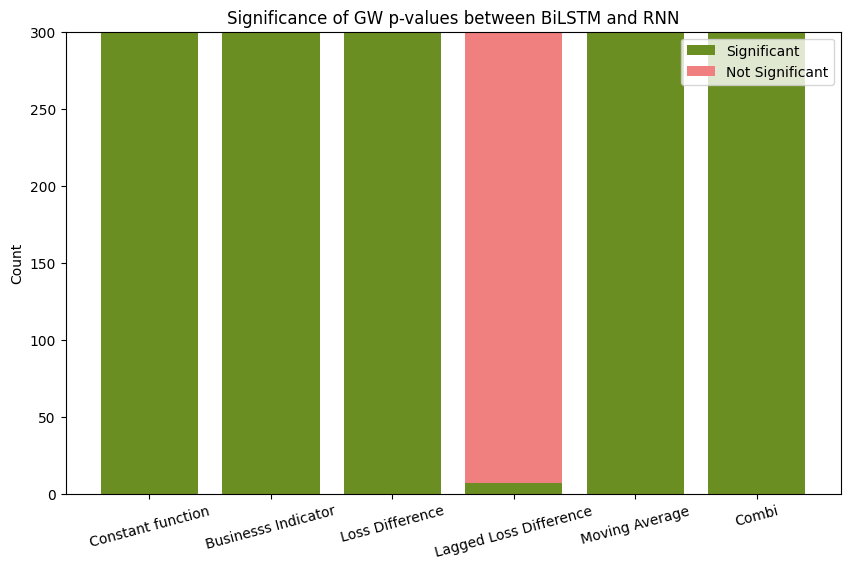

In [308]:

labels = ['Constant function', 'Businesss Indicator', 
          'Loss Difference', 'Lagged Loss Difference', 
          'Moving Average', 'Combi']


significant = [np.sum(p_values <= 0.05) for p_values in p_values_arrays_BiLSTMvsRNN]
not_significant = [n_simulations - s for s in significant]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(significant)), significant, label='Significant', color='olivedrab')
plt.bar(np.arange(len(significant)), not_significant, bottom=significant, label='Not Significant', color='lightcoral')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('Count')
plt.title('Significance of GW p-values between BiLSTM and RNN')
plt.legend()
plt.show()


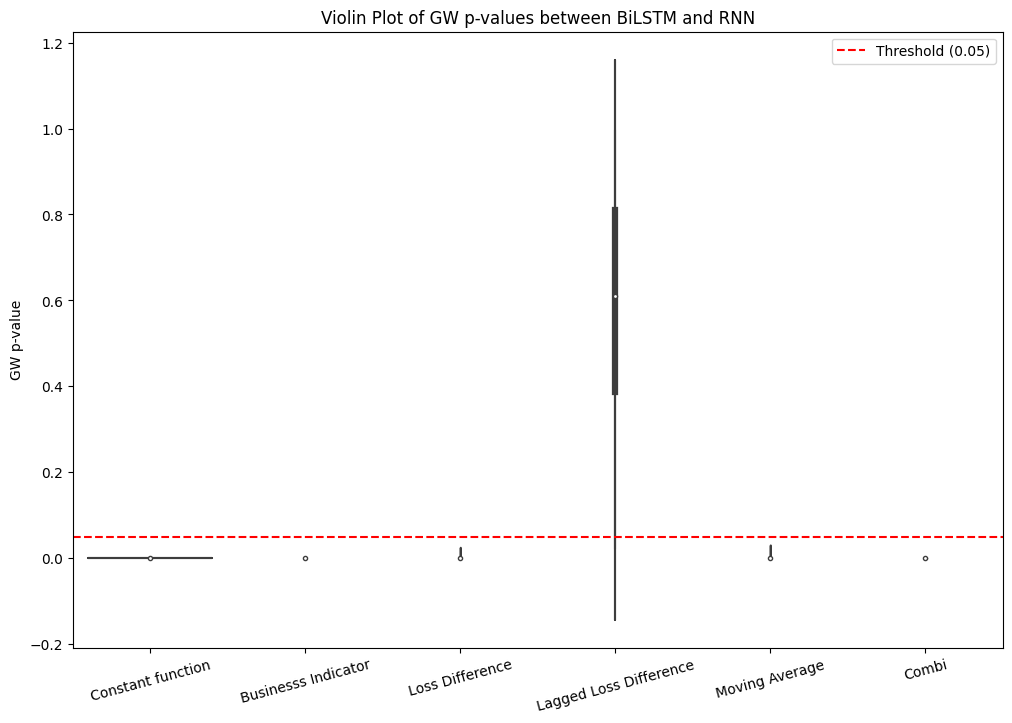

In [310]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=p_values_arrays_BiLSTMvsRNN)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('GW p-value')
plt.title('Violin Plot of GW p-values between BiLSTM and RNN')
plt.legend()
plt.show()

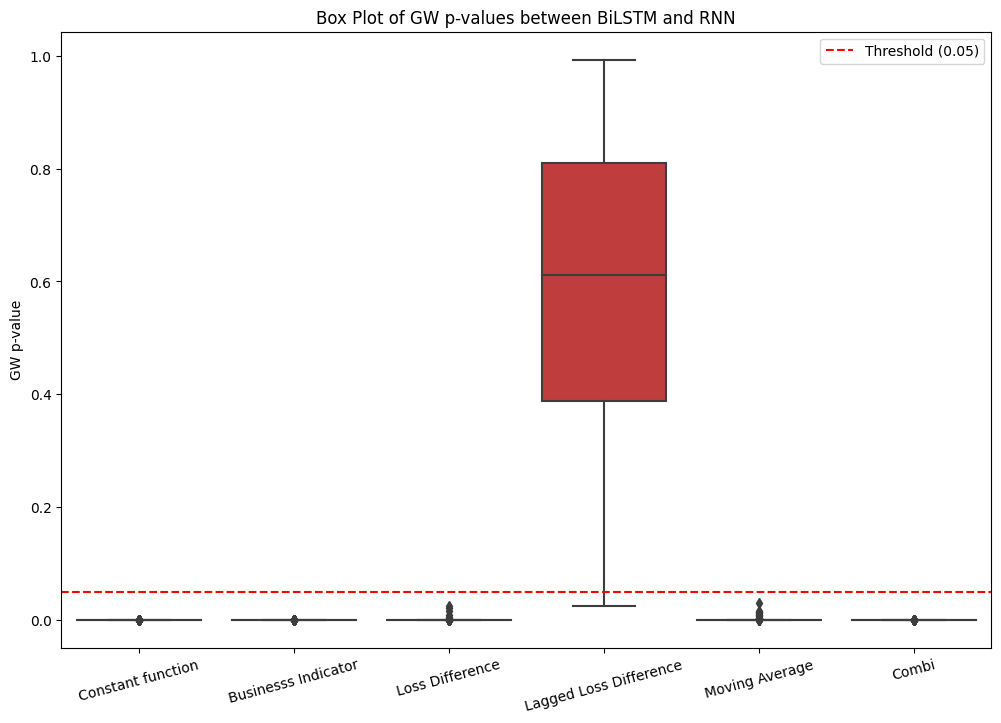

In [311]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_BiLSTMvsRNN)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('GW p-value')
plt.title('Box Plot of GW p-values between BiLSTM and RNN')

plt.legend()
plt.show()


In [312]:
# Initialize a list to store quartiles and median data
quartile_median_data = []

# Add quartiles and median annotations and store data
for i, label in enumerate(labels):
    data = p_values_arrays_BiLSTMvsRNN[i]
    quartiles = np.percentile(data, [25, 75])
    median = np.median(data)
    
    quartile_median_data.append([label, quartiles[0], quartiles[1], median])

# Display quartile and median data as a table
table = tabulate(quartile_median_data, headers=["Label", "Q1", "Q3", "Median"], tablefmt="pretty")
print(table)


+------------------------+------------------------+------------------------+------------------------+
|         Label          |           Q1           |           Q3           |         Median         |
+------------------------+------------------------+------------------------+------------------------+
|   Constant function    | 1.7628676296510548e-12 | 1.4248959789853188e-09 | 7.117045841553704e-11  |
|  Businesss Indicator   | 1.471861521551432e-11  | 3.096084663645193e-08  | 1.0131221972464743e-09 |
|    Loss Difference     | 5.490942756036787e-09  | 4.615003875940715e-06  | 2.279795461301859e-07  |
| Lagged Loss Difference |   0.3877383827473772   |   0.8098684551499603   |   0.6108502482615676   |
|     Moving Average     | 1.5543570036635757e-07 | 6.580198791533709e-05  | 3.966024021362369e-06  |
|         Combi          |  4.03549416105875e-12  | 1.6768239297082488e-08 | 3.7764602556222826e-10 |
+------------------------+------------------------+------------------------+------

### BiLSTM vs LSTM

In [313]:
""" 
p_valueLSTMvsBiLSTM_constant=np.empty(n_simulations)
p_valueBiLSTMvsLSTM_interestrate=np.empty(n_simulations)
p_valueBiLSTMvsLSTM_lossdifference=np.empty(n_simulations)
p_valueBiLSTMvsLSTM_laggedloss=np.empty(n_simulations)
p_value_MA_BiLSTMvsLSTM=np.empty(n_simulations)
p_valueLSTMvsBiLSTM_indicator_lossdifference=np.empty(n_simulations)


for i in range(n_simulations):
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))
    
    
    # Constant function
    Z_m_fixedLSTMvsBiLSTM_constant=loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :]
    Z_m_fixed_barLSTMvsBiLSTM_constant=1/n *sum(Z_m_fixedLSTMvsBiLSTM_constant)
    omegaLSTMvsBiLSTM_constant= 1/n * sum(Z_m_fixedLSTMvsBiLSTM_constant*Z_m_fixedLSTMvsBiLSTM_constant)
    teststatLSTMvsBiLSTM_constant=n*Z_m_fixed_barLSTMvsBiLSTM_constant*1/omegaLSTMvsBiLSTM_constant*Z_m_fixed_barLSTMvsBiLSTM_constant
    # Compute the p-value
    p_valueLSTMvsBiLSTM_constant[i] = 1 - chi2.cdf(teststatLSTMvsBiLSTM_constant, 1)



    # Business cycle indicator
    DeltaLSTMvsBiLSTM=(loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :])
    Z_m_fixedLSTMvsBiLSTM_interestrate=h_t_indicator_1x398*(DeltaLSTMvsBiLSTM)
    Z_m_fixedLSTMvsBiLSTM_bar_interestrate=1/n *Z_m_fixedLSTMvsBiLSTM_interestrate.sum().sum()
    omegaLSTMvsBiLSTM_interestrate= 1/n * (Z_m_fixedLSTMvsBiLSTM_interestrate*Z_m_fixedLSTMvsBiLSTM_interestrate).sum().sum()
    teststatBiLSTMvsLSTM_interestrate5=n*Z_m_fixedLSTMvsBiLSTM_bar_interestrate*1/omegaLSTMvsBiLSTM_interestrate*Z_m_fixedLSTMvsBiLSTM_bar_interestrate
    # Compute the p-value
    p_valueBiLSTMvsLSTM_interestrate[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM_interestrate5, 1)
    
    
    #Loss difference test function
    h_t_lossdifferenceBiLSTMvsLSTM=loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :]
    h_t_lossdifferenceBiLSTMvsLSTM= np.insert(h_t_lossdifferenceBiLSTMvsLSTM, 0, 0)
    h_t_lossdifferenceBiLSTMvsLSTM=h_t_lossdifferenceBiLSTMvsLSTM.reshape(1, -1)
    Z_m_fixed_BiLSTMvsLSTM=h_t_lossdifferenceBiLSTMvsLSTM[:, :-1]*(loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :])
    Z_m_fixed_bar_BiLSTMvsLSTM=1/n *Z_m_fixed_BiLSTMvsLSTM.sum()
    omegaBiLSTMvsLSTM= 1/n * (Z_m_fixed_BiLSTMvsLSTM*Z_m_fixed_BiLSTMvsLSTM).sum()
    teststatBiLSTMvsLSTM=n*Z_m_fixed_bar_BiLSTMvsLSTM*1/omegaBiLSTMvsLSTM*Z_m_fixed_bar_BiLSTMvsLSTM
    # Compute the p-value
    p_valueBiLSTMvsLSTM_lossdifference[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM, 1)

    # Lagged loss difference
    h_t_lossdifferenceBiLSTMvsLSTM=loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :]
    two_last_lossdifferenceBiLSTMvsLSTM=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred[-2:].T-train_target[-2:])
    two_last_lossdifferenceBiLSTMvsLSTM = two_last_lossdifferenceBiLSTMvsLSTM.reshape((2,))
    h_t_lossdifferenceBiLSTMvsLSTM= np.concatenate((two_last_lossdifferenceBiLSTMvsLSTM, h_t_lossdifferenceBiLSTMvsLSTM))
    h_t_lossdifferenceBiLSTMvsLSTM_lagged = h_t_lossdifferenceBiLSTMvsLSTM[1:]-h_t_lossdifferenceBiLSTMvsLSTM[:-1]
    h_t_lossdifferenceBiLSTMvsLSTM_lagged=h_t_lossdifferenceBiLSTMvsLSTM_lagged[:-1].reshape(1, -1)
    Z_m_fixed_BiLSTMvsLSTM_laggedloss=(h_t_lossdifferenceBiLSTMvsLSTM_lagged)*(loss_values_BiLSTM-loss_values_LSTM)
    Z_m_fixed_bar_BiLSTMvsLSTM_laggedloss=1/n *Z_m_fixed_BiLSTMvsLSTM_laggedloss.sum()
    omegaBiLSTMvsLSTM_laggedloss= 1/n * (Z_m_fixed_BiLSTMvsLSTM_laggedloss*Z_m_fixed_BiLSTMvsLSTM_laggedloss).sum()
    teststatBiLSTMvsLSTM_laggedloss=n*Z_m_fixed_bar_BiLSTMvsLSTM_laggedloss*1/omegaBiLSTMvsLSTM_laggedloss*Z_m_fixed_bar_BiLSTMvsLSTM_laggedloss
    # Compute the p-value
    p_valueBiLSTMvsLSTM_laggedloss[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM_laggedloss, 1)

    
    # Moving Average
    lossdiffer_LSTMvsBiLSTM=loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :]
    three_last_lossdifferenceBiLSTMvsLSTM=(train_target_pred_BiLSTM[-3:].T-train_target[-3:])-(train_target_pred[-3:].T-train_target[-3:])
    three_last_lossdifferenceBiLSTMvsLSTM = three_last_lossdifferenceBiLSTMvsLSTM.reshape((3,))
    lossdiffer_LSTMvsBiLSTM= np.concatenate((three_last_lossdifferenceBiLSTMvsLSTM, lossdiffer_LSTMvsBiLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_BiLSTMvsLSTM = []
    for m in range(k, len(lossdiffer_LSTMvsBiLSTM)+1):
        sum_delta = sum(lossdiffer_LSTMvsBiLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_BiLSTMvsLSTM.append(ma)

    Z_m_fixed_MA_BiLSTMvsLSTM=h_t_MA_BiLSTMvsLSTM[:-1]*(loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :])
    Z_m_fixed_MA_bar_BiLSTMvsLSTM=1/n *Z_m_fixed_MA_BiLSTMvsLSTM.sum()
    omegaBiLSTMvsLSTM= 1/n * (Z_m_fixed_MA_BiLSTMvsLSTM*Z_m_fixed_MA_BiLSTMvsLSTM).sum()
    teststatBiLSTMvsLSTM=n*Z_m_fixed_MA_bar_BiLSTMvsLSTM*1/omegaBiLSTMvsLSTM*Z_m_fixed_MA_bar_BiLSTMvsLSTM
    # Compute the p-value
    p_value_MA_BiLSTMvsLSTM[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM, 1)


    # Combination of test functions
    h_t_lossdifferenceBiLSTMvsLSTM=loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :]
    h_t_lossdifferenceBiLSTMvsLSTM= np.insert(h_t_lossdifferenceBiLSTMvsLSTM, 0, 0)
    h_t_lossdifferenceBiLSTMvsLSTM=h_t_lossdifferenceBiLSTMvsLSTM.reshape(1, -1)

    h_t_indicator_lossdifferenceBiLSTMvsLSTM=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsLSTM[:, :-1]))

    DeltaBiLSTMvsLSTM=(loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :])
    Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM=h_t_indicator_lossdifferenceBiLSTMvsLSTM*(DeltaBiLSTMvsLSTM)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM, (2, 1))
    omegaBiLSTMvsLSTM_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM@(Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM.T)
    teststatBiLSTMvsLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM.T)@(np.linalg.inv(omegaBiLSTMvsLSTM_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM
    # Compute the p-value
    p_valueLSTMvsBiLSTM_indicator_lossdifference[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM_indicator_lossdifference5, 2)
     """

In [352]:
""" 
p_valueLSTMvsBiLSTM_constant=np.empty(n_simulations)
p_valueBiLSTMvsLSTM_interestrate=np.empty(n_simulations)
p_valueBiLSTMvsLSTM_lossdifference=np.empty(n_simulations)
p_valueBiLSTMvsLSTM_laggedloss=np.empty(n_simulations)
p_value_MA_BiLSTMvsLSTM=np.empty(n_simulations)
p_valueLSTMvsBiLSTM_indicator_lossdifference=np.empty(n_simulations)


for i in range(n_simulations):
    Sim[i, :] = fgbm_paths[i, :]
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))
    
    
    # Constant function
    Z_m_fixedLSTMvsBiLSTM_constant=loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :]
    Z_m_fixed_barLSTMvsBiLSTM_constant=1/n *sum(Z_m_fixedLSTMvsBiLSTM_constant)
    omegaLSTMvsBiLSTM_constant= 1/n * sum(Z_m_fixedLSTMvsBiLSTM_constant*Z_m_fixedLSTMvsBiLSTM_constant)
    teststatLSTMvsBiLSTM_constant=n*Z_m_fixed_barLSTMvsBiLSTM_constant*1/omegaLSTMvsBiLSTM_constant*Z_m_fixed_barLSTMvsBiLSTM_constant
    # Compute the p-value
    p_valueLSTMvsBiLSTM_constant[i] = 1 - chi2.cdf(teststatLSTMvsBiLSTM_constant, 1)



    # Business cycle indicator
    DeltaLSTMvsBiLSTM=(loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :])
    Z_m_fixedLSTMvsBiLSTM_interestrate=h_t_indicator_1x398*(DeltaLSTMvsBiLSTM)
    Z_m_fixedLSTMvsBiLSTM_bar_interestrate=1/n *Z_m_fixedLSTMvsBiLSTM_interestrate.sum().sum()
    omegaLSTMvsBiLSTM_interestrate= 1/n * (Z_m_fixedLSTMvsBiLSTM_interestrate*Z_m_fixedLSTMvsBiLSTM_interestrate).sum().sum()
    teststatBiLSTMvsLSTM_interestrate5=n*Z_m_fixedLSTMvsBiLSTM_bar_interestrate*1/omegaLSTMvsBiLSTM_interestrate*Z_m_fixedLSTMvsBiLSTM_bar_interestrate
    # Compute the p-value
    p_valueBiLSTMvsLSTM_interestrate[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM_interestrate5, 1)
    
    
    #Loss difference test function
    h_t_lossdifferenceBiLSTMvsLSTM=loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :]
    h_t_lossdifferenceBiLSTMvsLSTM= np.insert(h_t_lossdifferenceBiLSTMvsLSTM, 0, 0)
    h_t_lossdifferenceBiLSTMvsLSTM=h_t_lossdifferenceBiLSTMvsLSTM.reshape(1, -1)
    Z_m_fixed_BiLSTMvsLSTM=h_t_lossdifferenceBiLSTMvsLSTM[:, :-1]*(loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :])
    Z_m_fixed_bar_BiLSTMvsLSTM=1/n *Z_m_fixed_BiLSTMvsLSTM.sum()
    omegaBiLSTMvsLSTM= 1/n * (Z_m_fixed_BiLSTMvsLSTM*Z_m_fixed_BiLSTMvsLSTM).sum()
    teststatBiLSTMvsLSTM=n*Z_m_fixed_bar_BiLSTMvsLSTM*1/omegaBiLSTMvsLSTM*Z_m_fixed_bar_BiLSTMvsLSTM
    # Compute the p-value
    p_valueBiLSTMvsLSTM_lossdifference[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM, 1)

    # Lagged loss difference
    h_t_lossdifferenceBiLSTMvsLSTM=loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :]
    two_last_lossdifferenceBiLSTMvsLSTM=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred[-2:].T-train_target[-2:])
    two_last_lossdifferenceBiLSTMvsLSTM = two_last_lossdifferenceBiLSTMvsLSTM.reshape((2,))
    h_t_lossdifferenceBiLSTMvsLSTM= np.concatenate((two_last_lossdifferenceBiLSTMvsLSTM, h_t_lossdifferenceBiLSTMvsLSTM))
    h_t_lossdifferenceBiLSTMvsLSTM_lagged = h_t_lossdifferenceBiLSTMvsLSTM[1:]-h_t_lossdifferenceBiLSTMvsLSTM[:-1]
    h_t_lossdifferenceBiLSTMvsLSTM_lagged=h_t_lossdifferenceBiLSTMvsLSTM_lagged[:-1].reshape(1, -1)
    Z_m_fixed_BiLSTMvsLSTM_laggedloss=(h_t_lossdifferenceBiLSTMvsLSTM_lagged)*(loss_values_BiLSTM-loss_values_LSTM)
    Z_m_fixed_bar_BiLSTMvsLSTM_laggedloss=1/n *Z_m_fixed_BiLSTMvsLSTM_laggedloss.sum()
    omegaBiLSTMvsLSTM_laggedloss= 1/n * (Z_m_fixed_BiLSTMvsLSTM_laggedloss*Z_m_fixed_BiLSTMvsLSTM_laggedloss).sum()
    teststatBiLSTMvsLSTM_laggedloss=n*Z_m_fixed_bar_BiLSTMvsLSTM_laggedloss*1/omegaBiLSTMvsLSTM_laggedloss*Z_m_fixed_bar_BiLSTMvsLSTM_laggedloss
    # Compute the p-value
    p_valueBiLSTMvsLSTM_laggedloss[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM_laggedloss, 1)

    
    # Moving Average
    lossdiffer_LSTMvsBiLSTM=loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :]
    three_last_lossdifferenceBiLSTMvsLSTM=(train_target_pred_BiLSTM[-3:].T-train_target[-3:])-(train_target_pred[-3:].T-train_target[-3:])
    three_last_lossdifferenceBiLSTMvsLSTM = three_last_lossdifferenceBiLSTMvsLSTM.reshape((3,))
    lossdiffer_LSTMvsBiLSTM= np.concatenate((three_last_lossdifferenceBiLSTMvsLSTM, lossdiffer_LSTMvsBiLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_BiLSTMvsLSTM = []
    for m in range(k, len(lossdiffer_LSTMvsBiLSTM)+1):
        sum_delta = sum(lossdiffer_LSTMvsBiLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_BiLSTMvsLSTM.append(ma)

    Z_m_fixed_MA_BiLSTMvsLSTM=h_t_MA_BiLSTMvsLSTM[:-1]*(loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :])
    Z_m_fixed_MA_bar_BiLSTMvsLSTM=1/n *Z_m_fixed_MA_BiLSTMvsLSTM.sum()
    omegaBiLSTMvsLSTM= 1/n * (Z_m_fixed_MA_BiLSTMvsLSTM*Z_m_fixed_MA_BiLSTMvsLSTM).sum()
    teststatBiLSTMvsLSTM=n*Z_m_fixed_MA_bar_BiLSTMvsLSTM*1/omegaBiLSTMvsLSTM*Z_m_fixed_MA_bar_BiLSTMvsLSTM
    # Compute the p-value
    p_value_MA_BiLSTMvsLSTM[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM, 1)


    # Combination of test functions
    h_t_lossdifferenceBiLSTMvsLSTM=loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :]
    h_t_lossdifferenceBiLSTMvsLSTM= np.insert(h_t_lossdifferenceBiLSTMvsLSTM, 0, 0)
    h_t_lossdifferenceBiLSTMvsLSTM=h_t_lossdifferenceBiLSTMvsLSTM.reshape(1, -1)

    h_t_indicator_lossdifferenceBiLSTMvsLSTM=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsLSTM[:, :-1]))

    DeltaBiLSTMvsLSTM=(loss_values_BiLSTM_Sim[i, :]-loss_values_LSTM_Sim[i, :])
    Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM=h_t_indicator_lossdifferenceBiLSTMvsLSTM*(DeltaBiLSTMvsLSTM)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM, (2, 1))
    omegaBiLSTMvsLSTM_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM@(Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM.T)
    teststatBiLSTMvsLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM.T)@(np.linalg.inv(omegaBiLSTMvsLSTM_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM
    # Compute the p-value
    p_valueLSTMvsBiLSTM_indicator_lossdifference[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM_indicator_lossdifference5, 2)
     """

In [314]:
""" p_values_arrays_LSTMvsBiLSTM = [p_valueLSTMvsBiLSTM_constant, p_valueBiLSTMvsLSTM_interestrate, 
                   p_valueBiLSTMvsLSTM_lossdifference, p_valueBiLSTMvsLSTM_laggedloss, 
                   p_value_MA_BiLSTMvsLSTM, p_valueLSTMvsBiLSTM_indicator_lossdifference] """

In [315]:
""" 
# Specify the file path where you want to save the array
file_path = "p_values_arrays_LSTMvsBiLSTM.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(p_values_arrays_LSTMvsBiLSTM, binary_file) 
 """

In [316]:
# Load the data from the binary file
with open("p_values_arrays_LSTMvsBiLSTM.pkl", "rb") as binary_file:
    p_values_arrays_LSTMvsBiLSTM = pickle.load(binary_file)

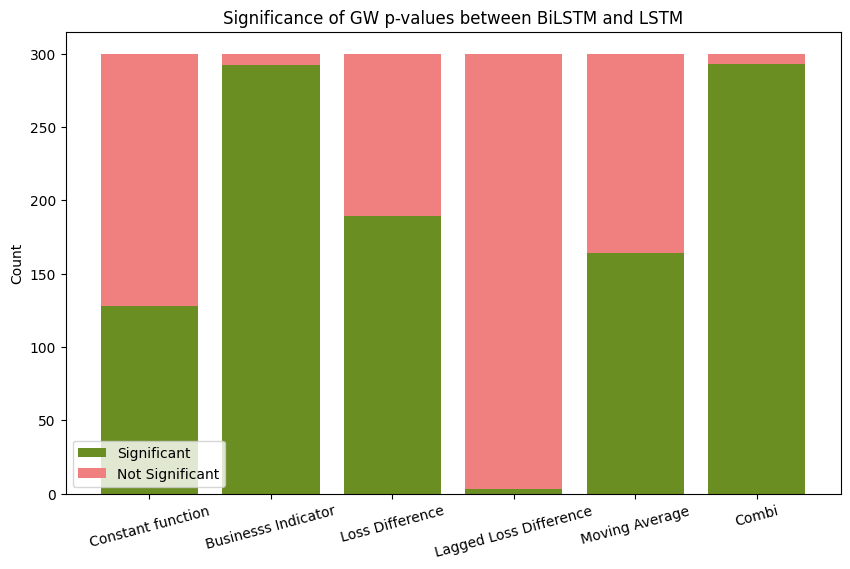

In [317]:

labels = ['Constant function', 'Businesss Indicator', 
          'Loss Difference', 'Lagged Loss Difference', 
          'Moving Average', 'Combi']


significant = [np.sum(p_values <= 0.05) for p_values in p_values_arrays_LSTMvsBiLSTM]
not_significant = [n_simulations - s for s in significant]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(significant)), significant, label='Significant', color='olivedrab')
plt.bar(np.arange(len(significant)), not_significant, bottom=significant, label='Not Significant', color='lightcoral')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('Count')
plt.title('Significance of GW p-values between BiLSTM and LSTM')
plt.legend()
plt.show()


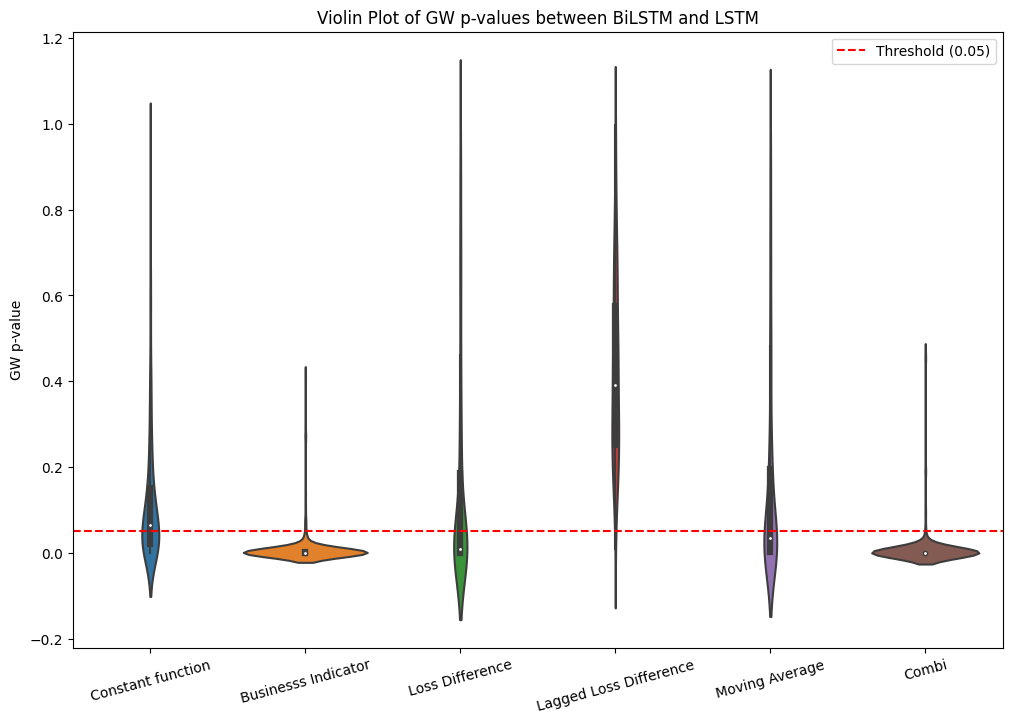

In [318]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=p_values_arrays_LSTMvsBiLSTM)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('GW p-value')
plt.title('Violin Plot of GW p-values between BiLSTM and LSTM')
plt.legend()
plt.show()

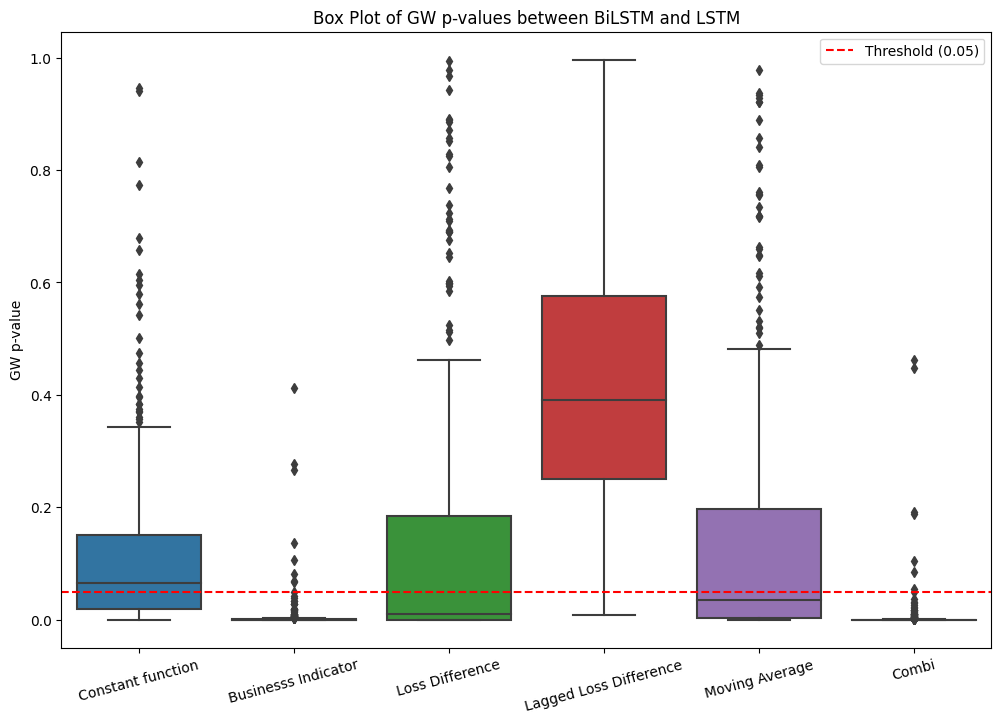

In [319]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_LSTMvsBiLSTM)


plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('GW p-value')
plt.title('Box Plot of GW p-values between BiLSTM and LSTM')

plt.legend()
plt.show()


In [320]:
# Initialize a list to store quartiles and median data
quartile_median_data = []

# Add quartiles and median annotations and store data
for i, label in enumerate(labels):
    data = p_values_arrays_LSTMvsBiLSTM[i]
    quartiles = np.percentile(data, [25, 75])
    median = np.median(data)
    
    quartile_median_data.append([label, quartiles[0], quartiles[1], median])

# Display quartile and median data as a table
table = tabulate(quartile_median_data, headers=["Label", "Q1", "Q3", "Median"], tablefmt="pretty")
print(table)


+------------------------+------------------------+-----------------------+------------------------+
|         Label          |           Q1           |          Q3           |         Median         |
+------------------------+------------------------+-----------------------+------------------------+
|   Constant function    |  0.019749484796526245  |  0.15050300128737484  |  0.06593289476833758   |
|  Businesss Indicator   | 1.0394680084457875e-06 | 0.0009716695239948003 | 3.9065997873288794e-05 |
|    Loss Difference     | 0.00024058548337688168 |  0.1851037560607481   |  0.009534789052382198  |
| Lagged Loss Difference |  0.25111063399504296   |  0.5757042102267547   |  0.39102719242655504   |
|     Moving Average     | 0.0028053948057398803  |  0.1962829775995224   |  0.03515315895783727   |
|         Combi          | 2.8925757677988884e-07 | 0.0003130024210250826 | 1.4147165064204437e-05 |
+------------------------+------------------------+-----------------------+----------------